# Setup

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import gpytorch
import math
import seaborn as sns
import random
from tqdm import trange
from collections import Counter
from scipy.interpolate import splrep, interp1d
from sklearn import preprocessing
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.likelihoods import GaussianLikelihood, StudentTLikelihood
from gpytorch.models import ApproximateGP
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.mlls import ExactMarginalLogLikelihood, VariationalELBO
import matplotlib.ticker as ticker
import matplotlib.tri as tri
import matplotlib.font_manager as font_manager

# check for MPS and CUDA device availability
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found, setting as device.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device found, setting as device.")
else:
    device = torch.device("cpu")
    print("Neither MPS nor CUDA device found. Using default device (CPU).")


# set the seed for all random use
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)

class STP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=False
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ExactGP(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        # build the model using the ExactGP model from gpytorch
        super(ExactGP, self).__init__(x_train, y_train, likelihood)

        # use a constant mean, this value can be learned from the dataset
        self.mean_module = gpytorch.means.ConstantMean()

        # automatically determine the number of dimensions for the ARD kernel
        num_dimensions = x_train.shape[1]

        # use a scaled Matern kernel, the ScaleKernel allows the kernel to learn a scale factor for the dataset
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5,ard_num_dims=num_dimensions))
            
        # set the number of outputs 
        self.num_outputs = 1

    def forward(self, x):
        # forward pass of the model

        # compute the mean and covariance of the model 
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # return the MultivariateNormal distribution of the mean and covariance 
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class VariationalGP(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(VariationalGP, self).__init__(variational_strategy)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=inducing_points.size(1)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
class TorchStandardScaler:
    def fit(self, x):
        x = x.clone()
        # calculate mean and std of the tensor
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
    def transform(self, x):
        x = x.clone()
        # standardize the tensor
        x -= self.mean
        x /= (self.std + 1e-10)
        return x
    def fit_transform(self, x):
        # copy the tensor as to not modify the original 
        x = x.clone()
        # calculate mean and std of the tensor
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
        # standardize the tensor
        x -= self.mean
        x /= (self.std + 1e-10)
        return x
    
class TorchNormalizer:
    def fit(self, x):
        # calculate the maximum value and the minimum value of the tensor
        self.max = torch.max(x, dim=0).values
        self.min = torch.min(x, dim=0).values

    def transform(self, x):
        # normalize the tensor
        return (x.clone() - self.min) / (self.max - self.min)

    def fit_transform(self, x):
        # calculate the maximum value and the minimum value of the tensor
        self.max = torch.max(x, dim=0).values
        self.min = torch.min(x, dim=0).values
        # normalize the tensor
        return (x.clone() - self.min) / (self.max - self.min)
    
# Upper Confidence Bound
def UCBmax(mean, std, beta):
    return mean + beta * std

def UCBmin(mean, std, beta):
    return mean - beta * std

# Expected Improvement
def EImin(mean, std, best_observed):
    z = (best_observed - mean) / std
    return (best_observed - mean) * torch.distributions.Normal(0, 1).cdf(z) + std * torch.distributions.Normal(0, 1).log_prob(z)

def EImax(mean, std, best_observed):
    z = (mean - best_observed) / std
    return (mean - best_observed) * torch.distributions.Normal(0, 1).cdf(z) + std * torch.distributions.Normal(0, 1).log_prob(z)
    
# Initial setup
campaigns = 50
num_initial_points = 3
num_new_samples_per_iteration = 1

maxDatasets = ['AutoAM', 'P3HT']
minDatasets = ['Perovskite']

CUDA device found, setting as device.


# STP BO Loop

In [55]:

def runMinSTP(seed):  
    print("Minimizing with STP") 
    set_seeds(seed)
    iterationSTP = [0]
    topSTP = [0]

    # Calculate the threshold for the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.05)

    # Identify indices of samples not in the top 5%
    non_top_5_indices = (train_y > top_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these non-top-5% indices
    indicesSTP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
    indicesSTP = non_top_5_indices[indicesSTP]

    # Select the corresponding points from train_x and train_y
    train_xSTP = train_x[indicesSTP]
    train_ySTP = train_y[indicesSTP]

    print(f"Seed: {seed}")
    print(f"Initial points: {train_xSTP}")
        
    while topSTP[-1] < 100:
        iterationSTP.append(iterationSTP[-1] + 1)
        # standardize the initial inputs and outputs before
        train_xSTP = TorchStd.transform(train_xSTP)
        train_ySTP = TorchStandardScaler().fit_transform(train_ySTP).flatten() # Ensure y is 1-dimensional

        #def train_and_test_approximate_gp(objective_function_cls):
        model = STP(train_xSTP).to(dtype=torch.float64)
        #likelihood = gpytorch.likelihoods.GaussianLikelihood()
        likelihood = gpytorch.likelihoods.StudentTLikelihood()
        objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_ySTP.numel())
        # replace with gpytorch mll
        optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

            

        # Train
        model.train()
        #put it into training mode
        likelihood.train()

        for _ in range(50):
            output = model(train_xSTP)
            loss = -objective_function(output, train_ySTP)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                


        # Test
        model.eval()
        likelihood.eval()

        # works wtih the variational distribution
        with gpytorch.settings.num_likelihood_samples(512):
            observed_pred = likelihood(model(TorchStd.transform(train_x)))

        samples = observed_pred.sample()


        # use as inputs to EI
        meanSTP = samples.mean(dim=0)
        stdSTP = samples.std(dim=0)
    
            

         # Select new points using UCB
        acq_values = UCBmin(meanSTP, stdSTP, 1.96)
        acq_values[indicesSTP] = float('inf')
        indicesSTP = torch.cat([indicesSTP, acq_values.argmin().unsqueeze(0)])

        # Convert new_indices to a tensor
        # Add the new points to the training data
        train_xSTP = train_x[indicesSTP]
        train_ySTP = train_y[indicesSTP]
        topSTP.append(TopSamplesAmnt(train_ySTP, top_samples)*100)


        if iterationSTP[-1] > len(train_x) - num_initial_points:
            print("Maximum number of iterations exceeded, breaking loop.")
            return topSTP, iterationSTP
            break
            
    print(f'Iterations {iterationSTP[-1]}')
    return topSTP, iterationSTP

def runMaxSTP(seed):   
    print("Maximizing with STP")
    set_seeds(seed)
    iterationSTP = [0]
    topSTP = [0]

    # Calculate the threshold for the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.95)

    # Identify indices of samples not in the top 5%
    non_top_5_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these non-top-5% indices
    indicesSTP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
    indicesSTP = non_top_5_indices[indicesSTP]

    # Select the corresponding points from train_x and train_y
    train_xSTP = train_x[indicesSTP]
    train_ySTP = train_y[indicesSTP]

    print(f"Seed: {seed}")
    print(f"Initial points: {train_xSTP}")
        
    while topSTP[-1] < 100:
        iterationSTP.append(iterationSTP[-1] + 1)
        # standardize the initial inputs and outputs before
        train_xSTP = TorchStd.transform(train_xSTP)
        train_ySTP = TorchStandardScaler().fit_transform(train_ySTP).flatten() # Ensure y is 1-dimensional


        #def train_and_test_approximate_gp(objective_function_cls):
        model = STP(train_xSTP).to(dtype=torch.float64)
        #likelihood = gpytorch.likelihoods.GaussianLikelihood()
        likelihood = gpytorch.likelihoods.StudentTLikelihood()
        objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_ySTP.numel())
        # replace with gpytorch mll
        optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

            

        # Train
        model.train()
        #put it into training mode
        likelihood.train()

        for _ in range(50):
            output = model(train_xSTP)
            loss = -objective_function(output, train_ySTP)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                


        # Test
        model.eval()
        likelihood.eval()

        # works wtih the variational distribution
        with gpytorch.settings.num_likelihood_samples(512):
            pred = likelihood(model(TorchStd.transform(train_x)))

        samples = pred.sample()
        # use as inputs to UCB 
        meanSTP = samples.mean(dim=0)
        stdSTP = samples.std(dim=0)

            
         # Select new points using UCB
        acq_values = UCBmax(meanSTP, stdSTP, 1.96)
        acq_values[indicesSTP] = -float('inf')
        indicesSTP = torch.cat([indicesSTP, acq_values.argmax().unsqueeze(0)])

        # Convert new_indices to a tensor
        # Add the new points to the training data
        train_xSTP = train_x[indicesSTP]
        train_ySTP = train_y[indicesSTP]
        
        topSTP.append(TopSamplesAmnt(train_ySTP, top_samples)*100)
        if iterationSTP[-1] > len(train_x) - num_initial_points:
            print("Maximum number of iterations exceeded, breaking loop.")
            print(f"Reached {topSTP[-1]}%")
            return topSTP, iterationSTP
            break


    print(f'Iterations {iterationSTP[-1]}')

    return topSTP, iterationSTP

# EGP BO Loop

In [56]:

def runMinEGP(seed):
    print("Minimizing with EGP")
    set_seeds(seed)    
    iterationEGP = [0]
    topEGP = [0]

    N = len(train_y) # Number of points you want to sample

    # Calculate the threshold for the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.05)

    # Identify indices of samples not in the top 5%
    non_top_5_indices = (train_y > top_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these non-top-5% indices
    indicesEGP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
    indicesEGP = non_top_5_indices[indicesEGP]

    # Select the corresponding points from train_x and train_y
    train_xEGP = train_x[indicesEGP]
    train_yEGP = train_y[indicesEGP]

    print(f"Seed: {seed}")
    print(f"Initial points: {train_xEGP}")
    
    while topEGP[-1] < 100:
        iterationEGP.append(iterationEGP[-1] + 1)
        # standardize the initial inputs and outputs before
        train_xEGP = TorchStd.transform(train_xEGP)
        train_yEGP = TorchStandardScaler().fit_transform(train_yEGP).flatten()

        # optimize the model
        # use a half normal prior for the noise to find a Gaussian likelihood
        likelihood = GaussianLikelihood(noise_prior=gpytorch.priors.HalfNormalPrior(0.01))

        # using the found likelihood, create a GP model
        gp = ExactGP(train_xEGP, train_yEGP, likelihood)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

        # fit the model by maximizing the marginal log likelihood
        gp.train()
        likelihood.train()
        fit_gpytorch_mll(mll)

        gp.eval()
        likelihood.eval()

        # predict from candidate pool
        with torch.no_grad():
            pred = gp(TorchStd.transform(train_x)) # predict values for all candidates

        meanEGP = pred.mean
        stdEGP = pred.stddev
        

        # pass the predictions through an acquisition function to find the next best point to sample
        acq_values = UCBmin(meanEGP, stdEGP, 1.96)
        acq_values[indicesEGP] = float('inf')
        indicesEGP = torch.cat([indicesEGP, acq_values.argmin().unsqueeze(0)])
        

        # add the new point to the training data
        train_xEGP = train_x[indicesEGP]
        train_yEGP = train_y[indicesEGP]
        topEGP.append(TopSamplesAmnt(train_yEGP, top_samples)*100)
        
        if iterationEGP[-1] > len(train_x) - num_initial_points:
            print("Maximum number of iterations exceeded, breaking loop.")
            return topEGP, iterationEGP
            break

    print(f'Iterations {iterationEGP[-1]}')
    return topEGP, iterationEGP

def runMaxEGP(seed):
    print("Maximizing with EGP")
    set_seeds(seed)    
    iterationEGP = [0]
    topEGP = [0]
    # Assuming train_x and train_y are your dataset

    # Calculate the threshold for the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.95)

    # Identify indices of samples not in the top 5%
    non_top_5_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these non-top-5% indices
    indicesEGP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
    indicesEGP = non_top_5_indices[indicesEGP]

    # Select the corresponding points from train_x and train_y
    train_xEGP = train_x[indicesEGP]
    train_yEGP = train_y[indicesEGP]

    print(f"Seed: {seed}")
    print(f"Initial points: {train_xEGP}")

    while topEGP[-1] < 100:
        iterationEGP.append(iterationEGP[-1] + 1)
        # standardize the initial inputs and outputs before
        train_xEGP = TorchStd.transform(train_xEGP)
        train_yEGP = TorchStandardScaler().fit_transform(train_yEGP).flatten()


        # optimize the model
        # use a half normal prior for the noise to find a Gaussian likelihood
        likelihood = GaussianLikelihood(noise_prior=gpytorch.priors.HalfNormalPrior(0.01))

        # using the found likelihood, create a GP model
        gp = ExactGP(train_xEGP, train_yEGP, likelihood)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

        # fit the model by maximizing the marginal log likelihood
        gp.train()
        likelihood.train()
        fit_gpytorch_mll(mll)

        gp.eval()
        likelihood.eval()

        # predict from candidate pool
        with torch.no_grad():
            pred = gp(TorchStd.transform(train_x)) # predict values for all candidates

        meanEGP = pred.mean
        stdEGP = pred.stddev
    

        # pass the predictions through an acquisition function to find the next best point to sample
        acq_values = UCBmax(meanEGP, stdEGP, 1.96)
        acq_values[indicesEGP] = -float('inf')
        indicesEGP = torch.cat([indicesEGP, acq_values.argmax().unsqueeze(0)])
        
        # add the new point to the training data
        train_xEGP = train_x[indicesEGP]
        train_yEGP = train_y[indicesEGP]
        topEGP.append(TopSamplesAmnt(train_yEGP, top_samples)*100)
        
        if iterationEGP[-1] > len(train_x) - num_initial_points:
            print(f"Reached {topEGP[-1]}%")
            print("Maximum number of iterations exceeded, breaking loop.")
            return topEGP, iterationEGP
            break

    
    print(f'Iterations {iterationEGP[-1]}')

    return topEGP, iterationEGP

# VGP BO Loop

In [57]:

def runMinVGP(seed):    
    print("Minimizing with VGP")
    set_seeds(seed)
    iterationVGP = [0]
    topVGP = [0]

    # Calculate the threshold for the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.05)

    # Identify indices of samples not in the top 5%
    non_top_5_indices = (train_y > top_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these non-top-5% indices
    indicesVGP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
    indicesVGP = non_top_5_indices[indicesVGP]

    # Select the corresponding points from train_x and train_y
    train_xVGP = train_x[indicesVGP]
    train_yVGP = train_y[indicesVGP]

    print(f"Seed: {seed}")
    print(f"Initial points: {train_xVGP}")
    
    while topVGP[-1] < 100:
        
        iterationVGP.append(iterationVGP[-1] + 1)
        # standardize the initial inputs and outputs before
        train_xVGP = TorchStd.transform(train_xVGP)
        train_yVGP = TorchStandardScaler().fit_transform(train_yVGP).flatten()

        #def train_and_test_approximate_gp(objective_function_cls):
        model = VariationalGP(train_xVGP).to(dtype=torch.float64)

        likelihood = GaussianLikelihood()
        objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_yVGP.numel())
        # replace with gpytorch mll
        optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

        # Train
        model.train()
        #put it into training mode
        likelihood.train()

        for _ in range(50):
            output = model(train_xVGP)
            loss = -objective_function(output, train_yVGP)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Test
        model.eval()
        likelihood.eval()

        # works wtih the variational distribution
        with torch.no_grad():
            pred = model(TorchStd.transform(train_x))


        # get the mean and standard deviation of the samples
        meanVGP = pred.mean
        stdVGP = pred.stddev


        # Select new points using UCB
        acq_values = UCBmin(meanVGP, stdVGP, 1.96)
        acq_values[indicesVGP] = float('inf')
        indicesVGP = torch.cat([indicesVGP, acq_values.argmin().unsqueeze(0)])


        # Convert new_indices to a tensor
        # Add the new points to the training data
        train_xVGP = train_x[indicesVGP]
        train_yVGP = train_y[indicesVGP]
        topVGP.append(TopSamplesAmnt(train_yVGP, top_samples)*100)

        if iterationVGP[-1] > len(train_x) - num_initial_points:
            print("Maximum number of iterations exceeded, breaking loop.")
            print(f"Reached {topVGP[-1]}%")
            return topVGP, iterationVGP
            break

    
    print(f'Iterations {iterationVGP[-1]}')

    return topVGP, iterationVGP
    
def runMaxVGP(seed):   


    
    print("Maximizing with VGP") 
    set_seeds(seed)
    iterationVGP = [0]
    topVGP = [0]

    # Calculate the threshold for the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.95)

    # Identify indices of samples not in the top 5%
    non_top_5_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these non-top-5% indices
    indicesVGP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
    indicesVGP = non_top_5_indices[indicesVGP]

    # Select the corresponding points from train_x and train_y
    train_xVGP = train_x[indicesVGP]
    train_yVGP = train_y[indicesVGP]
    print(f"Seed: {seed}")
    print(f"Initial points: {train_xVGP}")
    
    
    while topVGP[-1] < 100:
        
        iterationVGP.append(iterationVGP[-1] + 1)
        # standardize the initial inputs and outputs before
        train_xVGP = TorchStd.transform(train_xVGP)
        train_yVGP = TorchStandardScaler().fit_transform(train_yVGP).flatten()

        #def train_and_test_approximate_gp(objective_function_cls):
        model = VariationalGP(train_xVGP).to(dtype=torch.float64)

        likelihood = GaussianLikelihood()
        objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_yVGP.numel())
        # replace with gpytorch mll
        optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

        # Train
        model.train()
        #put it into training mode
        likelihood.train()

        for _ in range(50):
            output = model(train_xVGP)
            loss = -objective_function(output, train_yVGP)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Test
        model.eval()
        likelihood.eval()

        # predict from candidate pool
        with torch.no_grad():
            pred = model(TorchStd.transform(train_x))

        # find the mean and standard deviation of the preidictions
        meanVGP = pred.mean
        stdVGP = pred.stddev
      

        # Select new points using UCB
        acq_values = UCBmax(meanVGP, stdVGP, 1.96)
        acq_values[indicesVGP] = -float('inf')
        indicesVGP = torch.cat([indicesVGP, acq_values.argmax().unsqueeze(0)])

        # Convert new_indices to a tensor
        # Add the new points to the training data
        train_xVGP = train_x[indicesVGP]
        train_yVGP = train_y[indicesVGP]
        topVGP.append(TopSamplesAmnt(train_yVGP, top_samples)*100)

        if iterationVGP[-1] > len(train_x) - num_initial_points:
            print("Maximum number of iterations exceeded, breaking loop.")
            print(f"Reached {topVGP[-1]}%")
            return topVGP, iterationVGP
            break

    print(f'Iterations {iterationVGP[-1]}')

    return topVGP, iterationVGP


# Maximum Test

<string>:7: SyntaxWarning: invalid escape sequence '\{'
<>:7: SyntaxWarning: invalid escape sequence '\{'
<string>:7: SyntaxWarning: invalid escape sequence '\{'
<>:7: SyntaxWarning: invalid escape sequence '\{'
C:\Users\stan\AppData\Local\Temp\ipykernel_35956\1112889032.py:7: SyntaxWarning: invalid escape sequence '\{'
  data = pd.read_csv(f"datasets\{dataset}_dataset.csv")


Starting AutoAM
Number of samples: 85
Number of of top 5% samples: 5
Top 5% samples: [0.936549, 0.932613, 0.92212, 0.904846, 0.902128]


  0%|          | 0/50 [00:00<?, ?it/s]

Maximizing with EGP
Seed: 864
Initial points: tensor([[ 5.0000,  7.3613, -0.2902, -1.0000],
        [ 0.0000,  2.5903, -0.2736, -0.1288],
        [ 5.0000, 10.0000, -0.4538, -1.0000],
        [ 0.0000,  0.1000, -0.2270, -0.2032],
        [ 0.0000,  1.5957, -0.3206, -0.4308]], dtype=torch.float64)


  2%|▏         | 1/50 [00:01<01:20,  1.64s/it]

Iterations 14
Maximizing with EGP
Seed: 394
Initial points: tensor([[ 0.0000,  3.2714, -0.2151, -0.1070],
        [ 0.0000,  3.4102, -0.1820, -0.2266],
        [ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 0.1593,  0.7977, -0.2004,  0.0291]], dtype=torch.float64)


  4%|▍         | 2/50 [00:04<02:03,  2.57s/it]

Iterations 24
Maximizing with EGP
Seed: 776
Initial points: tensor([[ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 0.6155,  3.1238, -0.2301, -0.0963],
        [ 2.2161,  0.1000, -0.3517, -0.6288],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 5.0000,  6.4638, -0.4718, -0.5640]], dtype=torch.float64)


  6%|▌         | 3/50 [00:08<02:19,  2.97s/it]

Iterations 30
Maximizing with EGP
Seed: 911
Initial points: tensor([[ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 0.0000,  3.3212, -0.1959, -0.1870],
        [ 0.0000,  2.5215, -0.2784, -0.1474],
        [ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 2.0609,  5.4800,  0.0944,  0.1017]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numeri

Iterations 12
Maximizing with EGP
Seed: 430
Initial points: tensor([[ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.0000,  3.1790, -0.2991, -0.0796],
        [ 0.0000,  1.6900, -0.4148, -0.5639],
        [ 5.0000,  6.4638, -0.4718, -0.5640]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
 10%|█         | 5/50 [00:13<02:01,  2.69s/it]

Iterations 21
Maximizing with EGP
Seed: 41
Initial points: tensor([[ 0.0371,  0.8939, -0.0352,  0.0479],
        [ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.1593,  0.7977, -0.2004,  0.0291],
        [ 5.0000,  0.1000, -0.4233, -1.0000],
        [ 0.0000,  0.4773,  0.0410,  0.1919]], dtype=torch.float64)


 12%|█▏        | 6/50 [00:17<02:16,  3.10s/it]

Iterations 21
Maximizing with EGP
Seed: 265
Initial points: tensor([[ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 0.0000,  2.5215, -0.2784, -0.1474],
        [ 5.0000,  7.3613, -0.2902, -1.0000],
        [ 1.4521,  4.7555, -0.2764, -1.0000],
        [ 0.0000,  3.3212, -0.1959, -0.1870]], dtype=torch.float64)


 14%|█▍        | 7/50 [00:19<02:02,  2.85s/it]

Iterations 18
Maximizing with EGP
Seed: 988
Initial points: tensor([[ 0.0000, 10.0000, -0.4595, -1.0000],
        [ 5.0000, 10.0000, -0.3926, -1.0000],
        [ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 0.9915,  3.3743, -0.2587, -0.4005],
        [ 0.0000,  2.0191, -0.3103, -0.2361]], dtype=torch.float64)


 16%|█▌        | 8/50 [00:21<01:54,  2.73s/it]

Iterations 16
Maximizing with EGP
Seed: 523
Initial points: tensor([[ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 0.0000,  3.1974, -0.2930, -0.0577],
        [ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 2.5684,  4.1282, -0.5554, -1.0000]], dtype=torch.float64)


 18%|█▊        | 9/50 [00:24<01:49,  2.68s/it]

Iterations 17
Maximizing with EGP
Seed: 497
Initial points: tensor([[ 2.6662,  3.4044, -0.3233, -1.0000],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 5.0000,  7.4215, -0.4697, -1.0000],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 5.0000,  0.1000, -0.2250, -1.0000]], dtype=torch.float64)


 20%|██        | 10/50 [00:26<01:44,  2.62s/it]

Iterations 19
Maximizing with EGP
Seed: 414
Initial points: tensor([[ 0.0000,  0.4773,  0.0410,  0.1919],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 5.0000,  5.1008, -0.3230, -1.0000]], dtype=torch.float64)


 22%|██▏       | 11/50 [00:30<01:47,  2.77s/it]

Iterations 20
Maximizing with EGP
Seed: 940
Initial points: tensor([[ 0.0000,  3.2964, -0.2238, -0.0925],
        [ 0.0000,  3.1790, -0.2991, -0.0796],
        [ 0.0000,  0.1000, -0.1540, -0.6338],
        [ 2.5592,  2.7477, -0.1235, -1.0000],
        [ 0.0000,  2.2215, -0.3013, -0.2119]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 24%|██▍       | 12/50 [00:32<01:41,  2.67s/it]

Iterations 15
Maximizing with EGP
Seed: 802
Initial points: tensor([[ 2.0609,  5.4800,  0.0944,  0.1017],
        [ 0.0000,  2.0191, -0.3103, -0.2361],
        [ 0.0000, 10.0000, -0.4595, -1.0000],
        [ 0.0000,  8.0179, -0.2473, -0.2150],
        [ 0.0000,  3.2952, -0.2010, -0.1887]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical i

Iterations 17
Maximizing with EGP
Seed: 849
Initial points: tensor([[ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 5.0000,  0.1000, -0.4233, -1.0000],
        [ 2.5592,  2.7477, -0.1235, -1.0000]], dtype=torch.float64)


 28%|██▊       | 14/50 [00:37<01:35,  2.64s/it]

Iterations 24
Maximizing with EGP
Seed: 310
Initial points: tensor([[ 0.0000, 10.0000,  0.0697, -1.0000],
        [ 2.0609,  5.4800,  0.0944,  0.1017],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 0.0000,  1.5957, -0.3206, -0.4308]], dtype=torch.float64)


 30%|███       | 15/50 [00:39<01:24,  2.42s/it]

Iterations 13
Maximizing with EGP
Seed: 991
Initial points: tensor([[ 5.0000,  7.3613, -0.2902, -1.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 3.5802,  7.8585, -0.3792, -1.0000],
        [ 0.1593,  0.7977, -0.2004,  0.0291],
        [ 0.0000,  1.8085, -0.4126, -0.2537]], dtype=torch.float64)


 32%|███▏      | 16/50 [00:41<01:18,  2.30s/it]

Iterations 18
Maximizing with EGP
Seed: 488
Initial points: tensor([[ 0.7424,  1.7146, -0.3803, -0.4165],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 5.0000, 10.0000, -0.4538, -1.0000],
        [ 3.7044, 10.0000, -0.3167, -1.0000],
        [ 5.0000,  5.0000, -0.1000, -0.1000]], dtype=torch.float64)


 34%|███▍      | 17/50 [00:43<01:11,  2.15s/it]

Iterations 18
Maximizing with EGP
Seed: 366
Initial points: tensor([[ 5.0000,  6.4638, -0.4718, -0.5640],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 0.0000,  3.2952, -0.2010, -0.1887],
        [ 0.0000,  2.0191, -0.3103, -0.2361],
        [ 2.5684,  4.1282, -0.5554, -1.0000]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
 36%|███▌      | 18/50 [00:45<01:06,  2.09s/it]

Iterations 17
Maximizing with EGP
Seed: 597
Initial points: tensor([[ 3.2702,  4.4234, -0.3743, -1.0000],
        [ 0.0000,  8.0179, -0.2473, -0.2150],
        [ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 5.0000,  1.7701, -0.7340, -1.0000],
        [ 5.0000, 10.0000, -0.3926, -1.0000]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 38%|███▊      | 19/50 [00:49<01:25,  2.76s/it]

Iterations 38
Maximizing with EGP
Seed: 913
Initial points: tensor([[ 0.0000, 10.0000,  0.0697, -1.0000],
        [ 2.0609,  5.4800,  0.0944,  0.1017],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 3.8362,  0.1000, -0.5153, -1.0000],
        [ 0.0000,  3.4102, -0.1820, -0.2266]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
 40%|████      | 20/50 [00:52<01:20,  2.69s/it]

Iterations 14
Maximizing with EGP
Seed: 929
Initial points: tensor([[ 0.0000,  3.3136, -0.2131,  0.0247],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.0000,  3.2760, -0.2948,  0.0833],
        [ 0.9915,  3.3743, -0.2587, -0.4005]], dtype=torch.float64)


 42%|████▏     | 21/50 [00:54<01:12,  2.49s/it]

Iterations 18
Maximizing with EGP
Seed: 223
Initial points: tensor([[ 5.0000, 10.0000, -0.0304, -1.0000],
        [ 0.0000,  3.1669, -0.3151, -0.3476],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 0.0000,  3.4039, -0.3961, -0.5694]], dtype=torch.float64)


 44%|████▍     | 22/50 [00:56<01:08,  2.45s/it]

Iterations 17
Maximizing with EGP
Seed: 516
Initial points: tensor([[ 0.0000,  3.3212, -0.1959, -0.1870],
        [ 0.0000,  3.1775, -0.2716, -0.0639],
        [ 3.1350,  0.1000, -0.2861,  0.2420],
        [ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 1.0785,  3.8093, -0.4061, -0.2996]], dtype=torch.float64)


 46%|████▌     | 23/50 [00:58<01:03,  2.33s/it]

Iterations 15
Maximizing with EGP
Seed: 142
Initial points: tensor([[ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.9915,  3.3743, -0.2587, -0.4005],
        [ 0.0000,  3.3212, -0.1959, -0.1870],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 0.0000,  3.1775, -0.2716, -0.0639]], dtype=torch.float64)


 48%|████▊     | 24/50 [01:00<00:57,  2.22s/it]

Iterations 18
Maximizing with EGP
Seed: 288
Initial points: tensor([[ 0.0000,  3.2952, -0.2010, -0.1887],
        [ 0.0000,  0.1000, -0.2270, -0.2032],
        [ 2.2161,  0.1000, -0.3517, -0.6288],
        [ 0.0000,  2.5903, -0.2736, -0.1288],
        [ 5.0000,  7.4215, -0.4697, -1.0000]], dtype=torch.float64)


 50%|█████     | 25/50 [01:02<00:52,  2.09s/it]

Iterations 14
Maximizing with EGP
Seed: 143
Initial points: tensor([[ 0.0000,  3.3136, -0.2131,  0.0247],
        [ 0.1593,  0.7977, -0.2004,  0.0291],
        [ 0.0000,  0.1000, -0.8373, -1.0000],
        [ 0.0000,  3.4039, -0.3961, -0.5694],
        [ 0.0000, 10.0000,  0.0697, -1.0000]], dtype=torch.float64)


 52%|█████▏    | 26/50 [01:05<00:56,  2.37s/it]

Iterations 18
Maximizing with EGP
Seed: 773
Initial points: tensor([[ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 0.0000,  3.1974, -0.2930, -0.0577],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 3.1350,  0.1000, -0.2861,  0.2420]], dtype=torch.float64)


 54%|█████▍    | 27/50 [01:08<00:55,  2.43s/it]

Iterations 22
Maximizing with EGP
Seed: 97
Initial points: tensor([[ 5.0000, 10.0000, -0.4538, -1.0000],
        [ 0.0000,  3.3556, -0.2666, -0.4412],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 5.0000,  0.1000, -0.2250, -1.0000]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
 56%|█████▌    | 28/50 [01:10<00:52,  2.40s/it]

Iterations 16
Maximizing with EGP
Seed: 633
Initial points: tensor([[ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 0.0000,  2.2215, -0.3013, -0.2119],
        [ 0.0000,  2.3259, -0.2947, -0.1951],
        [ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.0000,  1.6900, -0.4148, -0.5639]], dtype=torch.float64)


 58%|█████▊    | 29/50 [01:12<00:47,  2.28s/it]

Iterations 13
Maximizing with EGP
Seed: 818
Initial points: tensor([[ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 5.0000,  7.3613, -0.2902, -1.0000],
        [ 0.0000,  2.5215, -0.2784, -0.1474],
        [ 3.5802,  7.8585, -0.3792, -1.0000]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
 60%|██████    | 30/50 [01:15<00:48,  2.41s/it]

Iterations 20
Maximizing with EGP
Seed: 256
Initial points: tensor([[ 0.0000,  3.1775, -0.2716, -0.0639],
        [ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 0.0000,  3.2225, -0.2445, -0.0745],
        [ 3.4858,  5.9210, -0.2205, -1.0000],
        [ 2.6662,  3.4044, -0.3233, -1.0000]], dtype=torch.float64)


 62%|██████▏   | 31/50 [01:18<00:52,  2.75s/it]

Iterations 31
Maximizing with EGP
Seed: 931
Initial points: tensor([[ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 0.7424,  1.7146, -0.3803, -0.4165],
        [ 0.0000,  3.4039, -0.3961, -0.5694],
        [ 0.0000,  3.3212, -0.1959, -0.1870],
        [ 0.0000,  1.8085, -0.4126, -0.2537]], dtype=torch.float64)


 64%|██████▍   | 32/50 [01:20<00:44,  2.47s/it]

Iterations 13
Maximizing with EGP
Seed: 545
Initial points: tensor([[ 0.0000,  1.5957, -0.3206, -0.4308],
        [ 0.0000, 10.0000, -0.4595, -1.0000],
        [ 5.0000,  6.4638, -0.4718, -0.5640],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 0.0000,  0.1000, -0.8373, -1.0000]], dtype=torch.float64)


 66%|██████▌   | 33/50 [01:22<00:38,  2.24s/it]

Iterations 13
Maximizing with EGP
Seed: 722
Initial points: tensor([[ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 0.0000,  3.0434, -0.2217,  0.0858],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 0.0000,  3.3837, -0.3171,  0.0079]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
 68%|██████▊   | 34/50 [01:24<00:38,  2.40s/it]

Iterations 18
Maximizing with EGP
Seed: 829
Initial points: tensor([[ 1.4521e+00,  4.7555e+00, -2.7642e-01, -1.0000e+00],
        [ 0.0000e+00,  1.0000e-01, -3.8331e-01, -2.5953e-02],
        [ 0.0000e+00,  3.3837e+00, -3.1714e-01,  7.9208e-03],
        [ 0.0000e+00,  3.2952e+00, -2.0105e-01, -1.8874e-01],
        [ 5.0000e+00,  1.0000e+01, -3.0374e-02, -1.0000e+00]],
       dtype=torch.float64)


 70%|███████   | 35/50 [01:28<00:41,  2.77s/it]

Iterations 38
Maximizing with EGP
Seed: 616
Initial points: tensor([[ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.0371,  0.8939, -0.0352,  0.0479],
        [ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 0.0000,  1.8801, -0.4446, -0.1116]], dtype=torch.float64)


 72%|███████▏  | 36/50 [01:30<00:35,  2.51s/it]

Iterations 13
Maximizing with EGP
Seed: 923
Initial points: tensor([[ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 2.5592,  2.7477, -0.1235, -1.0000],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 0.0000,  2.2215, -0.3013, -0.2119]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40:

Iterations 16
Maximizing with EGP
Seed: 150
Initial points: tensor([[ 5.0000,  7.4215, -0.4697, -1.0000],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 0.0000,  1.8801, -0.4446, -0.1116],
        [ 2.0609,  5.4800,  0.0944,  0.1017],
        [ 0.0000,  8.0179, -0.2473, -0.2150]], dtype=torch.float64)


 76%|███████▌  | 38/50 [01:34<00:28,  2.39s/it]

Iterations 17
Maximizing with EGP
Seed: 317
Initial points: tensor([[ 3.1350,  0.1000, -0.2861,  0.2420],
        [ 0.0000,  0.1000, -0.2270, -0.2032],
        [ 0.0000,  3.1775, -0.2716, -0.0639],
        [ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 0.0000,  1.5680, -0.3353, -0.3658]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
 78%|███████▊  | 39/50 [01:37<00:25,  2.31s/it]

Iterations 17
Maximizing with EGP
Seed: 101
Initial points: tensor([[ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 0.0000, 10.0000, -0.4595, -1.0000],
        [ 5.0000,  8.5632, -0.3571, -1.0000],
        [ 0.0000,  4.0745, -0.3206, -1.0000]], dtype=torch.float64)


 80%|████████  | 40/50 [01:41<00:30,  3.05s/it]

Iterations 43
Maximizing with EGP
Seed: 747
Initial points: tensor([[ 0.0000,  3.0434, -0.2217,  0.0858],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 0.0000,  3.2714, -0.2151, -0.1070],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 0.0000,  3.1669, -0.3151, -0.3476]], dtype=torch.float64)


 82%|████████▏ | 41/50 [01:43<00:24,  2.73s/it]

Iterations 16
Maximizing with EGP
Seed: 75
Initial points: tensor([[ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 2.2161,  0.1000, -0.3517, -0.6288],
        [ 5.0000,  6.4638, -0.4718, -0.5640],
        [ 2.5684,  4.1282, -0.5554, -1.0000],
        [ 5.0000,  0.1000,  0.1965, -1.0000]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 84%|████████▍ | 42/50 [01:48<00:26,  3.33s/it]

Iterations 39
Maximizing with EGP
Seed: 920
Initial points: tensor([[ 0.0000,  2.5903, -0.2736, -0.1288],
        [ 5.0000,  6.4638, -0.4718, -0.5640],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 0.0000,  3.2714, -0.2151, -0.1070],
        [ 0.0000,  3.2225, -0.2445, -0.0745]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils

Iterations 19
Maximizing with EGP
Seed: 870
Initial points: tensor([[ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 0.0000,  2.3259, -0.2947, -0.1951],
        [ 0.0000, 10.0000, -0.4595, -1.0000],
        [ 0.0000,  6.3258, -0.2227,  1.0000]], dtype=torch.float64)


 88%|████████▊ | 44/50 [01:53<00:17,  2.85s/it]

Iterations 14
Maximizing with EGP
Seed: 700
Initial points: tensor([[ 3.1350,  0.1000, -0.2861,  0.2420],
        [ 3.8362,  0.1000, -0.5153, -1.0000],
        [ 5.0000,  6.4638, -0.4718, -0.5640],
        [ 5.0000, 10.0000, -0.4538, -1.0000],
        [ 0.0000,  1.8085, -0.4126, -0.2537]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:

Iterations 16
Maximizing with EGP
Seed: 338
Initial points: tensor([[ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.0000, 10.0000, -0.4595, -1.0000],
        [ 3.5559,  6.5677, -0.4093, -1.0000]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
 92%|█████████▏| 46/50 [01:58<00:10,  2.63s/it]

Iterations 20
Maximizing with EGP
Seed: 483
Initial points: tensor([[ 5.0000,  0.1000, -0.4233, -1.0000],
        [ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.0000,  3.4039, -0.3961, -0.5694],
        [ 0.0000,  3.2714, -0.2151, -0.1070],
        [ 0.0000,  2.4295, -0.2861, -0.1720]], dtype=torch.float64)


 94%|█████████▍| 47/50 [02:01<00:08,  2.70s/it]

Iterations 20
Maximizing with EGP
Seed: 573
Initial points: tensor([[ 0.0000,  3.4102, -0.1820, -0.2266],
        [ 0.0000,  3.1790, -0.2991, -0.0796],
        [ 0.0000,  1.6900, -0.4148, -0.5639],
        [ 0.7424,  1.7146, -0.3803, -0.4165],
        [ 0.0000,  8.0179, -0.2473, -0.2150]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 96%|█████████▌| 48/50 [02:03<00:05,  2.66s/it]

Iterations 14
Maximizing with EGP
Seed: 103
Initial points: tensor([[ 0.0000,  3.3556, -0.2666, -0.4412],
        [ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 0.0000,  0.1000, -0.2270, -0.2032]], dtype=torch.float64)


 98%|█████████▊| 49/50 [02:05<00:02,  2.43s/it]

Iterations 13
Maximizing with EGP
Seed: 362
Initial points: tensor([[ 0.0000e+00,  3.2760e+00, -2.9481e-01,  8.3335e-02],
        [ 0.0000e+00,  9.9993e-01,  5.5400e-06,  2.5200e-05],
        [ 0.0000e+00,  4.7730e-01,  4.0987e-02,  1.9186e-01],
        [ 5.0000e+00,  5.0000e+00, -1.0000e-01, -1.0000e-01],
        [ 0.0000e+00,  1.0000e-01, -1.5395e-01, -6.3383e-01]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
100%|██████████| 50/50 [02:08<00:00,  2.56s/it]


Iterations 19


  0%|          | 0/50 [00:00<?, ?it/s]

Maximizing with STP
Seed: 864
Initial points: tensor([[ 5.0000,  7.3613, -0.2902, -1.0000],
        [ 0.0000,  2.5903, -0.2736, -0.1288],
        [ 5.0000, 10.0000, -0.4538, -1.0000],
        [ 0.0000,  0.1000, -0.2270, -0.2032],
        [ 0.0000,  1.5957, -0.3206, -0.4308]], dtype=torch.float64)


  2%|▏         | 1/50 [00:03<02:40,  3.28s/it]

Iterations 10
Maximizing with STP
Seed: 394
Initial points: tensor([[ 0.0000,  3.2714, -0.2151, -0.1070],
        [ 0.0000,  3.4102, -0.1820, -0.2266],
        [ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 0.1593,  0.7977, -0.2004,  0.0291]], dtype=torch.float64)


  4%|▍         | 2/50 [00:06<02:49,  3.53s/it]

Iterations 11
Maximizing with STP
Seed: 776
Initial points: tensor([[ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 0.6155,  3.1238, -0.2301, -0.0963],
        [ 2.2161,  0.1000, -0.3517, -0.6288],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 5.0000,  6.4638, -0.4718, -0.5640]], dtype=torch.float64)


  6%|▌         | 3/50 [00:13<03:49,  4.88s/it]

Iterations 19
Maximizing with STP
Seed: 911
Initial points: tensor([[ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 0.0000,  3.3212, -0.1959, -0.1870],
        [ 0.0000,  2.5215, -0.2784, -0.1474],
        [ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 2.0609,  5.4800,  0.0944,  0.1017]], dtype=torch.float64)


  8%|▊         | 4/50 [00:17<03:33,  4.65s/it]

Iterations 13
Maximizing with STP
Seed: 430
Initial points: tensor([[ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.0000,  3.1790, -0.2991, -0.0796],
        [ 0.0000,  1.6900, -0.4148, -0.5639],
        [ 5.0000,  6.4638, -0.4718, -0.5640]], dtype=torch.float64)


 10%|█         | 5/50 [00:22<03:29,  4.66s/it]

Iterations 14
Maximizing with STP
Seed: 41
Initial points: tensor([[ 0.0371,  0.8939, -0.0352,  0.0479],
        [ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.1593,  0.7977, -0.2004,  0.0291],
        [ 5.0000,  0.1000, -0.4233, -1.0000],
        [ 0.0000,  0.4773,  0.0410,  0.1919]], dtype=torch.float64)


 12%|█▏        | 6/50 [00:27<03:35,  4.89s/it]

Iterations 16
Maximizing with STP
Seed: 265
Initial points: tensor([[ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 0.0000,  2.5215, -0.2784, -0.1474],
        [ 5.0000,  7.3613, -0.2902, -1.0000],
        [ 1.4521,  4.7555, -0.2764, -1.0000],
        [ 0.0000,  3.3212, -0.1959, -0.1870]], dtype=torch.float64)


 14%|█▍        | 7/50 [00:31<03:16,  4.56s/it]

Iterations 12
Maximizing with STP
Seed: 988
Initial points: tensor([[ 0.0000, 10.0000, -0.4595, -1.0000],
        [ 5.0000, 10.0000, -0.3926, -1.0000],
        [ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 0.9915,  3.3743, -0.2587, -0.4005],
        [ 0.0000,  2.0191, -0.3103, -0.2361]], dtype=torch.float64)


 16%|█▌        | 8/50 [00:35<03:03,  4.37s/it]

Iterations 12
Maximizing with STP
Seed: 523
Initial points: tensor([[ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 0.0000,  3.1974, -0.2930, -0.0577],
        [ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 2.5684,  4.1282, -0.5554, -1.0000]], dtype=torch.float64)


 18%|█▊        | 9/50 [00:43<03:44,  5.48s/it]

Iterations 23
Maximizing with STP
Seed: 497
Initial points: tensor([[ 2.6662,  3.4044, -0.3233, -1.0000],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 5.0000,  7.4215, -0.4697, -1.0000],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 5.0000,  0.1000, -0.2250, -1.0000]], dtype=torch.float64)


 20%|██        | 10/50 [00:48<03:37,  5.44s/it]

Iterations 16
Maximizing with STP
Seed: 414
Initial points: tensor([[ 0.0000,  0.4773,  0.0410,  0.1919],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 5.0000,  5.1008, -0.3230, -1.0000]], dtype=torch.float64)


 22%|██▏       | 11/50 [00:54<03:31,  5.42s/it]

Iterations 16
Maximizing with STP
Seed: 940
Initial points: tensor([[ 0.0000,  3.2964, -0.2238, -0.0925],
        [ 0.0000,  3.1790, -0.2991, -0.0796],
        [ 0.0000,  0.1000, -0.1540, -0.6338],
        [ 2.5592,  2.7477, -0.1235, -1.0000],
        [ 0.0000,  2.2215, -0.3013, -0.2119]], dtype=torch.float64)


 24%|██▍       | 12/50 [00:58<03:08,  4.97s/it]

Iterations 12
Maximizing with STP
Seed: 802
Initial points: tensor([[ 2.0609,  5.4800,  0.0944,  0.1017],
        [ 0.0000,  2.0191, -0.3103, -0.2361],
        [ 0.0000, 10.0000, -0.4595, -1.0000],
        [ 0.0000,  8.0179, -0.2473, -0.2150],
        [ 0.0000,  3.2952, -0.2010, -0.1887]], dtype=torch.float64)


 26%|██▌       | 13/50 [01:03<03:04,  4.99s/it]

Iterations 15
Maximizing with STP
Seed: 849
Initial points: tensor([[ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 5.0000,  0.1000, -0.4233, -1.0000],
        [ 2.5592,  2.7477, -0.1235, -1.0000]], dtype=torch.float64)


 28%|██▊       | 14/50 [01:12<03:45,  6.26s/it]

Iterations 27
Maximizing with STP
Seed: 310
Initial points: tensor([[ 0.0000, 10.0000,  0.0697, -1.0000],
        [ 2.0609,  5.4800,  0.0944,  0.1017],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 0.0000,  1.5957, -0.3206, -0.4308]], dtype=torch.float64)


 30%|███       | 15/50 [01:16<03:11,  5.46s/it]

Iterations 11
Maximizing with STP
Seed: 991
Initial points: tensor([[ 5.0000,  7.3613, -0.2902, -1.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 3.5802,  7.8585, -0.3792, -1.0000],
        [ 0.1593,  0.7977, -0.2004,  0.0291],
        [ 0.0000,  1.8085, -0.4126, -0.2537]], dtype=torch.float64)


 32%|███▏      | 16/50 [01:20<02:51,  5.04s/it]

Iterations 13
Maximizing with STP
Seed: 488
Initial points: tensor([[ 0.7424,  1.7146, -0.3803, -0.4165],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 5.0000, 10.0000, -0.4538, -1.0000],
        [ 3.7044, 10.0000, -0.3167, -1.0000],
        [ 5.0000,  5.0000, -0.1000, -0.1000]], dtype=torch.float64)


 34%|███▍      | 17/50 [01:24<02:41,  4.90s/it]

Iterations 14
Maximizing with STP
Seed: 366
Initial points: tensor([[ 5.0000,  6.4638, -0.4718, -0.5640],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 0.0000,  3.2952, -0.2010, -0.1887],
        [ 0.0000,  2.0191, -0.3103, -0.2361],
        [ 2.5684,  4.1282, -0.5554, -1.0000]], dtype=torch.float64)


 36%|███▌      | 18/50 [01:29<02:34,  4.82s/it]

Iterations 14
Maximizing with STP
Seed: 597
Initial points: tensor([[ 3.2702,  4.4234, -0.3743, -1.0000],
        [ 0.0000,  8.0179, -0.2473, -0.2150],
        [ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 5.0000,  1.7701, -0.7340, -1.0000],
        [ 5.0000, 10.0000, -0.3926, -1.0000]], dtype=torch.float64)


 38%|███▊      | 19/50 [01:41<03:39,  7.09s/it]

Iterations 35
Maximizing with STP
Seed: 913
Initial points: tensor([[ 0.0000, 10.0000,  0.0697, -1.0000],
        [ 2.0609,  5.4800,  0.0944,  0.1017],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 3.8362,  0.1000, -0.5153, -1.0000],
        [ 0.0000,  3.4102, -0.1820, -0.2266]], dtype=torch.float64)


 40%|████      | 20/50 [01:48<03:30,  7.03s/it]

Iterations 20
Maximizing with STP
Seed: 929
Initial points: tensor([[ 0.0000,  3.3136, -0.2131,  0.0247],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.0000,  3.2760, -0.2948,  0.0833],
        [ 0.9915,  3.3743, -0.2587, -0.4005]], dtype=torch.float64)


 42%|████▏     | 21/50 [01:55<03:22,  6.97s/it]

Iterations 20
Maximizing with STP
Seed: 223
Initial points: tensor([[ 5.0000, 10.0000, -0.0304, -1.0000],
        [ 0.0000,  3.1669, -0.3151, -0.3476],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 0.0000,  3.4039, -0.3961, -0.5694]], dtype=torch.float64)


 44%|████▍     | 22/50 [02:01<03:08,  6.73s/it]

Iterations 18
Maximizing with STP
Seed: 516
Initial points: tensor([[ 0.0000,  3.3212, -0.1959, -0.1870],
        [ 0.0000,  3.1775, -0.2716, -0.0639],
        [ 3.1350,  0.1000, -0.2861,  0.2420],
        [ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 1.0785,  3.8093, -0.4061, -0.2996]], dtype=torch.float64)


 46%|████▌     | 23/50 [02:04<02:31,  5.61s/it]

Iterations 9
Maximizing with STP
Seed: 142
Initial points: tensor([[ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.9915,  3.3743, -0.2587, -0.4005],
        [ 0.0000,  3.3212, -0.1959, -0.1870],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 0.0000,  3.1775, -0.2716, -0.0639]], dtype=torch.float64)


 48%|████▊     | 24/50 [02:10<02:27,  5.67s/it]

Iterations 17
Maximizing with STP
Seed: 288
Initial points: tensor([[ 0.0000,  3.2952, -0.2010, -0.1887],
        [ 0.0000,  0.1000, -0.2270, -0.2032],
        [ 2.2161,  0.1000, -0.3517, -0.6288],
        [ 0.0000,  2.5903, -0.2736, -0.1288],
        [ 5.0000,  7.4215, -0.4697, -1.0000]], dtype=torch.float64)


 50%|█████     | 25/50 [02:15<02:15,  5.42s/it]

Iterations 15
Maximizing with STP
Seed: 143
Initial points: tensor([[ 0.0000,  3.3136, -0.2131,  0.0247],
        [ 0.1593,  0.7977, -0.2004,  0.0291],
        [ 0.0000,  0.1000, -0.8373, -1.0000],
        [ 0.0000,  3.4039, -0.3961, -0.5694],
        [ 0.0000, 10.0000,  0.0697, -1.0000]], dtype=torch.float64)


 52%|█████▏    | 26/50 [02:20<02:09,  5.39s/it]

Iterations 16
Maximizing with STP
Seed: 773
Initial points: tensor([[ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 0.0000,  3.1974, -0.2930, -0.0577],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 3.1350,  0.1000, -0.2861,  0.2420]], dtype=torch.float64)


 54%|█████▍    | 27/50 [02:24<01:53,  4.94s/it]

Iterations 12
Maximizing with STP
Seed: 97
Initial points: tensor([[ 5.0000, 10.0000, -0.4538, -1.0000],
        [ 0.0000,  3.3556, -0.2666, -0.4412],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 5.0000,  0.1000, -0.2250, -1.0000]], dtype=torch.float64)


 56%|█████▌    | 28/50 [02:29<01:51,  5.06s/it]

Iterations 16
Maximizing with STP
Seed: 633
Initial points: tensor([[ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 0.0000,  2.2215, -0.3013, -0.2119],
        [ 0.0000,  2.3259, -0.2947, -0.1951],
        [ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.0000,  1.6900, -0.4148, -0.5639]], dtype=torch.float64)


 58%|█████▊    | 29/50 [02:34<01:43,  4.95s/it]

Iterations 14
Maximizing with STP
Seed: 818
Initial points: tensor([[ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 5.0000,  7.3613, -0.2902, -1.0000],
        [ 0.0000,  2.5215, -0.2784, -0.1474],
        [ 3.5802,  7.8585, -0.3792, -1.0000]], dtype=torch.float64)


 60%|██████    | 30/50 [02:41<01:54,  5.70s/it]

Iterations 22
Maximizing with STP
Seed: 256
Initial points: tensor([[ 0.0000,  3.1775, -0.2716, -0.0639],
        [ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 0.0000,  3.2225, -0.2445, -0.0745],
        [ 3.4858,  5.9210, -0.2205, -1.0000],
        [ 2.6662,  3.4044, -0.3233, -1.0000]], dtype=torch.float64)


 62%|██████▏   | 31/50 [02:47<01:46,  5.59s/it]

Iterations 16
Maximizing with STP
Seed: 931
Initial points: tensor([[ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 0.7424,  1.7146, -0.3803, -0.4165],
        [ 0.0000,  3.4039, -0.3961, -0.5694],
        [ 0.0000,  3.3212, -0.1959, -0.1870],
        [ 0.0000,  1.8085, -0.4126, -0.2537]], dtype=torch.float64)


 64%|██████▍   | 32/50 [02:51<01:31,  5.06s/it]

Iterations 12
Maximizing with STP
Seed: 545
Initial points: tensor([[ 0.0000,  1.5957, -0.3206, -0.4308],
        [ 0.0000, 10.0000, -0.4595, -1.0000],
        [ 5.0000,  6.4638, -0.4718, -0.5640],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 0.0000,  0.1000, -0.8373, -1.0000]], dtype=torch.float64)


 66%|██████▌   | 33/50 [02:56<01:25,  5.05s/it]

Iterations 15
Maximizing with STP
Seed: 722
Initial points: tensor([[ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 0.0000,  3.0434, -0.2217,  0.0858],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 0.0000,  3.3837, -0.3171,  0.0079]], dtype=torch.float64)


 68%|██████▊   | 34/50 [03:02<01:25,  5.33s/it]

Iterations 17
Maximizing with STP
Seed: 829
Initial points: tensor([[ 1.4521e+00,  4.7555e+00, -2.7642e-01, -1.0000e+00],
        [ 0.0000e+00,  1.0000e-01, -3.8331e-01, -2.5953e-02],
        [ 0.0000e+00,  3.3837e+00, -3.1714e-01,  7.9208e-03],
        [ 0.0000e+00,  3.2952e+00, -2.0105e-01, -1.8874e-01],
        [ 5.0000e+00,  1.0000e+01, -3.0374e-02, -1.0000e+00]],
       dtype=torch.float64)


 70%|███████   | 35/50 [03:09<01:29,  5.97s/it]

Iterations 22
Maximizing with STP
Seed: 616
Initial points: tensor([[ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.0371,  0.8939, -0.0352,  0.0479],
        [ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 0.0000,  1.8801, -0.4446, -0.1116]], dtype=torch.float64)


 72%|███████▏  | 36/50 [03:13<01:16,  5.44s/it]

Iterations 13
Maximizing with STP
Seed: 923
Initial points: tensor([[ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 2.5592,  2.7477, -0.1235, -1.0000],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 0.0000,  2.2215, -0.3013, -0.2119]], dtype=torch.float64)


 74%|███████▍  | 37/50 [03:18<01:06,  5.09s/it]

Iterations 13
Maximizing with STP
Seed: 150
Initial points: tensor([[ 5.0000,  7.4215, -0.4697, -1.0000],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 0.0000,  1.8801, -0.4446, -0.1116],
        [ 2.0609,  5.4800,  0.0944,  0.1017],
        [ 0.0000,  8.0179, -0.2473, -0.2150]], dtype=torch.float64)


 76%|███████▌  | 38/50 [03:22<00:58,  4.84s/it]

Iterations 13
Maximizing with STP
Seed: 317
Initial points: tensor([[ 3.1350,  0.1000, -0.2861,  0.2420],
        [ 0.0000,  0.1000, -0.2270, -0.2032],
        [ 0.0000,  3.1775, -0.2716, -0.0639],
        [ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 0.0000,  1.5680, -0.3353, -0.3658]], dtype=torch.float64)


 78%|███████▊  | 39/50 [03:25<00:47,  4.27s/it]

Iterations 9
Maximizing with STP
Seed: 101
Initial points: tensor([[ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 0.0000, 10.0000, -0.4595, -1.0000],
        [ 5.0000,  8.5632, -0.3571, -1.0000],
        [ 0.0000,  4.0745, -0.3206, -1.0000]], dtype=torch.float64)


 80%|████████  | 40/50 [03:36<01:04,  6.40s/it]

Iterations 33
Maximizing with STP
Seed: 747
Initial points: tensor([[ 0.0000,  3.0434, -0.2217,  0.0858],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 0.0000,  3.2714, -0.2151, -0.1070],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 0.0000,  3.1669, -0.3151, -0.3476]], dtype=torch.float64)


 82%|████████▏ | 41/50 [03:41<00:53,  6.00s/it]

Iterations 15
Maximizing with STP
Seed: 75
Initial points: tensor([[ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 2.2161,  0.1000, -0.3517, -0.6288],
        [ 5.0000,  6.4638, -0.4718, -0.5640],
        [ 2.5684,  4.1282, -0.5554, -1.0000],
        [ 5.0000,  0.1000,  0.1965, -1.0000]], dtype=torch.float64)


 84%|████████▍ | 42/50 [03:48<00:50,  6.28s/it]

Iterations 20
Maximizing with STP
Seed: 920
Initial points: tensor([[ 0.0000,  2.5903, -0.2736, -0.1288],
        [ 5.0000,  6.4638, -0.4718, -0.5640],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 0.0000,  3.2714, -0.2151, -0.1070],
        [ 0.0000,  3.2225, -0.2445, -0.0745]], dtype=torch.float64)


 86%|████████▌ | 43/50 [03:54<00:43,  6.26s/it]

Iterations 18
Maximizing with STP
Seed: 870
Initial points: tensor([[ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 0.0000,  2.3259, -0.2947, -0.1951],
        [ 0.0000, 10.0000, -0.4595, -1.0000],
        [ 0.0000,  6.3258, -0.2227,  1.0000]], dtype=torch.float64)


 88%|████████▊ | 44/50 [04:00<00:36,  6.01s/it]

Iterations 16
Maximizing with STP
Seed: 700
Initial points: tensor([[ 3.1350,  0.1000, -0.2861,  0.2420],
        [ 3.8362,  0.1000, -0.5153, -1.0000],
        [ 5.0000,  6.4638, -0.4718, -0.5640],
        [ 5.0000, 10.0000, -0.4538, -1.0000],
        [ 0.0000,  1.8085, -0.4126, -0.2537]], dtype=torch.float64)


 90%|█████████ | 45/50 [04:03<00:26,  5.27s/it]

Iterations 11
Maximizing with STP
Seed: 338
Initial points: tensor([[ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.0000, 10.0000, -0.4595, -1.0000],
        [ 3.5559,  6.5677, -0.4093, -1.0000]], dtype=torch.float64)


 92%|█████████▏| 46/50 [04:07<00:18,  4.74s/it]

Iterations 11
Maximizing with STP
Seed: 483
Initial points: tensor([[ 5.0000,  0.1000, -0.4233, -1.0000],
        [ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.0000,  3.4039, -0.3961, -0.5694],
        [ 0.0000,  3.2714, -0.2151, -0.1070],
        [ 0.0000,  2.4295, -0.2861, -0.1720]], dtype=torch.float64)


 94%|█████████▍| 47/50 [04:10<00:12,  4.24s/it]

Iterations 10
Maximizing with STP
Seed: 573
Initial points: tensor([[ 0.0000,  3.4102, -0.1820, -0.2266],
        [ 0.0000,  3.1790, -0.2991, -0.0796],
        [ 0.0000,  1.6900, -0.4148, -0.5639],
        [ 0.7424,  1.7146, -0.3803, -0.4165],
        [ 0.0000,  8.0179, -0.2473, -0.2150]], dtype=torch.float64)


 96%|█████████▌| 48/50 [04:13<00:07,  3.84s/it]

Iterations 10
Maximizing with STP
Seed: 103
Initial points: tensor([[ 0.0000,  3.3556, -0.2666, -0.4412],
        [ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 0.0000,  0.1000, -0.2270, -0.2032]], dtype=torch.float64)


 98%|█████████▊| 49/50 [04:16<00:03,  3.70s/it]

Iterations 11
Maximizing with STP
Seed: 362
Initial points: tensor([[ 0.0000e+00,  3.2760e+00, -2.9481e-01,  8.3335e-02],
        [ 0.0000e+00,  9.9993e-01,  5.5400e-06,  2.5200e-05],
        [ 0.0000e+00,  4.7730e-01,  4.0987e-02,  1.9186e-01],
        [ 5.0000e+00,  5.0000e+00, -1.0000e-01, -1.0000e-01],
        [ 0.0000e+00,  1.0000e-01, -1.5395e-01, -6.3383e-01]],
       dtype=torch.float64)


100%|██████████| 50/50 [04:21<00:00,  5.23s/it]


Iterations 15


  0%|          | 0/50 [00:00<?, ?it/s]

Maximizing with VGP
Seed: 864
Initial points: tensor([[ 5.0000,  7.3613, -0.2902, -1.0000],
        [ 0.0000,  2.5903, -0.2736, -0.1288],
        [ 5.0000, 10.0000, -0.4538, -1.0000],
        [ 0.0000,  0.1000, -0.2270, -0.2032],
        [ 0.0000,  1.5957, -0.3206, -0.4308]], dtype=torch.float64)


  2%|▏         | 1/50 [00:02<02:12,  2.71s/it]

Iterations 12
Maximizing with VGP
Seed: 394
Initial points: tensor([[ 0.0000,  3.2714, -0.2151, -0.1070],
        [ 0.0000,  3.4102, -0.1820, -0.2266],
        [ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 0.1593,  0.7977, -0.2004,  0.0291]], dtype=torch.float64)


  4%|▍         | 2/50 [00:08<03:37,  4.52s/it]

Iterations 25
Maximizing with VGP
Seed: 776
Initial points: tensor([[ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 0.6155,  3.1238, -0.2301, -0.0963],
        [ 2.2161,  0.1000, -0.3517, -0.6288],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 5.0000,  6.4638, -0.4718, -0.5640]], dtype=torch.float64)


  6%|▌         | 3/50 [00:13<03:49,  4.88s/it]

Iterations 23
Maximizing with VGP
Seed: 911
Initial points: tensor([[ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 0.0000,  3.3212, -0.1959, -0.1870],
        [ 0.0000,  2.5215, -0.2784, -0.1474],
        [ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 2.0609,  5.4800,  0.0944,  0.1017]], dtype=torch.float64)


  8%|▊         | 4/50 [00:18<03:49,  4.98s/it]

Iterations 22
Maximizing with VGP
Seed: 430
Initial points: tensor([[ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.0000,  3.1790, -0.2991, -0.0796],
        [ 0.0000,  1.6900, -0.4148, -0.5639],
        [ 5.0000,  6.4638, -0.4718, -0.5640]], dtype=torch.float64)


 10%|█         | 5/50 [00:23<03:34,  4.76s/it]

Iterations 19
Maximizing with VGP
Seed: 41
Initial points: tensor([[ 0.0371,  0.8939, -0.0352,  0.0479],
        [ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.1593,  0.7977, -0.2004,  0.0291],
        [ 5.0000,  0.1000, -0.4233, -1.0000],
        [ 0.0000,  0.4773,  0.0410,  0.1919]], dtype=torch.float64)


 12%|█▏        | 6/50 [00:27<03:17,  4.48s/it]

Iterations 17
Maximizing with VGP
Seed: 265
Initial points: tensor([[ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 0.0000,  2.5215, -0.2784, -0.1474],
        [ 5.0000,  7.3613, -0.2902, -1.0000],
        [ 1.4521,  4.7555, -0.2764, -1.0000],
        [ 0.0000,  3.3212, -0.1959, -0.1870]], dtype=torch.float64)


 14%|█▍        | 7/50 [00:32<03:20,  4.67s/it]

Iterations 22
Maximizing with VGP
Seed: 988
Initial points: tensor([[ 0.0000, 10.0000, -0.4595, -1.0000],
        [ 5.0000, 10.0000, -0.3926, -1.0000],
        [ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 0.9915,  3.3743, -0.2587, -0.4005],
        [ 0.0000,  2.0191, -0.3103, -0.2361]], dtype=torch.float64)


 16%|█▌        | 8/50 [00:35<02:54,  4.15s/it]

Iterations 14
Maximizing with VGP
Seed: 523
Initial points: tensor([[ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 0.0000,  3.1974, -0.2930, -0.0577],
        [ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 2.5684,  4.1282, -0.5554, -1.0000]], dtype=torch.float64)


 18%|█▊        | 9/50 [00:40<02:57,  4.32s/it]

Iterations 20
Maximizing with VGP
Seed: 497
Initial points: tensor([[ 2.6662,  3.4044, -0.3233, -1.0000],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 5.0000,  7.4215, -0.4697, -1.0000],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 5.0000,  0.1000, -0.2250, -1.0000]], dtype=torch.float64)


 20%|██        | 10/50 [00:43<02:43,  4.09s/it]

Iterations 16
Maximizing with VGP
Seed: 414
Initial points: tensor([[ 0.0000,  0.4773,  0.0410,  0.1919],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 5.0000,  5.1008, -0.3230, -1.0000]], dtype=torch.float64)


 22%|██▏       | 11/50 [00:47<02:39,  4.08s/it]

Iterations 18
Maximizing with VGP
Seed: 940
Initial points: tensor([[ 0.0000,  3.2964, -0.2238, -0.0925],
        [ 0.0000,  3.1790, -0.2991, -0.0796],
        [ 0.0000,  0.1000, -0.1540, -0.6338],
        [ 2.5592,  2.7477, -0.1235, -1.0000],
        [ 0.0000,  2.2215, -0.3013, -0.2119]], dtype=torch.float64)


 24%|██▍       | 12/50 [00:50<02:21,  3.73s/it]

Iterations 13
Maximizing with VGP
Seed: 802
Initial points: tensor([[ 2.0609,  5.4800,  0.0944,  0.1017],
        [ 0.0000,  2.0191, -0.3103, -0.2361],
        [ 0.0000, 10.0000, -0.4595, -1.0000],
        [ 0.0000,  8.0179, -0.2473, -0.2150],
        [ 0.0000,  3.2952, -0.2010, -0.1887]], dtype=torch.float64)


 26%|██▌       | 13/50 [00:55<02:27,  3.98s/it]

Iterations 20
Maximizing with VGP
Seed: 849
Initial points: tensor([[ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 5.0000,  0.1000, -0.4233, -1.0000],
        [ 2.5592,  2.7477, -0.1235, -1.0000]], dtype=torch.float64)


 28%|██▊       | 14/50 [01:03<03:10,  5.30s/it]

Iterations 36
Maximizing with VGP
Seed: 310
Initial points: tensor([[ 0.0000, 10.0000,  0.0697, -1.0000],
        [ 2.0609,  5.4800,  0.0944,  0.1017],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 0.0000,  1.5957, -0.3206, -0.4308]], dtype=torch.float64)


 30%|███       | 15/50 [01:07<02:52,  4.92s/it]

Iterations 18
Maximizing with VGP
Seed: 991
Initial points: tensor([[ 5.0000,  7.3613, -0.2902, -1.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 3.5802,  7.8585, -0.3792, -1.0000],
        [ 0.1593,  0.7977, -0.2004,  0.0291],
        [ 0.0000,  1.8085, -0.4126, -0.2537]], dtype=torch.float64)


 32%|███▏      | 16/50 [01:10<02:29,  4.40s/it]

Iterations 14
Maximizing with VGP
Seed: 488
Initial points: tensor([[ 0.7424,  1.7146, -0.3803, -0.4165],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 5.0000, 10.0000, -0.4538, -1.0000],
        [ 3.7044, 10.0000, -0.3167, -1.0000],
        [ 5.0000,  5.0000, -0.1000, -0.1000]], dtype=torch.float64)


 34%|███▍      | 17/50 [01:13<02:09,  3.93s/it]

Iterations 13
Maximizing with VGP
Seed: 366
Initial points: tensor([[ 5.0000,  6.4638, -0.4718, -0.5640],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 0.0000,  3.2952, -0.2010, -0.1887],
        [ 0.0000,  2.0191, -0.3103, -0.2361],
        [ 2.5684,  4.1282, -0.5554, -1.0000]], dtype=torch.float64)


 36%|███▌      | 18/50 [01:16<01:58,  3.70s/it]

Iterations 14
Maximizing with VGP
Seed: 597
Initial points: tensor([[ 3.2702,  4.4234, -0.3743, -1.0000],
        [ 0.0000,  8.0179, -0.2473, -0.2150],
        [ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 5.0000,  1.7701, -0.7340, -1.0000],
        [ 5.0000, 10.0000, -0.3926, -1.0000]], dtype=torch.float64)


 38%|███▊      | 19/50 [01:25<02:44,  5.30s/it]

Iterations 38
Maximizing with VGP
Seed: 913
Initial points: tensor([[ 0.0000, 10.0000,  0.0697, -1.0000],
        [ 2.0609,  5.4800,  0.0944,  0.1017],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 3.8362,  0.1000, -0.5153, -1.0000],
        [ 0.0000,  3.4102, -0.1820, -0.2266]], dtype=torch.float64)


 40%|████      | 20/50 [01:30<02:32,  5.07s/it]

Iterations 20
Maximizing with VGP
Seed: 929
Initial points: tensor([[ 0.0000,  3.3136, -0.2131,  0.0247],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.0000,  3.2760, -0.2948,  0.0833],
        [ 0.9915,  3.3743, -0.2587, -0.4005]], dtype=torch.float64)


 42%|████▏     | 21/50 [01:35<02:24,  4.98s/it]

Iterations 21
Maximizing with VGP
Seed: 223
Initial points: tensor([[ 5.0000, 10.0000, -0.0304, -1.0000],
        [ 0.0000,  3.1669, -0.3151, -0.3476],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 0.0000,  3.4039, -0.3961, -0.5694]], dtype=torch.float64)


 44%|████▍     | 22/50 [01:39<02:13,  4.77s/it]

Iterations 19
Maximizing with VGP
Seed: 516
Initial points: tensor([[ 0.0000,  3.3212, -0.1959, -0.1870],
        [ 0.0000,  3.1775, -0.2716, -0.0639],
        [ 3.1350,  0.1000, -0.2861,  0.2420],
        [ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 1.0785,  3.8093, -0.4061, -0.2996]], dtype=torch.float64)


 46%|████▌     | 23/50 [01:43<02:01,  4.51s/it]

Iterations 17
Maximizing with VGP
Seed: 142
Initial points: tensor([[ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.9915,  3.3743, -0.2587, -0.4005],
        [ 0.0000,  3.3212, -0.1959, -0.1870],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 0.0000,  3.1775, -0.2716, -0.0639]], dtype=torch.float64)


 48%|████▊     | 24/50 [01:47<01:51,  4.30s/it]

Iterations 17
Maximizing with VGP
Seed: 288
Initial points: tensor([[ 0.0000,  3.2952, -0.2010, -0.1887],
        [ 0.0000,  0.1000, -0.2270, -0.2032],
        [ 2.2161,  0.1000, -0.3517, -0.6288],
        [ 0.0000,  2.5903, -0.2736, -0.1288],
        [ 5.0000,  7.4215, -0.4697, -1.0000]], dtype=torch.float64)


 50%|█████     | 25/50 [01:50<01:42,  4.11s/it]

Iterations 16
Maximizing with VGP
Seed: 143
Initial points: tensor([[ 0.0000,  3.3136, -0.2131,  0.0247],
        [ 0.1593,  0.7977, -0.2004,  0.0291],
        [ 0.0000,  0.1000, -0.8373, -1.0000],
        [ 0.0000,  3.4039, -0.3961, -0.5694],
        [ 0.0000, 10.0000,  0.0697, -1.0000]], dtype=torch.float64)


 52%|█████▏    | 26/50 [01:57<01:55,  4.82s/it]

Iterations 28
Maximizing with VGP
Seed: 773
Initial points: tensor([[ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 0.0000,  3.1974, -0.2930, -0.0577],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 3.1350,  0.1000, -0.2861,  0.2420]], dtype=torch.float64)


 54%|█████▍    | 27/50 [02:01<01:45,  4.58s/it]

Iterations 18
Maximizing with VGP
Seed: 97
Initial points: tensor([[ 5.0000, 10.0000, -0.4538, -1.0000],
        [ 0.0000,  3.3556, -0.2666, -0.4412],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 5.0000,  0.1000, -0.2250, -1.0000]], dtype=torch.float64)


 56%|█████▌    | 28/50 [02:05<01:39,  4.50s/it]

Iterations 19
Maximizing with VGP
Seed: 633
Initial points: tensor([[ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 0.0000,  2.2215, -0.3013, -0.2119],
        [ 0.0000,  2.3259, -0.2947, -0.1951],
        [ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.0000,  1.6900, -0.4148, -0.5639]], dtype=torch.float64)


 58%|█████▊    | 29/50 [02:08<01:25,  4.09s/it]

Iterations 14
Maximizing with VGP
Seed: 818
Initial points: tensor([[ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 5.0000,  7.3613, -0.2902, -1.0000],
        [ 0.0000,  2.5215, -0.2784, -0.1474],
        [ 3.5802,  7.8585, -0.3792, -1.0000]], dtype=torch.float64)


 60%|██████    | 30/50 [02:12<01:22,  4.12s/it]

Iterations 19
Maximizing with VGP
Seed: 256
Initial points: tensor([[ 0.0000,  3.1775, -0.2716, -0.0639],
        [ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 0.0000,  3.2225, -0.2445, -0.0745],
        [ 3.4858,  5.9210, -0.2205, -1.0000],
        [ 2.6662,  3.4044, -0.3233, -1.0000]], dtype=torch.float64)


 62%|██████▏   | 31/50 [02:16<01:15,  3.96s/it]

Iterations 16
Maximizing with VGP
Seed: 931
Initial points: tensor([[ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 0.7424,  1.7146, -0.3803, -0.4165],
        [ 0.0000,  3.4039, -0.3961, -0.5694],
        [ 0.0000,  3.3212, -0.1959, -0.1870],
        [ 0.0000,  1.8085, -0.4126, -0.2537]], dtype=torch.float64)


 64%|██████▍   | 32/50 [02:19<01:08,  3.78s/it]

Iterations 15
Maximizing with VGP
Seed: 545
Initial points: tensor([[ 0.0000,  1.5957, -0.3206, -0.4308],
        [ 0.0000, 10.0000, -0.4595, -1.0000],
        [ 5.0000,  6.4638, -0.4718, -0.5640],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 0.0000,  0.1000, -0.8373, -1.0000]], dtype=torch.float64)


 66%|██████▌   | 33/50 [02:23<01:04,  3.81s/it]

Iterations 17
Maximizing with VGP
Seed: 722
Initial points: tensor([[ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 0.0000,  3.0434, -0.2217,  0.0858],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 0.0000,  3.3837, -0.3171,  0.0079]], dtype=torch.float64)


 68%|██████▊   | 34/50 [02:29<01:10,  4.40s/it]

Iterations 25
Maximizing with VGP
Seed: 829
Initial points: tensor([[ 1.4521e+00,  4.7555e+00, -2.7642e-01, -1.0000e+00],
        [ 0.0000e+00,  1.0000e-01, -3.8331e-01, -2.5953e-02],
        [ 0.0000e+00,  3.3837e+00, -3.1714e-01,  7.9208e-03],
        [ 0.0000e+00,  3.2952e+00, -2.0105e-01, -1.8874e-01],
        [ 5.0000e+00,  1.0000e+01, -3.0374e-02, -1.0000e+00]],
       dtype=torch.float64)


 70%|███████   | 35/50 [02:33<01:03,  4.20s/it]

Iterations 17
Maximizing with VGP
Seed: 616
Initial points: tensor([[ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.0371,  0.8939, -0.0352,  0.0479],
        [ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 0.0000,  1.8801, -0.4446, -0.1116]], dtype=torch.float64)


 72%|███████▏  | 36/50 [02:37<00:58,  4.17s/it]

Iterations 18
Maximizing with VGP
Seed: 923
Initial points: tensor([[ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 2.5592,  2.7477, -0.1235, -1.0000],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 0.0000,  2.2215, -0.3013, -0.2119]], dtype=torch.float64)


 74%|███████▍  | 37/50 [02:41<00:55,  4.26s/it]

Iterations 20
Maximizing with VGP
Seed: 150
Initial points: tensor([[ 5.0000,  7.4215, -0.4697, -1.0000],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 0.0000,  1.8801, -0.4446, -0.1116],
        [ 2.0609,  5.4800,  0.0944,  0.1017],
        [ 0.0000,  8.0179, -0.2473, -0.2150]], dtype=torch.float64)


 76%|███████▌  | 38/50 [02:46<00:52,  4.41s/it]

Iterations 21
Maximizing with VGP
Seed: 317
Initial points: tensor([[ 3.1350,  0.1000, -0.2861,  0.2420],
        [ 0.0000,  0.1000, -0.2270, -0.2032],
        [ 0.0000,  3.1775, -0.2716, -0.0639],
        [ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 0.0000,  1.5680, -0.3353, -0.3658]], dtype=torch.float64)


 78%|███████▊  | 39/50 [02:50<00:45,  4.13s/it]

Iterations 16
Maximizing with VGP
Seed: 101
Initial points: tensor([[ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 0.0000, 10.0000, -0.4595, -1.0000],
        [ 5.0000,  8.5632, -0.3571, -1.0000],
        [ 0.0000,  4.0745, -0.3206, -1.0000]], dtype=torch.float64)


 80%|████████  | 40/50 [02:59<00:57,  5.72s/it]

Iterations 40
Maximizing with VGP
Seed: 747
Initial points: tensor([[ 0.0000,  3.0434, -0.2217,  0.0858],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 0.0000,  3.2714, -0.2151, -0.1070],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 0.0000,  3.1669, -0.3151, -0.3476]], dtype=torch.float64)


 82%|████████▏ | 41/50 [03:03<00:47,  5.29s/it]

Iterations 19
Maximizing with VGP
Seed: 75
Initial points: tensor([[ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 2.2161,  0.1000, -0.3517, -0.6288],
        [ 5.0000,  6.4638, -0.4718, -0.5640],
        [ 2.5684,  4.1282, -0.5554, -1.0000],
        [ 5.0000,  0.1000,  0.1965, -1.0000]], dtype=torch.float64)


 84%|████████▍ | 42/50 [03:13<00:54,  6.76s/it]

Iterations 43
Maximizing with VGP
Seed: 920
Initial points: tensor([[ 0.0000,  2.5903, -0.2736, -0.1288],
        [ 5.0000,  6.4638, -0.4718, -0.5640],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 0.0000,  3.2714, -0.2151, -0.1070],
        [ 0.0000,  3.2225, -0.2445, -0.0745]], dtype=torch.float64)


 86%|████████▌ | 43/50 [03:18<00:42,  6.12s/it]

Iterations 20
Maximizing with VGP
Seed: 870
Initial points: tensor([[ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 0.0000,  2.3259, -0.2947, -0.1951],
        [ 0.0000, 10.0000, -0.4595, -1.0000],
        [ 0.0000,  6.3258, -0.2227,  1.0000]], dtype=torch.float64)


 88%|████████▊ | 44/50 [03:21<00:30,  5.06s/it]

Iterations 12
Maximizing with VGP
Seed: 700
Initial points: tensor([[ 3.1350,  0.1000, -0.2861,  0.2420],
        [ 3.8362,  0.1000, -0.5153, -1.0000],
        [ 5.0000,  6.4638, -0.4718, -0.5640],
        [ 5.0000, 10.0000, -0.4538, -1.0000],
        [ 0.0000,  1.8085, -0.4126, -0.2537]], dtype=torch.float64)


 90%|█████████ | 45/50 [03:24<00:22,  4.54s/it]

Iterations 15
Maximizing with VGP
Seed: 338
Initial points: tensor([[ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.0000, 10.0000, -0.4595, -1.0000],
        [ 3.5559,  6.5677, -0.4093, -1.0000]], dtype=torch.float64)


 92%|█████████▏| 46/50 [03:28<00:17,  4.25s/it]

Iterations 16
Maximizing with VGP
Seed: 483
Initial points: tensor([[ 5.0000,  0.1000, -0.4233, -1.0000],
        [ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.0000,  3.4039, -0.3961, -0.5694],
        [ 0.0000,  3.2714, -0.2151, -0.1070],
        [ 0.0000,  2.4295, -0.2861, -0.1720]], dtype=torch.float64)


 94%|█████████▍| 47/50 [03:32<00:12,  4.20s/it]

Iterations 18
Maximizing with VGP
Seed: 573
Initial points: tensor([[ 0.0000,  3.4102, -0.1820, -0.2266],
        [ 0.0000,  3.1790, -0.2991, -0.0796],
        [ 0.0000,  1.6900, -0.4148, -0.5639],
        [ 0.7424,  1.7146, -0.3803, -0.4165],
        [ 0.0000,  8.0179, -0.2473, -0.2150]], dtype=torch.float64)


 96%|█████████▌| 48/50 [03:35<00:07,  3.96s/it]

Iterations 15
Maximizing with VGP
Seed: 103
Initial points: tensor([[ 0.0000,  3.3556, -0.2666, -0.4412],
        [ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 0.0000,  0.1000, -0.2270, -0.2032]], dtype=torch.float64)


 98%|█████████▊| 49/50 [03:38<00:03,  3.63s/it]

Iterations 13
Maximizing with VGP
Seed: 362
Initial points: tensor([[ 0.0000e+00,  3.2760e+00, -2.9481e-01,  8.3335e-02],
        [ 0.0000e+00,  9.9993e-01,  5.5400e-06,  2.5200e-05],
        [ 0.0000e+00,  4.7730e-01,  4.0987e-02,  1.9186e-01],
        [ 5.0000e+00,  5.0000e+00, -1.0000e-01, -1.0000e-01],
        [ 0.0000e+00,  1.0000e-01, -1.5395e-01, -6.3383e-01]],
       dtype=torch.float64)


100%|██████████| 50/50 [03:42<00:00,  4.45s/it]

Iterations 18


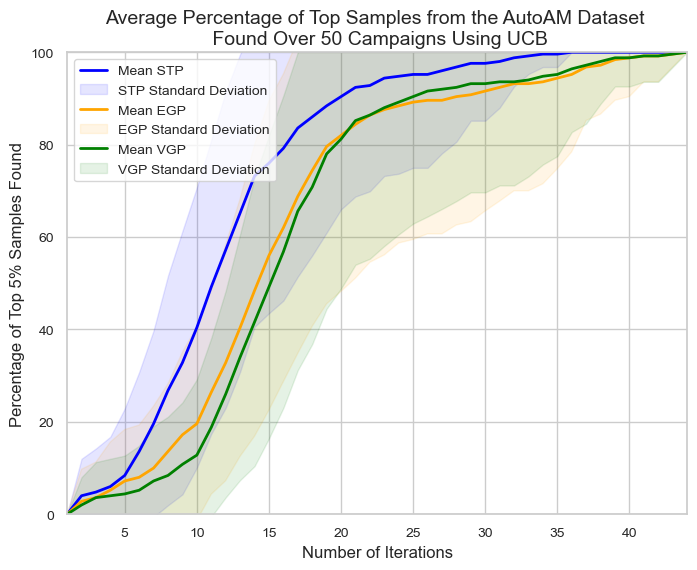

Starting P3HT
Number of samples: 230
Number of of top 5% samples: 12
Top 5% samples: [1243.67, 1089.12, 904.29, 852.33, 839.28, 838.31, 824.47, 804.11, 800.58, 788.8326479, 772.94, 770.35]


  0%|          | 0/50 [00:00<?, ?it/s]

Maximizing with EGP
Seed: 864
Initial points: tensor([[4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00],
        [9.6270e+01, 2.7000e-01, 2.0200e+00, 8.5000e-01, 5.1000e-01],
        [7.3990e+01, 5.0000e-01, 2.5180e+01, 2.8000e-01, 4.0000e-02],
        [4.7200e+01, 4.9490e+01, 2.0100e+00, 3.1000e-01, 1.0100e+00],
        [4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02]],
       dtype=torch.float64)


  2%|▏         | 1/50 [00:33<27:37, 33.82s/it]

Iterations 171
Maximizing with EGP
Seed: 394
Initial points: tensor([[5.4480e+01, 6.5000e-01, 5.3000e-01, 4.6000e-01, 4.3890e+01],
        [4.6570e+01, 4.8910e+01, 3.0800e+00, 1.1100e+00, 3.6000e-01],
        [5.1835e+01, 4.3805e+01, 1.8800e+00, 1.3800e+00, 1.1300e+00],
        [4.3490e+01, 4.6890e+01, 4.1800e+00, 5.1000e+00, 3.7000e-01],
        [7.3990e+01, 5.0000e-01, 2.5180e+01, 2.8000e-01, 4.0000e-02]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
  4%|▍         | 2/50 [01:06<26:42, 33.38s/it]

Iterations 166
Maximizing with EGP
Seed: 776
Initial points: tensor([[6.7100e+01, 3.0150e+01, 7.2000e-01, 4.0000e-02, 1.9500e+00],
        [1.6150e+01, 4.6000e-01, 2.5380e+01, 5.1420e+01, 6.5500e+00],
        [4.2300e+01, 4.5070e+01, 4.4900e+00, 5.2100e+00, 3.0200e+00],
        [4.5410e+01, 4.8510e+01, 2.1000e+00, 2.6400e+00, 1.3800e+00],
        [4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 85
Maximizing with EGP
Seed: 911
Initial points: tensor([[7.7730e+01, 2.0640e+01, 1.5800e+00, 4.0000e-02, 4.0000e-02],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00],
        [4.7130e+01, 4.6950e+01, 4.2800e+00, 1.0800e+00, 5.7000e-01],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00],
        [4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying origin

Iterations 179
Maximizing with EGP
Seed: 430
Initial points: tensor([[44.5700, 48.4700,  2.9300,  1.6000,  2.4000],
        [80.2600,  0.5300, 12.0300,  5.4700,  1.7800],
        [44.0100,  0.0900,  0.9000, 54.7100,  0.3000],
        [42.3300, 51.8300,  2.7500,  2.8700,  0.3200],
        [34.0100, 38.9000,  0.7300, 12.6800, 13.6500]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 10%|█         | 5/50 [02:35<23:42, 31.62s/it]

Iterations 145
Maximizing with EGP
Seed: 41
Initial points: tensor([[7.3990e+01, 5.0000e-01, 2.5180e+01, 2.8000e-01, 4.0000e-02],
        [6.6030e+01, 3.0010e+01, 2.6100e+00, 2.4000e-01, 1.0800e+00],
        [8.6410e+01, 2.2500e+00, 4.0000e-02, 1.8700e+00, 9.4500e+00],
        [4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00],
        [5.1835e+01, 4.3805e+01, 1.8800e+00, 1.3800e+00, 1.1300e+00]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 174
Maximizing with EGP
Seed: 265
Initial points: tensor([[42.4400,  1.1100,  1.4900, 54.0400,  0.9500],
        [40.0000, 60.0000,  0.0000,  0.0000,  0.0000],
        [39.0500, 41.8500,  5.7500,  4.0400,  9.4000],
        [16.1500,  0.4600, 25.3800, 51.4200,  6.5500],
        [90.0000, 10.0000,  0.0000,  0.0000,  0.0000]], dtype=torch.float64)


 14%|█▍        | 7/50 [03:43<23:41, 33.06s/it]

Iterations 171
Maximizing with EGP
Seed: 988
Initial points: tensor([[60.1000, 38.3900,  0.5500,  0.1100,  0.8600],
        [43.0900, 47.8500,  3.1400,  3.3000,  2.6700],
        [84.5700,  0.9000,  0.6900,  5.8400,  7.9800],
        [50.0000, 50.0000,  0.0000,  0.0000,  0.0000],
        [43.0900, 47.8500,  3.1400,  3.3000,  2.6700]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 174
Maximizing with EGP
Seed: 523
Initial points: tensor([[8.4860e+01, 3.4200e+00, 9.6000e-01, 2.8000e-01, 1.0410e+01],
        [9.0310e+01, 1.8000e-01, 6.2000e-01, 8.2500e+00, 6.5000e-01],
        [9.3110e+01, 3.0000e-02, 6.3000e-01, 3.7800e+00, 2.5000e+00],
        [9.0000e+01, 1.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 127
Maximizing with EGP
Seed: 497
Initial points: tensor([[1.9230e+01, 3.4000e-01, 4.5360e+01, 2.6030e+01, 9.0700e+00],
        [4.4550e+01, 5.0000e-01, 5.1550e+01, 1.1000e+00, 2.3100e+00],
        [4.7810e+01, 4.9290e+01, 5.5000e-01, 1.4600e+00, 8.9000e-01],
        [6.9100e+01, 3.0830e+01, 4.0000e-02, 4.0000e-02, 4.0000e-02],
        [8.5480e+01, 3.2000e-01, 1.5000e-01, 4.0300e+00, 9.9600e+00]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 20%|██        | 10/50 [05:36<23:42, 35.55s/it]

Iterations 171
Maximizing with EGP
Seed: 414
Initial points: tensor([[83.1700,  1.7200,  3.5400,  2.4300,  9.0700],
        [84.5500,  1.9300,  1.4000,  3.2300,  8.8500],
        [44.6100, 47.5300,  2.0500,  3.1700,  2.5800],
        [44.8000, 37.4000,  6.8100,  5.8300,  5.1800],
        [68.9400, 26.7900,  0.6900,  1.0300,  2.5700]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 22%|██▏       | 11/50 [06:16<23:56, 36.84s/it]

Iterations 176
Maximizing with EGP
Seed: 940
Initial points: tensor([[8.1710e+01, 4.3300e+00, 5.4400e+00, 8.5800e+00, 4.0000e-02],
        [4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00],
        [1.9230e+01, 3.4000e-01, 4.5360e+01, 2.6030e+01, 9.0700e+00],
        [4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02],
        [2.3855e+01, 4.9000e-01, 4.7670e+01, 2.5150e+01, 2.8400e+00]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 175
Maximizing with EGP
Seed: 802
Initial points: tensor([[9.1130e+01, 1.9900e+00, 1.9500e+00, 2.2400e+00, 2.6900e+00],
        [6.1930e+01, 3.0520e+01, 7.0500e+00, 2.0000e-01, 3.6000e-01],
        [9.1030e+01, 4.6000e-01, 1.9300e+00, 6.5900e+00, 4.0000e-02],
        [4.7200e+01, 4.9490e+01, 2.0100e+00, 3.1000e-01, 1.0100e+00],
        [5.0740e+01, 4.1050e+01, 1.6500e+00, 4.6900e+00, 1.8700e+00]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 26%|██▌       | 13/50 [07:28<22:12, 36.01s/it]

Iterations 132
Maximizing with EGP
Seed: 849
Initial points: tensor([[42.3300, 51.8300,  2.7500,  2.8700,  0.3200],
        [38.3300, 43.6000,  0.1000,  3.6300, 14.3000],
        [80.2600,  0.5300, 12.0300,  5.4700,  1.7800],
        [85.0800,  7.7500,  3.5000,  2.2400,  1.3600],
        [70.0000, 30.0000,  0.0000,  0.0000,  0.0000]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 123
Maximizing with EGP
Seed: 310
Initial points: tensor([[8.4600e+01, 7.5600e+00, 4.0000e-02, 7.8300e+00, 6.0000e-02],
        [3.4130e+01, 4.2190e+01, 8.7900e+00, 1.3220e+01, 1.6900e+00],
        [1.5000e+01, 0.0000e+00, 0.0000e+00, 8.5000e+01, 0.0000e+00],
        [5.8620e+01, 3.9890e+01, 4.0000e-02, 1.3200e+00, 1.4000e-01],
        [8.4090e+01, 1.8500e+00, 6.5000e-01, 2.3600e+00, 1.1140e+01]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 127
Maximizing with EGP
Seed: 991
Initial points: tensor([[3.9610e+01, 4.8070e+01, 7.5100e+00, 1.9300e+00, 2.9400e+00],
        [4.8970e+01, 5.0340e+01, 4.0000e-02, 1.0000e-01, 5.6000e-01],
        [8.6600e+01, 1.1000e+00, 2.8000e-01, 2.4200e+00, 9.5400e+00],
        [4.5000e+01, 0.0000e+00, 5.5000e+01, 0.0000e+00, 0.0000e+00],
        [4.1600e+01, 5.1430e+01, 2.1000e+00, 4.9100e+00, 4.0000e-02]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 179
Maximizing with EGP
Seed: 488
Initial points: tensor([[8.2980e+01, 8.0400e+00, 4.7900e+00, 2.5800e+00, 1.5100e+00],
        [4.3170e+01, 3.4010e+01, 3.8900e+00, 2.0400e+00, 1.6960e+01],
        [9.4810e+01, 3.0000e-01, 2.8000e-01, 8.0000e-02, 4.5300e+00],
        [5.5340e+01, 3.8120e+01, 6.2700e+00, 1.0000e-02, 2.6000e-01],
        [4.6860e+01, 4.3740e+01, 5.0800e+00, 7.8000e-01, 3.6100e+00]],
       dtype=torch.float64)


 34%|███▍      | 17/50 [09:52<20:33, 37.39s/it]

Iterations 178
Maximizing with EGP
Seed: 366
Initial points: tensor([[44.8000, 37.4000,  6.8100,  5.8300,  5.1800],
        [20.5700,  0.1800, 35.6000, 39.4100,  4.1600],
        [44.5700, 48.4700,  2.9300,  1.6000,  2.4000],
        [55.3200, 37.0400,  1.9000,  2.3200,  3.4400],
        [44.3500,  0.1800, 54.4700,  0.1800,  0.8100]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 157
Maximizing with EGP
Seed: 597
Initial points: tensor([[34.9600, 44.3200,  1.8000, 14.0100,  4.9600],
        [46.5100, 49.5100,  2.0600,  1.0600,  0.8900],
        [39.6100, 48.0700,  7.5100,  1.9300,  2.9400],
        [45.8000, 47.2500,  3.2400,  2.7000,  1.1000],
        [39.0500, 41.8500,  5.7500,  4.0400,  9.4000]], dtype=torch.float64)


 38%|███▊      | 19/50 [11:06<19:13, 37.21s/it]

Iterations 174
Maximizing with EGP
Seed: 913
Initial points: tensor([[5.3400e+01, 3.3900e+01, 1.1800e+00, 1.1340e+01, 2.5000e-01],
        [8.4550e+01, 1.9300e+00, 1.4000e+00, 3.2300e+00, 8.8500e+00],
        [4.3800e+01, 4.5290e+01, 7.8900e+00, 2.4300e+00, 5.5000e-01],
        [5.8760e+01, 3.9810e+01, 7.5000e-01, 1.5000e-01, 5.3000e-01],
        [4.8970e+01, 5.0340e+01, 4.0000e-02, 1.0000e-01, 5.6000e-01]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 131
Maximizing with EGP
Seed: 929
Initial points: tensor([[91.1300,  1.9900,  1.9500,  2.2400,  2.6900],
        [49.5100, 49.2400,  0.6200,  0.1200,  0.5600],
        [46.5700, 48.9100,  3.0800,  1.1100,  0.3600],
        [25.0000,  0.0000,  0.0000,  0.0000, 75.0000],
        [60.1000, 38.3900,  0.5500,  0.1100,  0.8600]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 42%|████▏     | 21/50 [12:11<17:05, 35.36s/it]

Iterations 167
Maximizing with EGP
Seed: 223
Initial points: tensor([[88.4500,  3.5000,  1.8900,  1.9600,  4.2100],
        [90.0000, 10.0000,  0.0000,  0.0000,  0.0000],
        [42.3000, 45.0700,  4.4900,  5.2100,  3.0200],
        [16.1500,  0.4600, 25.3800, 51.4200,  6.5500],
        [80.2600,  0.5300, 12.0300,  5.4700,  1.7800]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 145
Maximizing with EGP
Seed: 516
Initial points: tensor([[44.6100, 47.5300,  2.0500,  3.1700,  2.5800],
        [84.5500,  1.9300,  1.4000,  3.2300,  8.8500],
        [82.9800,  8.0400,  4.7900,  2.5800,  1.5100],
        [70.1400, 27.1800,  1.4500,  0.2700,  0.9700],
        [45.8000, 47.2500,  3.2400,  2.7000,  1.1000]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 145
Maximizing with EGP
Seed: 142
Initial points: tensor([[4.9720e+01, 4.8060e+01, 1.1100e+00, 8.9000e-01, 2.3000e-01],
        [6.8110e+01, 2.8690e+01, 8.9000e-01, 9.7000e-01, 1.3500e+00],
        [6.0000e+01, 0.0000e+00, 0.0000e+00, 4.0000e+01, 0.0000e+00],
        [4.1900e+01, 4.8610e+01, 3.7800e+00, 1.8700e+00, 3.8300e+00],
        [7.3990e+01, 5.0000e-01, 2.5180e+01, 2.8000e-01, 4.0000e-02]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 145
Maximizing with EGP
Seed: 288
Initial points: tensor([[5.1810e+01, 3.9100e+01, 5.1500e+00, 7.8000e-01, 3.1400e+00],
        [6.9100e+01, 3.0830e+01, 4.0000e-02, 4.0000e-02, 4.0000e-02],
        [4.7130e+01, 4.6950e+01, 4.2800e+00, 1.0800e+00, 5.7000e-01],
        [5.5340e+01, 3.8120e+01, 6.2700e+00, 1.0000e-02, 2.6000e-01],
        [4.0000e+01, 6.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 50%|█████     | 25/50 [14:27<14:12, 34.08s/it]

Iterations 140
Maximizing with EGP
Seed: 143
Initial points: tensor([[4.8680e+01, 3.9720e+01, 1.0970e+01, 5.8000e-01, 4.0000e-02],
        [6.0340e+01, 2.6070e+01, 6.5000e+00, 2.3100e+00, 4.8700e+00],
        [4.5580e+01, 4.9520e+01, 2.5900e+00, 4.9000e-01, 1.8900e+00],
        [4.4300e+01, 5.4680e+01, 4.0000e-02, 2.9000e-01, 7.8000e-01],
        [5.0740e+01, 4.1050e+01, 1.6500e+00, 4.6900e+00, 1.8700e+00]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 52%|█████▏    | 26/50 [14:53<12:42, 31.78s/it]

Iterations 108
Maximizing with EGP
Seed: 773
Initial points: tensor([[47.2600, 44.4600,  7.3200,  0.6900,  0.2300],
        [50.7000, 37.8800,  4.0500,  3.3700,  4.0500],
        [60.0000, 40.0000,  0.0000,  0.0000,  0.0000],
        [51.7300, 32.1200,  3.9200,  2.2900,  9.9600],
        [34.0100, 38.9000,  0.7300, 12.6800, 13.6500]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 159
Maximizing with EGP
Seed: 97
Initial points: tensor([[7.4310e+01, 3.9000e-01, 1.0000e-01, 2.5180e+01, 4.0000e-02],
        [5.0350e+01, 4.0600e+01, 5.3700e+00, 2.4400e+00, 1.2600e+00],
        [1.6880e+01, 1.2500e+00, 2.4960e+01, 4.9580e+01, 7.3200e+00],
        [4.3110e+01, 5.3000e-01, 5.3450e+01, 5.1000e-01, 2.3600e+00],
        [9.6270e+01, 2.7000e-01, 2.0200e+00, 8.5000e-01, 5.1000e-01]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 56%|█████▌    | 28/50 [16:04<12:19, 33.63s/it]

Iterations 145
Maximizing with EGP
Seed: 633
Initial points: tensor([[3.8920e+01, 4.9280e+01, 9.0000e-02, 9.5000e-01, 1.0670e+01],
        [1.8730e+01, 1.2800e+00, 4.7460e+01, 2.4640e+01, 7.9400e+00],
        [9.0000e+01, 0.0000e+00, 0.0000e+00, 1.0000e+01, 0.0000e+00],
        [4.8720e+01, 4.9780e+01, 4.5000e-01, 8.3000e-01, 2.3000e-01],
        [9.1030e+01, 4.6000e-01, 1.9300e+00, 6.5900e+00, 4.0000e-02]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 58%|█████▊    | 29/50 [16:43<12:20, 35.26s/it]

Iterations 176
Maximizing with EGP
Seed: 818
Initial points: tensor([[90.3100,  0.1800,  0.6200,  8.2500,  0.6500],
        [84.0900,  1.8500,  0.6500,  2.3600, 11.1400],
        [59.8200,  0.2300,  0.5000, 38.8900,  0.5500],
        [82.2800,  2.4300,  2.9700,  3.5600,  8.7200],
        [83.1700,  1.7200,  3.5400,  2.4300,  9.0700]], dtype=torch.float64)


 60%|██████    | 30/50 [17:20<11:54, 35.71s/it]

Iterations 176
Maximizing with EGP
Seed: 256
Initial points: tensor([[48.7200, 49.7800,  0.4500,  0.8300,  0.2300],
        [46.0500, 49.9000,  2.2200,  0.7700,  1.0900],
        [90.4800,  4.8200,  2.6100,  0.5500,  1.5700],
        [84.0900,  1.8500,  0.6500,  2.3600, 11.1400],
        [40.0000, 60.0000,  0.0000,  0.0000,  0.0000]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 62%|██████▏   | 31/50 [17:52<10:57, 34.59s/it]

Iterations 155
Maximizing with EGP
Seed: 931
Initial points: tensor([[5.1835e+01, 4.3805e+01, 1.8800e+00, 1.3800e+00, 1.1300e+00],
        [9.1130e+01, 1.9900e+00, 1.9500e+00, 2.2400e+00, 2.6900e+00],
        [3.8380e+01, 4.8280e+01, 4.0000e-02, 5.7000e-01, 1.2710e+01],
        [4.5000e+01, 0.0000e+00, 0.0000e+00, 5.5000e+01, 0.0000e+00],
        [4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 64%|██████▍   | 32/50 [18:25<10:13, 34.07s/it]

Iterations 141
Maximizing with EGP
Seed: 545
Initial points: tensor([[60.0000,  0.0000,  0.0000, 40.0000,  0.0000],
        [89.8000,  3.0100,  1.5900,  4.3600,  1.2300],
        [41.2300, 49.0600,  3.4100,  6.1700,  0.1400],
        [91.1300,  1.9900,  1.9500,  2.2400,  2.6900],
        [45.1500, 42.2500,  7.8200,  1.9800,  2.8300]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 66%|██████▌   | 33/50 [18:55<09:19, 32.88s/it]

Iterations 142
Maximizing with EGP
Seed: 722
Initial points: tensor([[4.8620e+01, 5.0350e+01, 4.9000e-01, 5.3000e-01, 4.0000e-02],
        [3.0000e+01, 0.0000e+00, 0.0000e+00, 7.0000e+01, 0.0000e+00],
        [4.3170e+01, 3.4010e+01, 3.8900e+00, 2.0400e+00, 1.6960e+01],
        [5.4480e+01, 6.5000e-01, 5.3000e-01, 4.6000e-01, 4.3890e+01],
        [8.4600e+01, 7.5600e+00, 4.0000e-02, 7.8300e+00, 6.0000e-02]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 132
Maximizing with EGP
Seed: 829
Initial points: tensor([[5.0000e+01, 5.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.4800e+01, 3.7400e+01, 6.8100e+00, 5.8300e+00, 5.1800e+00],
        [4.4010e+01, 9.0000e-02, 9.0000e-01, 5.4710e+01, 3.0000e-01],
        [9.1130e+01, 1.9900e+00, 1.9500e+00, 2.2400e+00, 2.6900e+00],
        [4.8620e+01, 5.0350e+01, 4.9000e-01, 5.3000e-01, 4.0000e-02]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 70%|███████   | 35/50 [20:03<08:26, 33.73s/it]

Iterations 163
Maximizing with EGP
Seed: 616
Initial points: tensor([[8.4230e+01, 1.0600e+00, 1.1300e+00, 4.3400e+00, 9.1500e+00],
        [4.3110e+01, 5.3000e-01, 5.3450e+01, 5.1000e-01, 2.3600e+00],
        [4.4610e+01, 4.7530e+01, 2.0500e+00, 3.1700e+00, 2.5800e+00],
        [4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02],
        [4.5210e+01, 4.9390e+01, 3.5900e+00, 1.4500e+00, 4.1000e-01]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 72%|███████▏  | 36/50 [20:29<07:21, 31.51s/it]

Iterations 126
Maximizing with EGP
Seed: 923
Initial points: tensor([[89.5500,  5.7200,  0.8300,  1.8000,  2.1000],
        [46.4400, 49.2300,  1.6600,  1.7000,  1.0600],
        [90.0000, 10.0000,  0.0000,  0.0000,  0.0000],
        [40.0000, 60.0000,  0.0000,  0.0000,  0.0000],
        [88.4500,  3.5000,  1.8900,  1.9600,  4.2100]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 145
Maximizing with EGP
Seed: 150
Initial points: tensor([[8.5380e+01, 1.6600e+00, 1.4500e+00, 1.1000e+00, 1.0480e+01],
        [4.8620e+01, 5.0350e+01, 4.9000e-01, 5.3000e-01, 4.0000e-02],
        [4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02],
        [1.8670e+01, 2.7000e-01, 4.7090e+01, 2.4030e+01, 9.9900e+00],
        [4.3830e+01, 3.6370e+01, 9.9000e-01, 2.4400e+00, 1.6400e+01]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 153
Maximizing with EGP
Seed: 317
Initial points: tensor([[4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02],
        [3.4010e+01, 3.8900e+01, 7.3000e-01, 1.2680e+01, 1.3650e+01],
        [4.6690e+01, 3.7390e+01, 4.0000e-02, 1.8600e+00, 1.4050e+01],
        [3.8330e+01, 4.3600e+01, 1.0000e-01, 3.6300e+00, 1.4300e+01],
        [4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 78%|███████▊  | 39/50 [22:28<06:49, 37.19s/it]

Iterations 165
Maximizing with EGP
Seed: 101
Initial points: tensor([[89.8000,  3.0100,  1.5900,  4.3600,  1.2300],
        [86.6000,  1.1000,  0.2800,  2.4200,  9.5400],
        [38.3300, 43.6000,  0.1000,  3.6300, 14.3000],
        [42.3300, 51.8300,  2.7500,  2.8700,  0.3200],
        [90.3100,  0.1800,  0.6200,  8.2500,  0.6500]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 156
Maximizing with EGP
Seed: 747
Initial points: tensor([[30.0000,  0.0000, 70.0000,  0.0000,  0.0000],
        [19.1500,  1.5900, 48.4000, 23.3300,  7.5700],
        [44.5700, 48.4700,  2.9300,  1.6000,  2.4000],
        [49.5100, 49.2400,  0.6200,  0.1200,  0.5600],
        [60.3400, 26.0700,  6.5000,  2.3100,  4.8700]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 115
Maximizing with EGP
Seed: 75
Initial points: tensor([[4.0000e+01, 6.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00],
        [4.6860e+01, 4.3740e+01, 5.0800e+00, 7.8000e-01, 3.6100e+00],
        [5.0650e+01, 4.4590e+01, 4.0600e+00, 4.0000e-02, 6.9000e-01],
        [4.5600e+01, 4.6500e+01, 1.6700e+00, 3.9600e+00, 2.2600e+00]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 150
Maximizing with EGP
Seed: 920
Initial points: tensor([[7.4310e+01, 3.9000e-01, 1.0000e-01, 2.5180e+01, 4.0000e-02],
        [4.8620e+01, 5.0350e+01, 4.9000e-01, 5.3000e-01, 4.0000e-02],
        [4.0000e+01, 6.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.8970e+01, 5.0340e+01, 4.0000e-02, 1.0000e-01, 5.6000e-01],
        [4.6050e+01, 4.9900e+01, 2.2200e+00, 7.7000e-01, 1.0900e+00]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 86%|████████▌ | 43/50 [24:49<04:15, 36.56s/it]

Iterations 174
Maximizing with EGP
Seed: 870
Initial points: tensor([[6.9100e+01, 3.0830e+01, 4.0000e-02, 4.0000e-02, 4.0000e-02],
        [3.9050e+01, 4.1850e+01, 5.7500e+00, 4.0400e+00, 9.4000e+00],
        [9.0300e+01, 2.0000e-01, 7.8900e+00, 7.9000e-01, 8.9000e-01],
        [4.8720e+01, 4.9780e+01, 4.5000e-01, 8.3000e-01, 2.3000e-01],
        [7.4190e+01, 7.0000e-02, 2.4760e+01, 1.7000e-01, 8.0000e-01]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 144
Maximizing with EGP
Seed: 700
Initial points: tensor([[18.6700,  0.2700, 47.0900, 24.0300,  9.9900],
        [38.2900, 47.3700,  0.9500,  0.6000, 12.8700],
        [96.2700,  0.2700,  2.0200,  0.8500,  0.5100],
        [50.7000, 37.8800,  4.0500,  3.3700,  4.0500],
        [50.3500, 40.6000,  5.3700,  2.4400,  1.2600]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 90%|█████████ | 45/50 [26:06<03:07, 37.60s/it]

Iterations 178
Maximizing with EGP
Seed: 338
Initial points: tensor([[46.8600, 43.7400,  5.0800,  0.7800,  3.6100],
        [45.6400, 48.8600,  2.6400,  1.7800,  1.0900],
        [34.0100, 38.9000,  0.7300, 12.6800, 13.6500],
        [46.5700, 48.9100,  3.0800,  1.1100,  0.3600],
        [74.8800,  0.0800,  2.0200, 22.0100,  1.0300]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 173
Maximizing with EGP
Seed: 483
Initial points: tensor([[4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02],
        [5.3990e+01, 4.4580e+01, 4.0000e-02, 5.4000e-01, 8.9000e-01],
        [6.0000e+01, 0.0000e+00, 0.0000e+00, 4.0000e+01, 0.0000e+00],
        [8.9800e+01, 3.0100e+00, 1.5900e+00, 4.3600e+00, 1.2300e+00],
        [4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 94%|█████████▍| 47/50 [27:11<01:43, 34.66s/it]

Iterations 123
Maximizing with EGP
Seed: 573
Initial points: tensor([[39.0500, 41.8500,  5.7500,  4.0400,  9.4000],
        [50.7400, 41.0500,  1.6500,  4.6900,  1.8700],
        [49.5100, 49.2400,  0.6200,  0.1200,  0.5600],
        [40.0000, 60.0000,  0.0000,  0.0000,  0.0000],
        [18.7300,  1.2800, 47.4600, 24.6400,  7.9400]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 96%|█████████▌| 48/50 [27:48<01:10, 35.41s/it]

Iterations 169
Maximizing with EGP
Seed: 103
Initial points: tensor([[3.8330e+01, 4.3600e+01, 1.0000e-01, 3.6300e+00, 1.4300e+01],
        [1.9130e+01, 4.0000e-01, 4.6860e+01, 2.5410e+01, 8.2500e+00],
        [7.4880e+01, 8.0000e-02, 2.0200e+00, 2.2010e+01, 1.0300e+00],
        [6.7100e+01, 3.0150e+01, 7.2000e-01, 4.0000e-02, 1.9500e+00],
        [4.7200e+01, 4.9490e+01, 2.0100e+00, 3.1000e-01, 1.0100e+00]],
       dtype=torch.float64)


 98%|█████████▊| 49/50 [28:24<00:35, 35.59s/it]

Iterations 177
Maximizing with EGP
Seed: 362
Initial points: tensor([[9.6270e+01, 2.7000e-01, 2.0200e+00, 8.5000e-01, 5.1000e-01],
        [6.9100e+01, 3.0830e+01, 4.0000e-02, 4.0000e-02, 4.0000e-02],
        [3.7290e+01, 4.3200e+01, 2.7700e+00, 1.8100e+00, 1.4940e+01],
        [4.8330e+01, 5.0130e+01, 1.3200e+00, 2.2000e-01, 4.0000e-02],
        [4.5000e+01, 0.0000e+00, 5.5000e+01, 0.0000e+00, 0.0000e+00]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 180


  0%|          | 0/50 [00:00<?, ?it/s]

Maximizing with STP
Seed: 864
Initial points: tensor([[4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00],
        [9.6270e+01, 2.7000e-01, 2.0200e+00, 8.5000e-01, 5.1000e-01],
        [7.3990e+01, 5.0000e-01, 2.5180e+01, 2.8000e-01, 4.0000e-02],
        [4.7200e+01, 4.9490e+01, 2.0100e+00, 3.1000e-01, 1.0100e+00],
        [4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02]],
       dtype=torch.float64)


  2%|▏         | 1/50 [00:46<37:58, 46.51s/it]

Iterations 62
Maximizing with STP
Seed: 394
Initial points: tensor([[5.4480e+01, 6.5000e-01, 5.3000e-01, 4.6000e-01, 4.3890e+01],
        [4.6570e+01, 4.8910e+01, 3.0800e+00, 1.1100e+00, 3.6000e-01],
        [5.1835e+01, 4.3805e+01, 1.8800e+00, 1.3800e+00, 1.1300e+00],
        [4.3490e+01, 4.6890e+01, 4.1800e+00, 5.1000e+00, 3.7000e-01],
        [7.3990e+01, 5.0000e-01, 2.5180e+01, 2.8000e-01, 4.0000e-02]],
       dtype=torch.float64)


  4%|▍         | 2/50 [01:55<47:36, 59.51s/it]

Iterations 87
Maximizing with STP
Seed: 776
Initial points: tensor([[6.7100e+01, 3.0150e+01, 7.2000e-01, 4.0000e-02, 1.9500e+00],
        [1.6150e+01, 4.6000e-01, 2.5380e+01, 5.1420e+01, 6.5500e+00],
        [4.2300e+01, 4.5070e+01, 4.4900e+00, 5.2100e+00, 3.0200e+00],
        [4.5410e+01, 4.8510e+01, 2.1000e+00, 2.6400e+00, 1.3800e+00],
        [4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02]],
       dtype=torch.float64)


  6%|▌         | 3/50 [02:29<37:27, 47.81s/it]

Iterations 45
Maximizing with STP
Seed: 911
Initial points: tensor([[7.7730e+01, 2.0640e+01, 1.5800e+00, 4.0000e-02, 4.0000e-02],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00],
        [4.7130e+01, 4.6950e+01, 4.2800e+00, 1.0800e+00, 5.7000e-01],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00],
        [4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02]],
       dtype=torch.float64)


  8%|▊         | 4/50 [03:08<34:00, 44.36s/it]

Iterations 51
Maximizing with STP
Seed: 430
Initial points: tensor([[44.5700, 48.4700,  2.9300,  1.6000,  2.4000],
        [80.2600,  0.5300, 12.0300,  5.4700,  1.7800],
        [44.0100,  0.0900,  0.9000, 54.7100,  0.3000],
        [42.3300, 51.8300,  2.7500,  2.8700,  0.3200],
        [34.0100, 38.9000,  0.7300, 12.6800, 13.6500]], dtype=torch.float64)


 10%|█         | 5/50 [03:57<34:44, 46.33s/it]

Iterations 65
Maximizing with STP
Seed: 41
Initial points: tensor([[7.3990e+01, 5.0000e-01, 2.5180e+01, 2.8000e-01, 4.0000e-02],
        [6.6030e+01, 3.0010e+01, 2.6100e+00, 2.4000e-01, 1.0800e+00],
        [8.6410e+01, 2.2500e+00, 4.0000e-02, 1.8700e+00, 9.4500e+00],
        [4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00],
        [5.1835e+01, 4.3805e+01, 1.8800e+00, 1.3800e+00, 1.1300e+00]],
       dtype=torch.float64)


 12%|█▏        | 6/50 [05:02<38:30, 52.52s/it]

Iterations 83
Maximizing with STP
Seed: 265
Initial points: tensor([[42.4400,  1.1100,  1.4900, 54.0400,  0.9500],
        [40.0000, 60.0000,  0.0000,  0.0000,  0.0000],
        [39.0500, 41.8500,  5.7500,  4.0400,  9.4000],
        [16.1500,  0.4600, 25.3800, 51.4200,  6.5500],
        [90.0000, 10.0000,  0.0000,  0.0000,  0.0000]], dtype=torch.float64)


 14%|█▍        | 7/50 [05:46<35:42, 49.84s/it]

Iterations 57
Maximizing with STP
Seed: 988
Initial points: tensor([[60.1000, 38.3900,  0.5500,  0.1100,  0.8600],
        [43.0900, 47.8500,  3.1400,  3.3000,  2.6700],
        [84.5700,  0.9000,  0.6900,  5.8400,  7.9800],
        [50.0000, 50.0000,  0.0000,  0.0000,  0.0000],
        [43.0900, 47.8500,  3.1400,  3.3000,  2.6700]], dtype=torch.float64)


 16%|█▌        | 8/50 [06:46<37:05, 52.98s/it]

Iterations 78
Maximizing with STP
Seed: 523
Initial points: tensor([[8.4860e+01, 3.4200e+00, 9.6000e-01, 2.8000e-01, 1.0410e+01],
        [9.0310e+01, 1.8000e-01, 6.2000e-01, 8.2500e+00, 6.5000e-01],
        [9.3110e+01, 3.0000e-02, 6.3000e-01, 3.7800e+00, 2.5000e+00],
        [9.0000e+01, 1.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00]],
       dtype=torch.float64)


 18%|█▊        | 9/50 [07:20<32:03, 46.91s/it]

Iterations 44
Maximizing with STP
Seed: 497
Initial points: tensor([[1.9230e+01, 3.4000e-01, 4.5360e+01, 2.6030e+01, 9.0700e+00],
        [4.4550e+01, 5.0000e-01, 5.1550e+01, 1.1000e+00, 2.3100e+00],
        [4.7810e+01, 4.9290e+01, 5.5000e-01, 1.4600e+00, 8.9000e-01],
        [6.9100e+01, 3.0830e+01, 4.0000e-02, 4.0000e-02, 4.0000e-02],
        [8.5480e+01, 3.2000e-01, 1.5000e-01, 4.0300e+00, 9.9600e+00]],
       dtype=torch.float64)


 20%|██        | 10/50 [08:27<35:32, 53.31s/it]

Iterations 87
Maximizing with STP
Seed: 414
Initial points: tensor([[83.1700,  1.7200,  3.5400,  2.4300,  9.0700],
        [84.5500,  1.9300,  1.4000,  3.2300,  8.8500],
        [44.6100, 47.5300,  2.0500,  3.1700,  2.5800],
        [44.8000, 37.4000,  6.8100,  5.8300,  5.1800],
        [68.9400, 26.7900,  0.6900,  1.0300,  2.5700]], dtype=torch.float64)


 22%|██▏       | 11/50 [09:01<30:44, 47.29s/it]

Iterations 44
Maximizing with STP
Seed: 940
Initial points: tensor([[8.1710e+01, 4.3300e+00, 5.4400e+00, 8.5800e+00, 4.0000e-02],
        [4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00],
        [1.9230e+01, 3.4000e-01, 4.5360e+01, 2.6030e+01, 9.0700e+00],
        [4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02],
        [2.3855e+01, 4.9000e-01, 4.7670e+01, 2.5150e+01, 2.8400e+00]],
       dtype=torch.float64)


 24%|██▍       | 12/50 [09:49<30:12, 47.70s/it]

Iterations 63
Maximizing with STP
Seed: 802
Initial points: tensor([[9.1130e+01, 1.9900e+00, 1.9500e+00, 2.2400e+00, 2.6900e+00],
        [6.1930e+01, 3.0520e+01, 7.0500e+00, 2.0000e-01, 3.6000e-01],
        [9.1030e+01, 4.6000e-01, 1.9300e+00, 6.5900e+00, 4.0000e-02],
        [4.7200e+01, 4.9490e+01, 2.0100e+00, 3.1000e-01, 1.0100e+00],
        [5.0740e+01, 4.1050e+01, 1.6500e+00, 4.6900e+00, 1.8700e+00]],
       dtype=torch.float64)


 26%|██▌       | 13/50 [10:49<31:42, 51.43s/it]

Iterations 77
Maximizing with STP
Seed: 849
Initial points: tensor([[42.3300, 51.8300,  2.7500,  2.8700,  0.3200],
        [38.3300, 43.6000,  0.1000,  3.6300, 14.3000],
        [80.2600,  0.5300, 12.0300,  5.4700,  1.7800],
        [85.0800,  7.7500,  3.5000,  2.2400,  1.3600],
        [70.0000, 30.0000,  0.0000,  0.0000,  0.0000]], dtype=torch.float64)


 28%|██▊       | 14/50 [11:26<28:12, 47.00s/it]

Iterations 48
Maximizing with STP
Seed: 310
Initial points: tensor([[8.4600e+01, 7.5600e+00, 4.0000e-02, 7.8300e+00, 6.0000e-02],
        [3.4130e+01, 4.2190e+01, 8.7900e+00, 1.3220e+01, 1.6900e+00],
        [1.5000e+01, 0.0000e+00, 0.0000e+00, 8.5000e+01, 0.0000e+00],
        [5.8620e+01, 3.9890e+01, 4.0000e-02, 1.3200e+00, 1.4000e-01],
        [8.4090e+01, 1.8500e+00, 6.5000e-01, 2.3600e+00, 1.1140e+01]],
       dtype=torch.float64)


 30%|███       | 15/50 [12:16<27:58, 47.96s/it]

Iterations 65
Maximizing with STP
Seed: 991
Initial points: tensor([[3.9610e+01, 4.8070e+01, 7.5100e+00, 1.9300e+00, 2.9400e+00],
        [4.8970e+01, 5.0340e+01, 4.0000e-02, 1.0000e-01, 5.6000e-01],
        [8.6600e+01, 1.1000e+00, 2.8000e-01, 2.4200e+00, 9.5400e+00],
        [4.5000e+01, 0.0000e+00, 5.5000e+01, 0.0000e+00, 0.0000e+00],
        [4.1600e+01, 5.1430e+01, 2.1000e+00, 4.9100e+00, 4.0000e-02]],
       dtype=torch.float64)


 32%|███▏      | 16/50 [13:40<33:17, 58.75s/it]

Iterations 106
Maximizing with STP
Seed: 488
Initial points: tensor([[8.2980e+01, 8.0400e+00, 4.7900e+00, 2.5800e+00, 1.5100e+00],
        [4.3170e+01, 3.4010e+01, 3.8900e+00, 2.0400e+00, 1.6960e+01],
        [9.4810e+01, 3.0000e-01, 2.8000e-01, 8.0000e-02, 4.5300e+00],
        [5.5340e+01, 3.8120e+01, 6.2700e+00, 1.0000e-02, 2.6000e-01],
        [4.6860e+01, 4.3740e+01, 5.0800e+00, 7.8000e-01, 3.6100e+00]],
       dtype=torch.float64)


 34%|███▍      | 17/50 [14:16<28:30, 51.84s/it]

Iterations 47
Maximizing with STP
Seed: 366
Initial points: tensor([[44.8000, 37.4000,  6.8100,  5.8300,  5.1800],
        [20.5700,  0.1800, 35.6000, 39.4100,  4.1600],
        [44.5700, 48.4700,  2.9300,  1.6000,  2.4000],
        [55.3200, 37.0400,  1.9000,  2.3200,  3.4400],
        [44.3500,  0.1800, 54.4700,  0.1800,  0.8100]], dtype=torch.float64)


 36%|███▌      | 18/50 [15:01<26:32, 49.77s/it]

Iterations 58
Maximizing with STP
Seed: 597
Initial points: tensor([[34.9600, 44.3200,  1.8000, 14.0100,  4.9600],
        [46.5100, 49.5100,  2.0600,  1.0600,  0.8900],
        [39.6100, 48.0700,  7.5100,  1.9300,  2.9400],
        [45.8000, 47.2500,  3.2400,  2.7000,  1.1000],
        [39.0500, 41.8500,  5.7500,  4.0400,  9.4000]], dtype=torch.float64)


 38%|███▊      | 19/50 [15:54<26:12, 50.74s/it]

Iterations 68
Maximizing with STP
Seed: 913
Initial points: tensor([[5.3400e+01, 3.3900e+01, 1.1800e+00, 1.1340e+01, 2.5000e-01],
        [8.4550e+01, 1.9300e+00, 1.4000e+00, 3.2300e+00, 8.8500e+00],
        [4.3800e+01, 4.5290e+01, 7.8900e+00, 2.4300e+00, 5.5000e-01],
        [5.8760e+01, 3.9810e+01, 7.5000e-01, 1.5000e-01, 5.3000e-01],
        [4.8970e+01, 5.0340e+01, 4.0000e-02, 1.0000e-01, 5.6000e-01]],
       dtype=torch.float64)


 40%|████      | 20/50 [16:57<27:16, 54.55s/it]

Iterations 82
Maximizing with STP
Seed: 929
Initial points: tensor([[91.1300,  1.9900,  1.9500,  2.2400,  2.6900],
        [49.5100, 49.2400,  0.6200,  0.1200,  0.5600],
        [46.5700, 48.9100,  3.0800,  1.1100,  0.3600],
        [25.0000,  0.0000,  0.0000,  0.0000, 75.0000],
        [60.1000, 38.3900,  0.5500,  0.1100,  0.8600]], dtype=torch.float64)


 42%|████▏     | 21/50 [17:41<24:45, 51.23s/it]

Iterations 57
Maximizing with STP
Seed: 223
Initial points: tensor([[88.4500,  3.5000,  1.8900,  1.9600,  4.2100],
        [90.0000, 10.0000,  0.0000,  0.0000,  0.0000],
        [42.3000, 45.0700,  4.4900,  5.2100,  3.0200],
        [16.1500,  0.4600, 25.3800, 51.4200,  6.5500],
        [80.2600,  0.5300, 12.0300,  5.4700,  1.7800]], dtype=torch.float64)


 44%|████▍     | 22/50 [18:09<20:39, 44.27s/it]

Iterations 37
Maximizing with STP
Seed: 516
Initial points: tensor([[44.6100, 47.5300,  2.0500,  3.1700,  2.5800],
        [84.5500,  1.9300,  1.4000,  3.2300,  8.8500],
        [82.9800,  8.0400,  4.7900,  2.5800,  1.5100],
        [70.1400, 27.1800,  1.4500,  0.2700,  0.9700],
        [45.8000, 47.2500,  3.2400,  2.7000,  1.1000]], dtype=torch.float64)


 46%|████▌     | 23/50 [18:54<20:05, 44.66s/it]

Iterations 60
Maximizing with STP
Seed: 142
Initial points: tensor([[4.9720e+01, 4.8060e+01, 1.1100e+00, 8.9000e-01, 2.3000e-01],
        [6.8110e+01, 2.8690e+01, 8.9000e-01, 9.7000e-01, 1.3500e+00],
        [6.0000e+01, 0.0000e+00, 0.0000e+00, 4.0000e+01, 0.0000e+00],
        [4.1900e+01, 4.8610e+01, 3.7800e+00, 1.8700e+00, 3.8300e+00],
        [7.3990e+01, 5.0000e-01, 2.5180e+01, 2.8000e-01, 4.0000e-02]],
       dtype=torch.float64)


 48%|████▊     | 24/50 [19:58<21:51, 50.45s/it]

Iterations 82
Maximizing with STP
Seed: 288
Initial points: tensor([[5.1810e+01, 3.9100e+01, 5.1500e+00, 7.8000e-01, 3.1400e+00],
        [6.9100e+01, 3.0830e+01, 4.0000e-02, 4.0000e-02, 4.0000e-02],
        [4.7130e+01, 4.6950e+01, 4.2800e+00, 1.0800e+00, 5.7000e-01],
        [5.5340e+01, 3.8120e+01, 6.2700e+00, 1.0000e-02, 2.6000e-01],
        [4.0000e+01, 6.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00]],
       dtype=torch.float64)


 50%|█████     | 25/50 [20:39<19:44, 47.36s/it]

Iterations 52
Maximizing with STP
Seed: 143
Initial points: tensor([[4.8680e+01, 3.9720e+01, 1.0970e+01, 5.8000e-01, 4.0000e-02],
        [6.0340e+01, 2.6070e+01, 6.5000e+00, 2.3100e+00, 4.8700e+00],
        [4.5580e+01, 4.9520e+01, 2.5900e+00, 4.9000e-01, 1.8900e+00],
        [4.4300e+01, 5.4680e+01, 4.0000e-02, 2.9000e-01, 7.8000e-01],
        [5.0740e+01, 4.1050e+01, 1.6500e+00, 4.6900e+00, 1.8700e+00]],
       dtype=torch.float64)


 52%|█████▏    | 26/50 [21:09<16:57, 42.41s/it]

Iterations 41
Maximizing with STP
Seed: 773
Initial points: tensor([[47.2600, 44.4600,  7.3200,  0.6900,  0.2300],
        [50.7000, 37.8800,  4.0500,  3.3700,  4.0500],
        [60.0000, 40.0000,  0.0000,  0.0000,  0.0000],
        [51.7300, 32.1200,  3.9200,  2.2900,  9.9600],
        [34.0100, 38.9000,  0.7300, 12.6800, 13.6500]], dtype=torch.float64)


 54%|█████▍    | 27/50 [22:26<20:08, 52.55s/it]

Iterations 84
Maximizing with STP
Seed: 97
Initial points: tensor([[7.4310e+01, 3.9000e-01, 1.0000e-01, 2.5180e+01, 4.0000e-02],
        [5.0350e+01, 4.0600e+01, 5.3700e+00, 2.4400e+00, 1.2600e+00],
        [1.6880e+01, 1.2500e+00, 2.4960e+01, 4.9580e+01, 7.3200e+00],
        [4.3110e+01, 5.3000e-01, 5.3450e+01, 5.1000e-01, 2.3600e+00],
        [9.6270e+01, 2.7000e-01, 2.0200e+00, 8.5000e-01, 5.1000e-01]],
       dtype=torch.float64)


 56%|█████▌    | 28/50 [23:16<19:04, 52.02s/it]

Iterations 53
Maximizing with STP
Seed: 633
Initial points: tensor([[3.8920e+01, 4.9280e+01, 9.0000e-02, 9.5000e-01, 1.0670e+01],
        [1.8730e+01, 1.2800e+00, 4.7460e+01, 2.4640e+01, 7.9400e+00],
        [9.0000e+01, 0.0000e+00, 0.0000e+00, 1.0000e+01, 0.0000e+00],
        [4.8720e+01, 4.9780e+01, 4.5000e-01, 8.3000e-01, 2.3000e-01],
        [9.1030e+01, 4.6000e-01, 1.9300e+00, 6.5900e+00, 4.0000e-02]],
       dtype=torch.float64)


 58%|█████▊    | 29/50 [24:09<18:16, 52.21s/it]

Iterations 56
Maximizing with STP
Seed: 818
Initial points: tensor([[90.3100,  0.1800,  0.6200,  8.2500,  0.6500],
        [84.0900,  1.8500,  0.6500,  2.3600, 11.1400],
        [59.8200,  0.2300,  0.5000, 38.8900,  0.5500],
        [82.2800,  2.4300,  2.9700,  3.5600,  8.7200],
        [83.1700,  1.7200,  3.5400,  2.4300,  9.0700]], dtype=torch.float64)


 60%|██████    | 30/50 [24:49<16:09, 48.49s/it]

Iterations 42
Maximizing with STP
Seed: 256
Initial points: tensor([[48.7200, 49.7800,  0.4500,  0.8300,  0.2300],
        [46.0500, 49.9000,  2.2200,  0.7700,  1.0900],
        [90.4800,  4.8200,  2.6100,  0.5500,  1.5700],
        [84.0900,  1.8500,  0.6500,  2.3600, 11.1400],
        [40.0000, 60.0000,  0.0000,  0.0000,  0.0000]], dtype=torch.float64)


 62%|██████▏   | 31/50 [25:44<15:56, 50.35s/it]

Iterations 57
Maximizing with STP
Seed: 931
Initial points: tensor([[5.1835e+01, 4.3805e+01, 1.8800e+00, 1.3800e+00, 1.1300e+00],
        [9.1130e+01, 1.9900e+00, 1.9500e+00, 2.2400e+00, 2.6900e+00],
        [3.8380e+01, 4.8280e+01, 4.0000e-02, 5.7000e-01, 1.2710e+01],
        [4.5000e+01, 0.0000e+00, 0.0000e+00, 5.5000e+01, 0.0000e+00],
        [4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00]],
       dtype=torch.float64)


 64%|██████▍   | 32/50 [26:31<14:52, 49.58s/it]

Iterations 50
Maximizing with STP
Seed: 545
Initial points: tensor([[60.0000,  0.0000,  0.0000, 40.0000,  0.0000],
        [89.8000,  3.0100,  1.5900,  4.3600,  1.2300],
        [41.2300, 49.0600,  3.4100,  6.1700,  0.1400],
        [91.1300,  1.9900,  1.9500,  2.2400,  2.6900],
        [45.1500, 42.2500,  7.8200,  1.9800,  2.8300]], dtype=torch.float64)


 66%|██████▌   | 33/50 [27:25<14:21, 50.67s/it]

Iterations 55
Maximizing with STP
Seed: 722
Initial points: tensor([[4.8620e+01, 5.0350e+01, 4.9000e-01, 5.3000e-01, 4.0000e-02],
        [3.0000e+01, 0.0000e+00, 0.0000e+00, 7.0000e+01, 0.0000e+00],
        [4.3170e+01, 3.4010e+01, 3.8900e+00, 2.0400e+00, 1.6960e+01],
        [5.4480e+01, 6.5000e-01, 5.3000e-01, 4.6000e-01, 4.3890e+01],
        [8.4600e+01, 7.5600e+00, 4.0000e-02, 7.8300e+00, 6.0000e-02]],
       dtype=torch.float64)


 68%|██████▊   | 34/50 [28:15<13:27, 50.50s/it]

Iterations 52
Maximizing with STP
Seed: 829
Initial points: tensor([[5.0000e+01, 5.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.4800e+01, 3.7400e+01, 6.8100e+00, 5.8300e+00, 5.1800e+00],
        [4.4010e+01, 9.0000e-02, 9.0000e-01, 5.4710e+01, 3.0000e-01],
        [9.1130e+01, 1.9900e+00, 1.9500e+00, 2.2400e+00, 2.6900e+00],
        [4.8620e+01, 5.0350e+01, 4.9000e-01, 5.3000e-01, 4.0000e-02]],
       dtype=torch.float64)


 70%|███████   | 35/50 [29:26<14:10, 56.70s/it]

Iterations 73
Maximizing with STP
Seed: 616
Initial points: tensor([[8.4230e+01, 1.0600e+00, 1.1300e+00, 4.3400e+00, 9.1500e+00],
        [4.3110e+01, 5.3000e-01, 5.3450e+01, 5.1000e-01, 2.3600e+00],
        [4.4610e+01, 4.7530e+01, 2.0500e+00, 3.1700e+00, 2.5800e+00],
        [4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02],
        [4.5210e+01, 4.9390e+01, 3.5900e+00, 1.4500e+00, 4.1000e-01]],
       dtype=torch.float64)


 72%|███████▏  | 36/50 [30:47<14:57, 64.10s/it]

Iterations 83
Maximizing with STP
Seed: 923
Initial points: tensor([[89.5500,  5.7200,  0.8300,  1.8000,  2.1000],
        [46.4400, 49.2300,  1.6600,  1.7000,  1.0600],
        [90.0000, 10.0000,  0.0000,  0.0000,  0.0000],
        [40.0000, 60.0000,  0.0000,  0.0000,  0.0000],
        [88.4500,  3.5000,  1.8900,  1.9600,  4.2100]], dtype=torch.float64)


 74%|███████▍  | 37/50 [31:46<13:31, 62.45s/it]

Iterations 60
Maximizing with STP
Seed: 150
Initial points: tensor([[8.5380e+01, 1.6600e+00, 1.4500e+00, 1.1000e+00, 1.0480e+01],
        [4.8620e+01, 5.0350e+01, 4.9000e-01, 5.3000e-01, 4.0000e-02],
        [4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02],
        [1.8670e+01, 2.7000e-01, 4.7090e+01, 2.4030e+01, 9.9900e+00],
        [4.3830e+01, 3.6370e+01, 9.9000e-01, 2.4400e+00, 1.6400e+01]],
       dtype=torch.float64)


 76%|███████▌  | 38/50 [32:26<11:10, 55.88s/it]

Iterations 43
Maximizing with STP
Seed: 317
Initial points: tensor([[4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02],
        [3.4010e+01, 3.8900e+01, 7.3000e-01, 1.2680e+01, 1.3650e+01],
        [4.6690e+01, 3.7390e+01, 4.0000e-02, 1.8600e+00, 1.4050e+01],
        [3.8330e+01, 4.3600e+01, 1.0000e-01, 3.6300e+00, 1.4300e+01],
        [4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00]],
       dtype=torch.float64)


 78%|███████▊  | 39/50 [33:48<11:40, 63.67s/it]

Iterations 84
Maximizing with STP
Seed: 101
Initial points: tensor([[89.8000,  3.0100,  1.5900,  4.3600,  1.2300],
        [86.6000,  1.1000,  0.2800,  2.4200,  9.5400],
        [38.3300, 43.6000,  0.1000,  3.6300, 14.3000],
        [42.3300, 51.8300,  2.7500,  2.8700,  0.3200],
        [90.3100,  0.1800,  0.6200,  8.2500,  0.6500]], dtype=torch.float64)


 80%|████████  | 40/50 [34:30<09:31, 57.15s/it]

Iterations 45
Maximizing with STP
Seed: 747
Initial points: tensor([[30.0000,  0.0000, 70.0000,  0.0000,  0.0000],
        [19.1500,  1.5900, 48.4000, 23.3300,  7.5700],
        [44.5700, 48.4700,  2.9300,  1.6000,  2.4000],
        [49.5100, 49.2400,  0.6200,  0.1200,  0.5600],
        [60.3400, 26.0700,  6.5000,  2.3100,  4.8700]], dtype=torch.float64)


 82%|████████▏ | 41/50 [35:53<09:45, 65.00s/it]

Iterations 86
Maximizing with STP
Seed: 75
Initial points: tensor([[4.0000e+01, 6.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00],
        [4.6860e+01, 4.3740e+01, 5.0800e+00, 7.8000e-01, 3.6100e+00],
        [5.0650e+01, 4.4590e+01, 4.0600e+00, 4.0000e-02, 6.9000e-01],
        [4.5600e+01, 4.6500e+01, 1.6700e+00, 3.9600e+00, 2.2600e+00]],
       dtype=torch.float64)


 84%|████████▍ | 42/50 [37:01<08:44, 65.62s/it]

Iterations 69
Maximizing with STP
Seed: 920
Initial points: tensor([[7.4310e+01, 3.9000e-01, 1.0000e-01, 2.5180e+01, 4.0000e-02],
        [4.8620e+01, 5.0350e+01, 4.9000e-01, 5.3000e-01, 4.0000e-02],
        [4.0000e+01, 6.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.8970e+01, 5.0340e+01, 4.0000e-02, 1.0000e-01, 5.6000e-01],
        [4.6050e+01, 4.9900e+01, 2.2200e+00, 7.7000e-01, 1.0900e+00]],
       dtype=torch.float64)


 86%|████████▌ | 43/50 [37:59<07:25, 63.60s/it]

Iterations 61
Maximizing with STP
Seed: 870
Initial points: tensor([[6.9100e+01, 3.0830e+01, 4.0000e-02, 4.0000e-02, 4.0000e-02],
        [3.9050e+01, 4.1850e+01, 5.7500e+00, 4.0400e+00, 9.4000e+00],
        [9.0300e+01, 2.0000e-01, 7.8900e+00, 7.9000e-01, 8.9000e-01],
        [4.8720e+01, 4.9780e+01, 4.5000e-01, 8.3000e-01, 2.3000e-01],
        [7.4190e+01, 7.0000e-02, 2.4760e+01, 1.7000e-01, 8.0000e-01]],
       dtype=torch.float64)


 88%|████████▊ | 44/50 [39:27<07:04, 70.78s/it]

Iterations 88
Maximizing with STP
Seed: 700
Initial points: tensor([[18.6700,  0.2700, 47.0900, 24.0300,  9.9900],
        [38.2900, 47.3700,  0.9500,  0.6000, 12.8700],
        [96.2700,  0.2700,  2.0200,  0.8500,  0.5100],
        [50.7000, 37.8800,  4.0500,  3.3700,  4.0500],
        [50.3500, 40.6000,  5.3700,  2.4400,  1.2600]], dtype=torch.float64)


 90%|█████████ | 45/50 [40:20<05:27, 65.42s/it]

Iterations 55
Maximizing with STP
Seed: 338
Initial points: tensor([[46.8600, 43.7400,  5.0800,  0.7800,  3.6100],
        [45.6400, 48.8600,  2.6400,  1.7800,  1.0900],
        [34.0100, 38.9000,  0.7300, 12.6800, 13.6500],
        [46.5700, 48.9100,  3.0800,  1.1100,  0.3600],
        [74.8800,  0.0800,  2.0200, 22.0100,  1.0300]], dtype=torch.float64)


 92%|█████████▏| 46/50 [41:27<04:23, 65.97s/it]

Iterations 69
Maximizing with STP
Seed: 483
Initial points: tensor([[4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02],
        [5.3990e+01, 4.4580e+01, 4.0000e-02, 5.4000e-01, 8.9000e-01],
        [6.0000e+01, 0.0000e+00, 0.0000e+00, 4.0000e+01, 0.0000e+00],
        [8.9800e+01, 3.0100e+00, 1.5900e+00, 4.3600e+00, 1.2300e+00],
        [4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02]],
       dtype=torch.float64)


 94%|█████████▍| 47/50 [42:43<03:26, 68.92s/it]

Iterations 77
Maximizing with STP
Seed: 573
Initial points: tensor([[39.0500, 41.8500,  5.7500,  4.0400,  9.4000],
        [50.7400, 41.0500,  1.6500,  4.6900,  1.8700],
        [49.5100, 49.2400,  0.6200,  0.1200,  0.5600],
        [40.0000, 60.0000,  0.0000,  0.0000,  0.0000],
        [18.7300,  1.2800, 47.4600, 24.6400,  7.9400]], dtype=torch.float64)


 96%|█████████▌| 48/50 [43:45<02:13, 66.77s/it]

Iterations 64
Maximizing with STP
Seed: 103
Initial points: tensor([[3.8330e+01, 4.3600e+01, 1.0000e-01, 3.6300e+00, 1.4300e+01],
        [1.9130e+01, 4.0000e-01, 4.6860e+01, 2.5410e+01, 8.2500e+00],
        [7.4880e+01, 8.0000e-02, 2.0200e+00, 2.2010e+01, 1.0300e+00],
        [6.7100e+01, 3.0150e+01, 7.2000e-01, 4.0000e-02, 1.9500e+00],
        [4.7200e+01, 4.9490e+01, 2.0100e+00, 3.1000e-01, 1.0100e+00]],
       dtype=torch.float64)


 98%|█████████▊| 49/50 [44:30<01:00, 60.45s/it]

Iterations 49
Maximizing with STP
Seed: 362
Initial points: tensor([[9.6270e+01, 2.7000e-01, 2.0200e+00, 8.5000e-01, 5.1000e-01],
        [6.9100e+01, 3.0830e+01, 4.0000e-02, 4.0000e-02, 4.0000e-02],
        [3.7290e+01, 4.3200e+01, 2.7700e+00, 1.8100e+00, 1.4940e+01],
        [4.8330e+01, 5.0130e+01, 1.3200e+00, 2.2000e-01, 4.0000e-02],
        [4.5000e+01, 0.0000e+00, 5.5000e+01, 0.0000e+00, 0.0000e+00]],
       dtype=torch.float64)


100%|██████████| 50/50 [45:19<00:00, 54.40s/it]


Iterations 52


  0%|          | 0/50 [00:00<?, ?it/s]

Maximizing with VGP
Seed: 864
Initial points: tensor([[4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00],
        [9.6270e+01, 2.7000e-01, 2.0200e+00, 8.5000e-01, 5.1000e-01],
        [7.3990e+01, 5.0000e-01, 2.5180e+01, 2.8000e-01, 4.0000e-02],
        [4.7200e+01, 4.9490e+01, 2.0100e+00, 3.1000e-01, 1.0100e+00],
        [4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02]],
       dtype=torch.float64)


  2%|▏         | 1/50 [00:21<17:20, 21.23s/it]

Iterations 64
Maximizing with VGP
Seed: 394
Initial points: tensor([[5.4480e+01, 6.5000e-01, 5.3000e-01, 4.6000e-01, 4.3890e+01],
        [4.6570e+01, 4.8910e+01, 3.0800e+00, 1.1100e+00, 3.6000e-01],
        [5.1835e+01, 4.3805e+01, 1.8800e+00, 1.3800e+00, 1.1300e+00],
        [4.3490e+01, 4.6890e+01, 4.1800e+00, 5.1000e+00, 3.7000e-01],
        [7.3990e+01, 5.0000e-01, 2.5180e+01, 2.8000e-01, 4.0000e-02]],
       dtype=torch.float64)


  4%|▍         | 2/50 [00:56<23:33, 29.45s/it]

Iterations 100
Maximizing with VGP
Seed: 776
Initial points: tensor([[6.7100e+01, 3.0150e+01, 7.2000e-01, 4.0000e-02, 1.9500e+00],
        [1.6150e+01, 4.6000e-01, 2.5380e+01, 5.1420e+01, 6.5500e+00],
        [4.2300e+01, 4.5070e+01, 4.4900e+00, 5.2100e+00, 3.0200e+00],
        [4.5410e+01, 4.8510e+01, 2.1000e+00, 2.6400e+00, 1.3800e+00],
        [4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02]],
       dtype=torch.float64)


  6%|▌         | 3/50 [01:14<18:57, 24.21s/it]

Iterations 53
Maximizing with VGP
Seed: 911
Initial points: tensor([[7.7730e+01, 2.0640e+01, 1.5800e+00, 4.0000e-02, 4.0000e-02],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00],
        [4.7130e+01, 4.6950e+01, 4.2800e+00, 1.0800e+00, 5.7000e-01],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00],
        [4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02]],
       dtype=torch.float64)


  8%|▊         | 4/50 [01:42<19:41, 25.68s/it]

Iterations 85
Maximizing with VGP
Seed: 430
Initial points: tensor([[44.5700, 48.4700,  2.9300,  1.6000,  2.4000],
        [80.2600,  0.5300, 12.0300,  5.4700,  1.7800],
        [44.0100,  0.0900,  0.9000, 54.7100,  0.3000],
        [42.3300, 51.8300,  2.7500,  2.8700,  0.3200],
        [34.0100, 38.9000,  0.7300, 12.6800, 13.6500]], dtype=torch.float64)


 10%|█         | 5/50 [02:10<19:54, 26.54s/it]

Iterations 82
Maximizing with VGP
Seed: 41
Initial points: tensor([[7.3990e+01, 5.0000e-01, 2.5180e+01, 2.8000e-01, 4.0000e-02],
        [6.6030e+01, 3.0010e+01, 2.6100e+00, 2.4000e-01, 1.0800e+00],
        [8.6410e+01, 2.2500e+00, 4.0000e-02, 1.8700e+00, 9.4500e+00],
        [4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00],
        [5.1835e+01, 4.3805e+01, 1.8800e+00, 1.3800e+00, 1.1300e+00]],
       dtype=torch.float64)


 12%|█▏        | 6/50 [02:34<18:45, 25.58s/it]

Iterations 74
Maximizing with VGP
Seed: 265
Initial points: tensor([[42.4400,  1.1100,  1.4900, 54.0400,  0.9500],
        [40.0000, 60.0000,  0.0000,  0.0000,  0.0000],
        [39.0500, 41.8500,  5.7500,  4.0400,  9.4000],
        [16.1500,  0.4600, 25.3800, 51.4200,  6.5500],
        [90.0000, 10.0000,  0.0000,  0.0000,  0.0000]], dtype=torch.float64)


 14%|█▍        | 7/50 [02:52<16:32, 23.09s/it]

Iterations 58
Maximizing with VGP
Seed: 988
Initial points: tensor([[60.1000, 38.3900,  0.5500,  0.1100,  0.8600],
        [43.0900, 47.8500,  3.1400,  3.3000,  2.6700],
        [84.5700,  0.9000,  0.6900,  5.8400,  7.9800],
        [50.0000, 50.0000,  0.0000,  0.0000,  0.0000],
        [43.0900, 47.8500,  3.1400,  3.3000,  2.6700]], dtype=torch.float64)


 16%|█▌        | 8/50 [03:11<15:18, 21.86s/it]

Iterations 58
Maximizing with VGP
Seed: 523
Initial points: tensor([[8.4860e+01, 3.4200e+00, 9.6000e-01, 2.8000e-01, 1.0410e+01],
        [9.0310e+01, 1.8000e-01, 6.2000e-01, 8.2500e+00, 6.5000e-01],
        [9.3110e+01, 3.0000e-02, 6.3000e-01, 3.7800e+00, 2.5000e+00],
        [9.0000e+01, 1.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00]],
       dtype=torch.float64)


 18%|█▊        | 9/50 [03:27<13:39, 19.98s/it]

Iterations 48
Maximizing with VGP
Seed: 497
Initial points: tensor([[1.9230e+01, 3.4000e-01, 4.5360e+01, 2.6030e+01, 9.0700e+00],
        [4.4550e+01, 5.0000e-01, 5.1550e+01, 1.1000e+00, 2.3100e+00],
        [4.7810e+01, 4.9290e+01, 5.5000e-01, 1.4600e+00, 8.9000e-01],
        [6.9100e+01, 3.0830e+01, 4.0000e-02, 4.0000e-02, 4.0000e-02],
        [8.5480e+01, 3.2000e-01, 1.5000e-01, 4.0300e+00, 9.9600e+00]],
       dtype=torch.float64)


 20%|██        | 10/50 [03:42<12:17, 18.43s/it]

Iterations 46
Maximizing with VGP
Seed: 414
Initial points: tensor([[83.1700,  1.7200,  3.5400,  2.4300,  9.0700],
        [84.5500,  1.9300,  1.4000,  3.2300,  8.8500],
        [44.6100, 47.5300,  2.0500,  3.1700,  2.5800],
        [44.8000, 37.4000,  6.8100,  5.8300,  5.1800],
        [68.9400, 26.7900,  0.6900,  1.0300,  2.5700]], dtype=torch.float64)


 22%|██▏       | 11/50 [04:03<12:31, 19.27s/it]

Iterations 66
Maximizing with VGP
Seed: 940
Initial points: tensor([[8.1710e+01, 4.3300e+00, 5.4400e+00, 8.5800e+00, 4.0000e-02],
        [4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00],
        [1.9230e+01, 3.4000e-01, 4.5360e+01, 2.6030e+01, 9.0700e+00],
        [4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02],
        [2.3855e+01, 4.9000e-01, 4.7670e+01, 2.5150e+01, 2.8400e+00]],
       dtype=torch.float64)


 24%|██▍       | 12/50 [04:28<13:22, 21.12s/it]

Iterations 77
Maximizing with VGP
Seed: 802
Initial points: tensor([[9.1130e+01, 1.9900e+00, 1.9500e+00, 2.2400e+00, 2.6900e+00],
        [6.1930e+01, 3.0520e+01, 7.0500e+00, 2.0000e-01, 3.6000e-01],
        [9.1030e+01, 4.6000e-01, 1.9300e+00, 6.5900e+00, 4.0000e-02],
        [4.7200e+01, 4.9490e+01, 2.0100e+00, 3.1000e-01, 1.0100e+00],
        [5.0740e+01, 4.1050e+01, 1.6500e+00, 4.6900e+00, 1.8700e+00]],
       dtype=torch.float64)


 26%|██▌       | 13/50 [04:50<13:05, 21.22s/it]

Iterations 66
Maximizing with VGP
Seed: 849
Initial points: tensor([[42.3300, 51.8300,  2.7500,  2.8700,  0.3200],
        [38.3300, 43.6000,  0.1000,  3.6300, 14.3000],
        [80.2600,  0.5300, 12.0300,  5.4700,  1.7800],
        [85.0800,  7.7500,  3.5000,  2.2400,  1.3600],
        [70.0000, 30.0000,  0.0000,  0.0000,  0.0000]], dtype=torch.float64)


 28%|██▊       | 14/50 [05:05<11:40, 19.45s/it]

Iterations 49
Maximizing with VGP
Seed: 310
Initial points: tensor([[8.4600e+01, 7.5600e+00, 4.0000e-02, 7.8300e+00, 6.0000e-02],
        [3.4130e+01, 4.2190e+01, 8.7900e+00, 1.3220e+01, 1.6900e+00],
        [1.5000e+01, 0.0000e+00, 0.0000e+00, 8.5000e+01, 0.0000e+00],
        [5.8620e+01, 3.9890e+01, 4.0000e-02, 1.3200e+00, 1.4000e-01],
        [8.4090e+01, 1.8500e+00, 6.5000e-01, 2.3600e+00, 1.1140e+01]],
       dtype=torch.float64)


 30%|███       | 15/50 [05:19<10:23, 17.82s/it]

Iterations 44
Maximizing with VGP
Seed: 991
Initial points: tensor([[3.9610e+01, 4.8070e+01, 7.5100e+00, 1.9300e+00, 2.9400e+00],
        [4.8970e+01, 5.0340e+01, 4.0000e-02, 1.0000e-01, 5.6000e-01],
        [8.6600e+01, 1.1000e+00, 2.8000e-01, 2.4200e+00, 9.5400e+00],
        [4.5000e+01, 0.0000e+00, 5.5000e+01, 0.0000e+00, 0.0000e+00],
        [4.1600e+01, 5.1430e+01, 2.1000e+00, 4.9100e+00, 4.0000e-02]],
       dtype=torch.float64)


 32%|███▏      | 16/50 [05:40<10:35, 18.68s/it]

Iterations 64
Maximizing with VGP
Seed: 488
Initial points: tensor([[8.2980e+01, 8.0400e+00, 4.7900e+00, 2.5800e+00, 1.5100e+00],
        [4.3170e+01, 3.4010e+01, 3.8900e+00, 2.0400e+00, 1.6960e+01],
        [9.4810e+01, 3.0000e-01, 2.8000e-01, 8.0000e-02, 4.5300e+00],
        [5.5340e+01, 3.8120e+01, 6.2700e+00, 1.0000e-02, 2.6000e-01],
        [4.6860e+01, 4.3740e+01, 5.0800e+00, 7.8000e-01, 3.6100e+00]],
       dtype=torch.float64)


 34%|███▍      | 17/50 [05:55<09:46, 17.78s/it]

Iterations 52
Maximizing with VGP
Seed: 366
Initial points: tensor([[44.8000, 37.4000,  6.8100,  5.8300,  5.1800],
        [20.5700,  0.1800, 35.6000, 39.4100,  4.1600],
        [44.5700, 48.4700,  2.9300,  1.6000,  2.4000],
        [55.3200, 37.0400,  1.9000,  2.3200,  3.4400],
        [44.3500,  0.1800, 54.4700,  0.1800,  0.8100]], dtype=torch.float64)


 36%|███▌      | 18/50 [06:15<09:51, 18.47s/it]

Iterations 63
Maximizing with VGP
Seed: 597
Initial points: tensor([[34.9600, 44.3200,  1.8000, 14.0100,  4.9600],
        [46.5100, 49.5100,  2.0600,  1.0600,  0.8900],
        [39.6100, 48.0700,  7.5100,  1.9300,  2.9400],
        [45.8000, 47.2500,  3.2400,  2.7000,  1.1000],
        [39.0500, 41.8500,  5.7500,  4.0400,  9.4000]], dtype=torch.float64)


 38%|███▊      | 19/50 [06:40<10:27, 20.25s/it]

Iterations 70
Maximizing with VGP
Seed: 913
Initial points: tensor([[5.3400e+01, 3.3900e+01, 1.1800e+00, 1.1340e+01, 2.5000e-01],
        [8.4550e+01, 1.9300e+00, 1.4000e+00, 3.2300e+00, 8.8500e+00],
        [4.3800e+01, 4.5290e+01, 7.8900e+00, 2.4300e+00, 5.5000e-01],
        [5.8760e+01, 3.9810e+01, 7.5000e-01, 1.5000e-01, 5.3000e-01],
        [4.8970e+01, 5.0340e+01, 4.0000e-02, 1.0000e-01, 5.6000e-01]],
       dtype=torch.float64)


 40%|████      | 20/50 [07:00<10:05, 20.18s/it]

Iterations 59
Maximizing with VGP
Seed: 929
Initial points: tensor([[91.1300,  1.9900,  1.9500,  2.2400,  2.6900],
        [49.5100, 49.2400,  0.6200,  0.1200,  0.5600],
        [46.5700, 48.9100,  3.0800,  1.1100,  0.3600],
        [25.0000,  0.0000,  0.0000,  0.0000, 75.0000],
        [60.1000, 38.3900,  0.5500,  0.1100,  0.8600]], dtype=torch.float64)


 42%|████▏     | 21/50 [07:23<10:11, 21.09s/it]

Iterations 74
Maximizing with VGP
Seed: 223
Initial points: tensor([[88.4500,  3.5000,  1.8900,  1.9600,  4.2100],
        [90.0000, 10.0000,  0.0000,  0.0000,  0.0000],
        [42.3000, 45.0700,  4.4900,  5.2100,  3.0200],
        [16.1500,  0.4600, 25.3800, 51.4200,  6.5500],
        [80.2600,  0.5300, 12.0300,  5.4700,  1.7800]], dtype=torch.float64)


 44%|████▍     | 22/50 [07:42<09:32, 20.45s/it]

Iterations 58
Maximizing with VGP
Seed: 516
Initial points: tensor([[44.6100, 47.5300,  2.0500,  3.1700,  2.5800],
        [84.5500,  1.9300,  1.4000,  3.2300,  8.8500],
        [82.9800,  8.0400,  4.7900,  2.5800,  1.5100],
        [70.1400, 27.1800,  1.4500,  0.2700,  0.9700],
        [45.8000, 47.2500,  3.2400,  2.7000,  1.1000]], dtype=torch.float64)


 46%|████▌     | 23/50 [07:59<08:43, 19.40s/it]

Iterations 54
Maximizing with VGP
Seed: 142
Initial points: tensor([[4.9720e+01, 4.8060e+01, 1.1100e+00, 8.9000e-01, 2.3000e-01],
        [6.8110e+01, 2.8690e+01, 8.9000e-01, 9.7000e-01, 1.3500e+00],
        [6.0000e+01, 0.0000e+00, 0.0000e+00, 4.0000e+01, 0.0000e+00],
        [4.1900e+01, 4.8610e+01, 3.7800e+00, 1.8700e+00, 3.8300e+00],
        [7.3990e+01, 5.0000e-01, 2.5180e+01, 2.8000e-01, 4.0000e-02]],
       dtype=torch.float64)


 48%|████▊     | 24/50 [08:29<09:45, 22.53s/it]

Iterations 85
Maximizing with VGP
Seed: 288
Initial points: tensor([[5.1810e+01, 3.9100e+01, 5.1500e+00, 7.8000e-01, 3.1400e+00],
        [6.9100e+01, 3.0830e+01, 4.0000e-02, 4.0000e-02, 4.0000e-02],
        [4.7130e+01, 4.6950e+01, 4.2800e+00, 1.0800e+00, 5.7000e-01],
        [5.5340e+01, 3.8120e+01, 6.2700e+00, 1.0000e-02, 2.6000e-01],
        [4.0000e+01, 6.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00]],
       dtype=torch.float64)


 50%|█████     | 25/50 [08:50<09:14, 22.19s/it]

Iterations 63
Maximizing with VGP
Seed: 143
Initial points: tensor([[4.8680e+01, 3.9720e+01, 1.0970e+01, 5.8000e-01, 4.0000e-02],
        [6.0340e+01, 2.6070e+01, 6.5000e+00, 2.3100e+00, 4.8700e+00],
        [4.5580e+01, 4.9520e+01, 2.5900e+00, 4.9000e-01, 1.8900e+00],
        [4.4300e+01, 5.4680e+01, 4.0000e-02, 2.9000e-01, 7.8000e-01],
        [5.0740e+01, 4.1050e+01, 1.6500e+00, 4.6900e+00, 1.8700e+00]],
       dtype=torch.float64)


 52%|█████▏    | 26/50 [09:04<07:53, 19.71s/it]

Iterations 43
Maximizing with VGP
Seed: 773
Initial points: tensor([[47.2600, 44.4600,  7.3200,  0.6900,  0.2300],
        [50.7000, 37.8800,  4.0500,  3.3700,  4.0500],
        [60.0000, 40.0000,  0.0000,  0.0000,  0.0000],
        [51.7300, 32.1200,  3.9200,  2.2900,  9.9600],
        [34.0100, 38.9000,  0.7300, 12.6800, 13.6500]], dtype=torch.float64)


 54%|█████▍    | 27/50 [09:31<08:21, 21.81s/it]

Iterations 79
Maximizing with VGP
Seed: 97
Initial points: tensor([[7.4310e+01, 3.9000e-01, 1.0000e-01, 2.5180e+01, 4.0000e-02],
        [5.0350e+01, 4.0600e+01, 5.3700e+00, 2.4400e+00, 1.2600e+00],
        [1.6880e+01, 1.2500e+00, 2.4960e+01, 4.9580e+01, 7.3200e+00],
        [4.3110e+01, 5.3000e-01, 5.3450e+01, 5.1000e-01, 2.3600e+00],
        [9.6270e+01, 2.7000e-01, 2.0200e+00, 8.5000e-01, 5.1000e-01]],
       dtype=torch.float64)


 56%|█████▌    | 28/50 [10:03<09:08, 24.92s/it]

Iterations 95
Maximizing with VGP
Seed: 633
Initial points: tensor([[3.8920e+01, 4.9280e+01, 9.0000e-02, 9.5000e-01, 1.0670e+01],
        [1.8730e+01, 1.2800e+00, 4.7460e+01, 2.4640e+01, 7.9400e+00],
        [9.0000e+01, 0.0000e+00, 0.0000e+00, 1.0000e+01, 0.0000e+00],
        [4.8720e+01, 4.9780e+01, 4.5000e-01, 8.3000e-01, 2.3000e-01],
        [9.1030e+01, 4.6000e-01, 1.9300e+00, 6.5900e+00, 4.0000e-02]],
       dtype=torch.float64)


 58%|█████▊    | 29/50 [10:20<07:53, 22.54s/it]

Iterations 53
Maximizing with VGP
Seed: 818
Initial points: tensor([[90.3100,  0.1800,  0.6200,  8.2500,  0.6500],
        [84.0900,  1.8500,  0.6500,  2.3600, 11.1400],
        [59.8200,  0.2300,  0.5000, 38.8900,  0.5500],
        [82.2800,  2.4300,  2.9700,  3.5600,  8.7200],
        [83.1700,  1.7200,  3.5400,  2.4300,  9.0700]], dtype=torch.float64)


 60%|██████    | 30/50 [10:38<07:06, 21.31s/it]

Iterations 62
Maximizing with VGP
Seed: 256
Initial points: tensor([[48.7200, 49.7800,  0.4500,  0.8300,  0.2300],
        [46.0500, 49.9000,  2.2200,  0.7700,  1.0900],
        [90.4800,  4.8200,  2.6100,  0.5500,  1.5700],
        [84.0900,  1.8500,  0.6500,  2.3600, 11.1400],
        [40.0000, 60.0000,  0.0000,  0.0000,  0.0000]], dtype=torch.float64)


 62%|██████▏   | 31/50 [11:03<07:02, 22.24s/it]

Iterations 71
Maximizing with VGP
Seed: 931
Initial points: tensor([[5.1835e+01, 4.3805e+01, 1.8800e+00, 1.3800e+00, 1.1300e+00],
        [9.1130e+01, 1.9900e+00, 1.9500e+00, 2.2400e+00, 2.6900e+00],
        [3.8380e+01, 4.8280e+01, 4.0000e-02, 5.7000e-01, 1.2710e+01],
        [4.5000e+01, 0.0000e+00, 0.0000e+00, 5.5000e+01, 0.0000e+00],
        [4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00]],
       dtype=torch.float64)


 64%|██████▍   | 32/50 [11:27<06:51, 22.87s/it]

Iterations 74
Maximizing with VGP
Seed: 545
Initial points: tensor([[60.0000,  0.0000,  0.0000, 40.0000,  0.0000],
        [89.8000,  3.0100,  1.5900,  4.3600,  1.2300],
        [41.2300, 49.0600,  3.4100,  6.1700,  0.1400],
        [91.1300,  1.9900,  1.9500,  2.2400,  2.6900],
        [45.1500, 42.2500,  7.8200,  1.9800,  2.8300]], dtype=torch.float64)


 66%|██████▌   | 33/50 [11:45<06:05, 21.48s/it]

Iterations 57
Maximizing with VGP
Seed: 722
Initial points: tensor([[4.8620e+01, 5.0350e+01, 4.9000e-01, 5.3000e-01, 4.0000e-02],
        [3.0000e+01, 0.0000e+00, 0.0000e+00, 7.0000e+01, 0.0000e+00],
        [4.3170e+01, 3.4010e+01, 3.8900e+00, 2.0400e+00, 1.6960e+01],
        [5.4480e+01, 6.5000e-01, 5.3000e-01, 4.6000e-01, 4.3890e+01],
        [8.4600e+01, 7.5600e+00, 4.0000e-02, 7.8300e+00, 6.0000e-02]],
       dtype=torch.float64)


 68%|██████▊   | 34/50 [12:05<05:36, 21.03s/it]

Iterations 64
Maximizing with VGP
Seed: 829
Initial points: tensor([[5.0000e+01, 5.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.4800e+01, 3.7400e+01, 6.8100e+00, 5.8300e+00, 5.1800e+00],
        [4.4010e+01, 9.0000e-02, 9.0000e-01, 5.4710e+01, 3.0000e-01],
        [9.1130e+01, 1.9900e+00, 1.9500e+00, 2.2400e+00, 2.6900e+00],
        [4.8620e+01, 5.0350e+01, 4.9000e-01, 5.3000e-01, 4.0000e-02]],
       dtype=torch.float64)


 70%|███████   | 35/50 [12:22<04:56, 19.77s/it]

Iterations 51
Maximizing with VGP
Seed: 616
Initial points: tensor([[8.4230e+01, 1.0600e+00, 1.1300e+00, 4.3400e+00, 9.1500e+00],
        [4.3110e+01, 5.3000e-01, 5.3450e+01, 5.1000e-01, 2.3600e+00],
        [4.4610e+01, 4.7530e+01, 2.0500e+00, 3.1700e+00, 2.5800e+00],
        [4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02],
        [4.5210e+01, 4.9390e+01, 3.5900e+00, 1.4500e+00, 4.1000e-01]],
       dtype=torch.float64)


 72%|███████▏  | 36/50 [12:46<04:52, 20.88s/it]

Iterations 70
Maximizing with VGP
Seed: 923
Initial points: tensor([[89.5500,  5.7200,  0.8300,  1.8000,  2.1000],
        [46.4400, 49.2300,  1.6600,  1.7000,  1.0600],
        [90.0000, 10.0000,  0.0000,  0.0000,  0.0000],
        [40.0000, 60.0000,  0.0000,  0.0000,  0.0000],
        [88.4500,  3.5000,  1.8900,  1.9600,  4.2100]], dtype=torch.float64)


 74%|███████▍  | 37/50 [13:07<04:32, 20.98s/it]

Iterations 67
Maximizing with VGP
Seed: 150
Initial points: tensor([[8.5380e+01, 1.6600e+00, 1.4500e+00, 1.1000e+00, 1.0480e+01],
        [4.8620e+01, 5.0350e+01, 4.9000e-01, 5.3000e-01, 4.0000e-02],
        [4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02],
        [1.8670e+01, 2.7000e-01, 4.7090e+01, 2.4030e+01, 9.9900e+00],
        [4.3830e+01, 3.6370e+01, 9.9000e-01, 2.4400e+00, 1.6400e+01]],
       dtype=torch.float64)


 76%|███████▌  | 38/50 [13:24<03:57, 19.80s/it]

Iterations 56
Maximizing with VGP
Seed: 317
Initial points: tensor([[4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02],
        [3.4010e+01, 3.8900e+01, 7.3000e-01, 1.2680e+01, 1.3650e+01],
        [4.6690e+01, 3.7390e+01, 4.0000e-02, 1.8600e+00, 1.4050e+01],
        [3.8330e+01, 4.3600e+01, 1.0000e-01, 3.6300e+00, 1.4300e+01],
        [4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00]],
       dtype=torch.float64)


 78%|███████▊  | 39/50 [13:46<03:44, 20.40s/it]

Iterations 67
Maximizing with VGP
Seed: 101
Initial points: tensor([[89.8000,  3.0100,  1.5900,  4.3600,  1.2300],
        [86.6000,  1.1000,  0.2800,  2.4200,  9.5400],
        [38.3300, 43.6000,  0.1000,  3.6300, 14.3000],
        [42.3300, 51.8300,  2.7500,  2.8700,  0.3200],
        [90.3100,  0.1800,  0.6200,  8.2500,  0.6500]], dtype=torch.float64)


 80%|████████  | 40/50 [14:15<03:49, 22.99s/it]

Iterations 85
Maximizing with VGP
Seed: 747
Initial points: tensor([[30.0000,  0.0000, 70.0000,  0.0000,  0.0000],
        [19.1500,  1.5900, 48.4000, 23.3300,  7.5700],
        [44.5700, 48.4700,  2.9300,  1.6000,  2.4000],
        [49.5100, 49.2400,  0.6200,  0.1200,  0.5600],
        [60.3400, 26.0700,  6.5000,  2.3100,  4.8700]], dtype=torch.float64)


 82%|████████▏ | 41/50 [14:41<03:34, 23.81s/it]

Iterations 77
Maximizing with VGP
Seed: 75
Initial points: tensor([[4.0000e+01, 6.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00],
        [4.6860e+01, 4.3740e+01, 5.0800e+00, 7.8000e-01, 3.6100e+00],
        [5.0650e+01, 4.4590e+01, 4.0600e+00, 4.0000e-02, 6.9000e-01],
        [4.5600e+01, 4.6500e+01, 1.6700e+00, 3.9600e+00, 2.2600e+00]],
       dtype=torch.float64)


 84%|████████▍ | 42/50 [15:08<03:19, 24.99s/it]

Iterations 82
Maximizing with VGP
Seed: 920
Initial points: tensor([[7.4310e+01, 3.9000e-01, 1.0000e-01, 2.5180e+01, 4.0000e-02],
        [4.8620e+01, 5.0350e+01, 4.9000e-01, 5.3000e-01, 4.0000e-02],
        [4.0000e+01, 6.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.8970e+01, 5.0340e+01, 4.0000e-02, 1.0000e-01, 5.6000e-01],
        [4.6050e+01, 4.9900e+01, 2.2200e+00, 7.7000e-01, 1.0900e+00]],
       dtype=torch.float64)


 86%|████████▌ | 43/50 [15:25<02:37, 22.54s/it]

Iterations 52
Maximizing with VGP
Seed: 870
Initial points: tensor([[6.9100e+01, 3.0830e+01, 4.0000e-02, 4.0000e-02, 4.0000e-02],
        [3.9050e+01, 4.1850e+01, 5.7500e+00, 4.0400e+00, 9.4000e+00],
        [9.0300e+01, 2.0000e-01, 7.8900e+00, 7.9000e-01, 8.9000e-01],
        [4.8720e+01, 4.9780e+01, 4.5000e-01, 8.3000e-01, 2.3000e-01],
        [7.4190e+01, 7.0000e-02, 2.4760e+01, 1.7000e-01, 8.0000e-01]],
       dtype=torch.float64)


 88%|████████▊ | 44/50 [15:41<02:02, 20.45s/it]

Iterations 52
Maximizing with VGP
Seed: 700
Initial points: tensor([[18.6700,  0.2700, 47.0900, 24.0300,  9.9900],
        [38.2900, 47.3700,  0.9500,  0.6000, 12.8700],
        [96.2700,  0.2700,  2.0200,  0.8500,  0.5100],
        [50.7000, 37.8800,  4.0500,  3.3700,  4.0500],
        [50.3500, 40.6000,  5.3700,  2.4400,  1.2600]], dtype=torch.float64)


 90%|█████████ | 45/50 [16:06<01:48, 21.78s/it]

Iterations 77
Maximizing with VGP
Seed: 338
Initial points: tensor([[46.8600, 43.7400,  5.0800,  0.7800,  3.6100],
        [45.6400, 48.8600,  2.6400,  1.7800,  1.0900],
        [34.0100, 38.9000,  0.7300, 12.6800, 13.6500],
        [46.5700, 48.9100,  3.0800,  1.1100,  0.3600],
        [74.8800,  0.0800,  2.0200, 22.0100,  1.0300]], dtype=torch.float64)


 92%|█████████▏| 46/50 [16:22<01:21, 20.32s/it]

Iterations 52
Maximizing with VGP
Seed: 483
Initial points: tensor([[4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02],
        [5.3990e+01, 4.4580e+01, 4.0000e-02, 5.4000e-01, 8.9000e-01],
        [6.0000e+01, 0.0000e+00, 0.0000e+00, 4.0000e+01, 0.0000e+00],
        [8.9800e+01, 3.0100e+00, 1.5900e+00, 4.3600e+00, 1.2300e+00],
        [4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02]],
       dtype=torch.float64)


 94%|█████████▍| 47/50 [16:47<01:05, 21.67s/it]

Iterations 77
Maximizing with VGP
Seed: 573
Initial points: tensor([[39.0500, 41.8500,  5.7500,  4.0400,  9.4000],
        [50.7400, 41.0500,  1.6500,  4.6900,  1.8700],
        [49.5100, 49.2400,  0.6200,  0.1200,  0.5600],
        [40.0000, 60.0000,  0.0000,  0.0000,  0.0000],
        [18.7300,  1.2800, 47.4600, 24.6400,  7.9400]], dtype=torch.float64)


 96%|█████████▌| 48/50 [17:06<00:41, 20.66s/it]

Iterations 53
Maximizing with VGP
Seed: 103
Initial points: tensor([[3.8330e+01, 4.3600e+01, 1.0000e-01, 3.6300e+00, 1.4300e+01],
        [1.9130e+01, 4.0000e-01, 4.6860e+01, 2.5410e+01, 8.2500e+00],
        [7.4880e+01, 8.0000e-02, 2.0200e+00, 2.2010e+01, 1.0300e+00],
        [6.7100e+01, 3.0150e+01, 7.2000e-01, 4.0000e-02, 1.9500e+00],
        [4.7200e+01, 4.9490e+01, 2.0100e+00, 3.1000e-01, 1.0100e+00]],
       dtype=torch.float64)


 98%|█████████▊| 49/50 [17:32<00:22, 22.40s/it]

Iterations 75
Maximizing with VGP
Seed: 362
Initial points: tensor([[9.6270e+01, 2.7000e-01, 2.0200e+00, 8.5000e-01, 5.1000e-01],
        [6.9100e+01, 3.0830e+01, 4.0000e-02, 4.0000e-02, 4.0000e-02],
        [3.7290e+01, 4.3200e+01, 2.7700e+00, 1.8100e+00, 1.4940e+01],
        [4.8330e+01, 5.0130e+01, 1.3200e+00, 2.2000e-01, 4.0000e-02],
        [4.5000e+01, 0.0000e+00, 5.5000e+01, 0.0000e+00, 0.0000e+00]],
       dtype=torch.float64)


100%|██████████| 50/50 [17:46<00:00, 21.33s/it]

Iterations 45


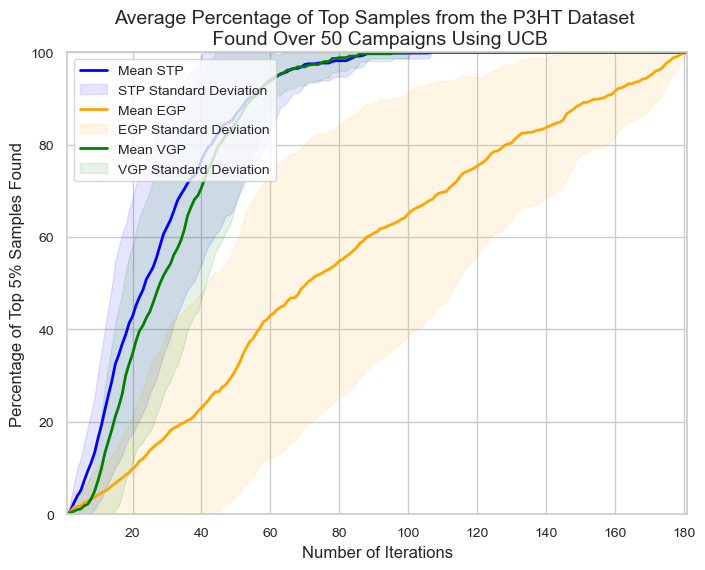

In [58]:
for element in maxDatasets:

    print(f"Starting {element}")

    dataset = element
    
    data = pd.read_csv(f"datasets\{dataset}_dataset.csv")
    data = data.groupby(data.columns[-1]).mean().reset_index()
    train_x = torch.tensor(data.iloc[:, 1:].values)
    train_y = torch.tensor(data.iloc[:, 0].values).unsqueeze(1) 

    N = len(train_x)

    # We are using prededfined candidates, so we can scale at the start
    TorchStd = TorchStandardScaler()
    TorchStd.fit(train_x)
    
    set_seeds(0)

    print(f"Number of samples: {N}")
    
    n_top = int(math.ceil(N * 0.05))

    # find the top 5% of the samples
    train_y_df = pd.DataFrame(train_y.numpy(), columns=[0])
    top_samples = train_y_df.nlargest(n_top, train_y_df.columns[0], keep='first').iloc[:, 0].values.tolist()
    print(f"Number of of top 5% samples: {len(top_samples)}")
    print(f"Top 5% samples: {top_samples}")

    def TopSamplesAmnt(y, top_samples):
        return len([i for i in y if i in top_samples]) / len(top_samples)

    # Generate a list of seeds randomly picked from the range 0-1000 equal to the number of campaigns without repeating
    seedList = random.sample(range(1000), campaigns)

    for i in trange(len(seedList)):
        globals()['topEGP' + str(i)], globals()['iterationEGP' + str(i)] = runMaxEGP(seedList[i])
            
    for i in trange(len(seedList)):
        globals()['topSTP' + str(i)], globals()['iterationSTP' + str(i)] = runMaxSTP(seedList[i])

    for i in trange(len(seedList)):
        globals()['topVGP' + str(i)], globals()['iterationVGP' + str(i)] = runMaxVGP(seedList[i])


    num_arrays = len(seedList)  
    # Function to dynamically collect arrays
    def collect_arrays(prefix, num_arrays):
        arrays = []
        for i in range(num_arrays):
            array = globals().get(f'{prefix}{i}', None)
            if array is not None:
                arrays.append(array)
        return arrays

    # Function to pad arrays with the last element to match the maximum length
    def pad_array(array, max_length):
        return np.pad(array, (0, max_length - len(array)), 'constant', constant_values=array[-1])

    def find_max_length(prefix, num_arrays):
        arrays = collect_arrays(prefix, num_arrays)
        return max(len(arr) for arr in arrays)

    # Process arrays for each type
    def process_arrays(prefix, num_arrays, max_length):
        arrays = collect_arrays(prefix, num_arrays)
        padded_arrays = [pad_array(arr, max_length) for arr in arrays]
        stack = np.stack(padded_arrays)
        mean_values = np.mean(stack, axis=0)
        std_values = np.std(stack, axis=0)
        return mean_values, std_values

    # Process arrays for STP, EGP, and VGP
    max_length_STP = find_max_length('topSTP', num_arrays)
    max_length_EGP = find_max_length('topEGP', num_arrays)
    max_length_VGP = find_max_length('topVGP', num_arrays)
    max_length = max(max_length_STP, max_length_EGP, max_length_VGP)
    mean_topSTP, std_valuesSTP = process_arrays('topSTP', num_arrays, max_length)
    mean_topEGP, std_valuesEGP = process_arrays('topEGP', num_arrays, max_length)
    mean_topVGP, std_valuesVGP = process_arrays('topVGP', num_arrays, max_length)

    # Ensure that the number of iterations matches the longest array length
    max_length = max(max_length_STP, max_length_EGP, max_length_VGP)
    iterations = np.arange(1, max_length + 1)



    sns.set(style="whitegrid")
    # Plot the mean and fill between the min and max for each type
    plt.figure(figsize=(8, 6))

    # Plot for STP
    sns.lineplot(x=iterations, y=mean_topSTP, label='Mean STP', color='blue', linewidth=2)
    plt.fill_between(iterations, mean_topSTP - std_valuesSTP, mean_topSTP + std_valuesSTP, label='STP Standard Deviation', color='blue', alpha=0.1)

    # Plot for EGP
    sns.lineplot(x=iterations, y=mean_topEGP, label='Mean EGP', color='orange', linewidth=2)
    plt.fill_between(iterations, mean_topEGP - std_valuesEGP, mean_topEGP + std_valuesEGP, label='EGP Standard Deviation', color='orange', alpha=0.1)

    # Plot for VGP
    plt.plot(iterations, mean_topVGP, label='Mean VGP', color='green', linewidth=2)
    plt.fill_between(iterations, mean_topVGP - std_valuesVGP, mean_topVGP + std_valuesVGP, label='VGP Standard Deviation', color='green', alpha=0.1)

    plt.xlabel('Number of Iterations', fontsize=12)
    plt.ylabel('Percentage of Top 5% Samples Found', fontsize=12)
    plt.title(f'Average Percentage of Top Samples from the {dataset} Dataset \n Found Over {num_arrays} Campaigns Using UCB', fontsize=14)
    plt.legend(fontsize=10, loc='upper left')

    # Customize ticks
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Adjust axis limits and aspect ratio if needed
    plt.ylim(0, 100)
    plt.xlim(1, max_length)


    # save the plot 
    plt.savefig(f"UCB{dataset}{campaigns}CampaignsMax")
    plt.show()


# Minimize Test

<string>:7: SyntaxWarning: invalid escape sequence '\{'
<>:7: SyntaxWarning: invalid escape sequence '\{'
<string>:7: SyntaxWarning: invalid escape sequence '\{'
<>:7: SyntaxWarning: invalid escape sequence '\{'
C:\Users\stan\AppData\Local\Temp\ipykernel_35956\2179347115.py:7: SyntaxWarning: invalid escape sequence '\{'
  data = pd.read_csv(f"datasets\{dataset}_dataset.csv")


Starting Perovskite
Number of of top 5% samples: 7
Top 5% samples: [23707.0, 24723.0, 26197.0, 27122.0, 38370.0, 38893.0, 40621.0]


  0%|          | 0/50 [00:00<?, ?it/s]

Minimizing with STP
Seed: 864
Initial points: tensor([[0.0000, 0.0000, 1.0000],
        [0.0900, 0.8700, 0.0400],
        [0.2500, 0.7000, 0.0600],
        [0.0500, 0.7885, 0.1615],
        [0.7500, 0.2500, 0.0000]])


  2%|▏         | 1/50 [00:56<46:13, 56.60s/it]

Iterations 81
Minimizing with STP
Seed: 394
Initial points: tensor([[0.2000, 0.6900, 0.1100],
        [0.7500, 0.0000, 0.2500],
        [0.2700, 0.3400, 0.4000],
        [0.1300, 0.7900, 0.0800],
        [0.2500, 0.7000, 0.0600]])


  4%|▍         | 2/50 [01:36<37:21, 46.70s/it]

Iterations 59
Minimizing with STP
Seed: 776
Initial points: tensor([[0.2500, 0.2500, 0.5000],
        [0.8900, 0.0000, 0.1100],
        [0.9600, 0.0400, 0.0000],
        [0.1300, 0.7900, 0.0800],
        [0.1800, 0.7800, 0.0400]])


  6%|▌         | 3/50 [02:11<32:27, 41.44s/it]

Iterations 53
Minimizing with STP
Seed: 911
Initial points: tensor([[0.2000, 0.6900, 0.1100],
        [0.0900, 0.8700, 0.0400],
        [0.8400, 0.0000, 0.1600],
        [0.1600, 0.8400, 0.0000],
        [0.1800, 0.7800, 0.0400]])


  8%|▊         | 4/50 [02:52<31:42, 41.35s/it]

Iterations 60
Minimizing with STP
Seed: 430
Initial points: tensor([[0.0000, 0.2500, 0.7500],
        [0.5000, 0.2500, 0.2500],
        [0.1800, 0.7800, 0.0400],
        [0.7800, 0.0900, 0.1300],
        [0.7100, 0.0100, 0.2800]])


 10%|█         | 5/50 [03:46<34:24, 45.89s/it]

Iterations 78
Minimizing with STP
Seed: 41
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.7500, 0.0000, 0.2500],
        [0.2600, 0.3700, 0.3600],
        [0.7100, 0.0100, 0.2800],
        [0.2700, 0.3400, 0.4000]])


 12%|█▏        | 6/50 [04:21<30:56, 42.18s/it]

Iterations 52
Minimizing with STP
Seed: 265
Initial points: tensor([[0.9100, 0.0100, 0.0800],
        [0.5000, 0.0000, 0.5000],
        [0.2800, 0.6500, 0.0700],
        [0.3500, 0.6500, 0.0000],
        [0.0900, 0.8500, 0.0600]])


 14%|█▍        | 7/50 [05:06<30:57, 43.20s/it]

Iterations 67
Minimizing with STP
Seed: 988
Initial points: tensor([[0.7600, 0.2400, 0.0000],
        [0.8900, 0.0000, 0.1100],
        [0.1600, 0.7000, 0.1400],
        [0.5000, 0.0000, 0.5000],
        [0.1300, 0.8500, 0.0200]])


 16%|█▌        | 8/50 [05:50<30:22, 43.39s/it]

Iterations 65
Minimizing with STP
Seed: 523
Initial points: tensor([[0.2800, 0.6500, 0.0700],
        [0.6300, 0.3700, 0.0000],
        [0.0500, 0.7885, 0.1615],
        [0.8900, 0.0000, 0.1100],
        [0.1300, 0.8700, 0.0000]])


 18%|█▊        | 9/50 [06:22<27:11, 39.79s/it]

Iterations 59
Minimizing with STP
Seed: 497
Initial points: tensor([[0.8900, 0.0000, 0.1100],
        [0.1600, 0.7500, 0.0900],
        [0.2500, 0.7100, 0.0400],
        [0.0000, 0.2500, 0.7500],
        [0.1300, 0.7900, 0.0800]])


 20%|██        | 10/50 [07:05<27:11, 40.78s/it]

Iterations 79
Minimizing with STP
Seed: 414
Initial points: tensor([[0.2500, 0.7500, 0.0000],
        [0.0000, 0.2500, 0.7500],
        [0.1600, 0.7500, 0.0900],
        [0.5900, 0.4100, 0.0000],
        [0.0000, 1.0000, 0.0000]])


 22%|██▏       | 11/50 [07:43<25:53, 39.85s/it]

Iterations 70
Minimizing with STP
Seed: 940
Initial points: tensor([[0.1000, 0.8900, 0.0100],
        [0.4300, 0.5700, 0.0000],
        [0.0000, 0.2500, 0.7500],
        [0.0000, 0.0000, 1.0000],
        [0.2200, 0.7200, 0.0600]])


 24%|██▍       | 12/50 [08:13<23:20, 36.84s/it]

Iterations 57
Minimizing with STP
Seed: 802
Initial points: tensor([[0.0000, 0.5000, 0.5000],
        [0.2500, 0.7000, 0.0600],
        [0.2800, 0.3700, 0.3500],
        [0.0500, 0.7885, 0.1615],
        [0.3700, 0.6300, 0.0000]])


 26%|██▌       | 13/50 [08:43<21:26, 34.77s/it]

Iterations 56
Minimizing with STP
Seed: 849
Initial points: tensor([[0.0000, 0.2500, 0.7500],
        [0.8100, 0.0000, 0.1900],
        [0.8300, 0.0000, 0.1700],
        [0.6600, 0.2400, 0.1000],
        [0.4400, 0.5500, 0.0100]])


 28%|██▊       | 14/50 [09:17<20:41, 34.48s/it]

Iterations 64
Minimizing with STP
Seed: 310
Initial points: tensor([[0.3200, 0.6700, 0.0100],
        [0.0000, 0.0000, 1.0000],
        [0.2200, 0.7800, 0.0000],
        [0.6900, 0.3100, 0.0000],
        [0.1400, 0.8400, 0.0200]])


 30%|███       | 15/50 [10:00<21:45, 37.29s/it]

Iterations 81
Minimizing with STP
Seed: 991
Initial points: tensor([[0.5000, 0.0000, 0.5000],
        [0.1300, 0.7900, 0.0800],
        [0.7500, 0.0000, 0.2500],
        [0.2500, 0.2500, 0.5000],
        [0.0500, 0.7885, 0.1615]])


 32%|███▏      | 16/50 [10:32<20:04, 35.42s/it]

Iterations 58
Minimizing with STP
Seed: 488
Initial points: tensor([[0.3400, 0.6400, 0.0200],
        [0.2500, 0.2500, 0.5000],
        [0.2500, 0.7000, 0.0600],
        [0.1800, 0.7800, 0.0400],
        [1.0000, 0.0000, 0.0000]])


 34%|███▍      | 17/50 [11:26<22:37, 41.13s/it]

Iterations 99
Minimizing with STP
Seed: 366
Initial points: tensor([[0.6900, 0.3100, 0.0000],
        [0.6300, 0.3700, 0.0000],
        [0.0000, 0.7500, 0.2500],
        [0.2600, 0.3800, 0.3600],
        [0.3000, 0.6900, 0.0100]])


 36%|███▌      | 18/50 [12:04<21:30, 40.32s/it]

Iterations 72
Minimizing with STP
Seed: 597
Initial points: tensor([[0.6800, 0.1300, 0.1900],
        [0.0000, 0.0000, 1.0000],
        [0.5000, 0.2500, 0.2500],
        [0.1300, 0.8700, 0.0000],
        [0.0500, 0.7885, 0.1615]])


 38%|███▊      | 19/50 [12:23<17:26, 33.74s/it]

Iterations 35
Minimizing with STP
Seed: 913
Initial points: tensor([[0.1300, 0.7900, 0.0800],
        [0.8300, 0.0000, 0.1700],
        [0.1300, 0.7900, 0.0800],
        [0.7500, 0.2500, 0.0000],
        [0.3400, 0.5400, 0.1200]])


 40%|████      | 20/50 [12:54<16:28, 32.94s/it]

Iterations 59
Minimizing with STP
Seed: 929
Initial points: tensor([[0.2600, 0.7400, 0.0000],
        [0.7100, 0.0100, 0.2800],
        [0.7500, 0.2500, 0.0000],
        [0.1200, 0.7700, 0.1100],
        [0.2500, 0.0000, 0.7500]])


 42%|████▏     | 21/50 [13:25<15:40, 32.44s/it]

Iterations 58
Minimizing with STP
Seed: 223
Initial points: tensor([[0.1300, 0.8700, 0.0000],
        [0.4300, 0.5700, 0.0000],
        [0.1700, 0.8000, 0.0300],
        [0.8100, 0.0000, 0.1900],
        [0.7800, 0.0900, 0.1300]])


 44%|████▍     | 22/50 [14:01<15:35, 33.40s/it]

Iterations 66
Minimizing with STP
Seed: 516
Initial points: tensor([[0.3100, 0.3600, 0.3300],
        [0.6600, 0.2400, 0.1000],
        [0.2500, 0.7000, 0.0600],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 0.5000, 0.5000]])


 46%|████▌     | 23/50 [14:35<15:05, 33.53s/it]

Iterations 64
Minimizing with STP
Seed: 142
Initial points: tensor([[0.3800, 0.6200, 0.0000],
        [0.2600, 0.3800, 0.3600],
        [0.5000, 0.5000, 0.0000],
        [0.2500, 0.0000, 0.7500],
        [0.1700, 0.8000, 0.0300]])


 48%|████▊     | 24/50 [15:05<14:04, 32.48s/it]

Iterations 57
Minimizing with STP
Seed: 288
Initial points: tensor([[0.2200, 0.7800, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.2500, 0.2500, 0.5000],
        [0.5000, 0.2500, 0.2500],
        [0.7100, 0.0600, 0.2300]])


 50%|█████     | 25/50 [15:30<12:34, 30.20s/it]

Iterations 48
Minimizing with STP
Seed: 143
Initial points: tensor([[0.3200, 0.6700, 0.0100],
        [0.1300, 0.7900, 0.0800],
        [0.1600, 0.8400, 0.0000],
        [0.1700, 0.8000, 0.0300],
        [0.3000, 0.6900, 0.0100]])


 52%|█████▏    | 26/50 [16:09<13:10, 32.92s/it]

Iterations 71
Minimizing with STP
Seed: 773
Initial points: tensor([[0.1400, 0.8400, 0.0200],
        [0.3900, 0.6100, 0.0000],
        [0.1300, 0.7900, 0.0800],
        [0.7800, 0.0900, 0.1300],
        [0.0000, 1.0000, 0.0000]])


 54%|█████▍    | 27/50 [16:40<12:28, 32.53s/it]

Iterations 55
Minimizing with STP
Seed: 97
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.3400, 0.5400, 0.1200],
        [0.2500, 0.2500, 0.5000],
        [0.3200, 0.6700, 0.0100],
        [0.7500, 0.2500, 0.0000]])


 56%|█████▌    | 28/50 [17:25<13:14, 36.11s/it]

Iterations 79
Minimizing with STP
Seed: 633
Initial points: tensor([[0.1300, 0.8500, 0.0200],
        [1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000],
        [0.5000, 0.2500, 0.2500],
        [0.0000, 1.0000, 0.0000]])


 58%|█████▊    | 29/50 [18:02<12:44, 36.42s/it]

Iterations 68
Minimizing with STP
Seed: 818
Initial points: tensor([[0.8100, 0.0000, 0.1900],
        [0.2600, 0.3800, 0.3600],
        [0.1200, 0.7700, 0.1100],
        [0.0500, 0.7885, 0.1615],
        [0.2500, 0.7100, 0.0400]])


 60%|██████    | 30/50 [18:48<13:05, 39.29s/it]

Iterations 84
Minimizing with STP
Seed: 256
Initial points: tensor([[0.2700, 0.7200, 0.0100],
        [0.8700, 0.1200, 0.0100],
        [0.5000, 0.2500, 0.2500],
        [0.1200, 0.7700, 0.1100],
        [0.0000, 0.7500, 0.2500]])


 62%|██████▏   | 31/50 [19:23<12:03, 38.06s/it]

Iterations 64
Minimizing with STP
Seed: 931
Initial points: tensor([[0.5000, 0.0000, 0.5000],
        [0.0900, 0.9100, 0.0000],
        [0.0900, 0.8700, 0.0400],
        [0.1300, 0.8700, 0.0000],
        [0.1200, 0.7700, 0.1100]])


 64%|██████▍   | 32/50 [19:55<10:51, 36.17s/it]

Iterations 59
Minimizing with STP
Seed: 545
Initial points: tensor([[0.1300, 0.7900, 0.0800],
        [0.0900, 0.8700, 0.0400],
        [0.0000, 0.0000, 1.0000],
        [0.1300, 0.8700, 0.0000],
        [0.2000, 0.6900, 0.1100]])


 66%|██████▌   | 33/50 [20:32<10:20, 36.48s/it]

Iterations 68
Minimizing with STP
Seed: 722
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.0900, 0.8700, 0.0400],
        [0.3200, 0.6700, 0.0100],
        [0.2500, 0.7000, 0.0600],
        [0.5000, 0.2500, 0.2500]])


 68%|██████▊   | 34/50 [20:59<08:55, 33.49s/it]

Iterations 50
Minimizing with STP
Seed: 829
Initial points: tensor([[0.3100, 0.3000, 0.3900],
        [0.2500, 0.7000, 0.0600],
        [0.3000, 0.6900, 0.0100],
        [0.1300, 0.8700, 0.0000],
        [0.2500, 0.7100, 0.0400]])


 70%|███████   | 35/50 [21:28<08:04, 32.30s/it]

Iterations 54
Minimizing with STP
Seed: 616
Initial points: tensor([[0.2600, 0.7400, 0.0000],
        [0.1600, 0.8400, 0.0000],
        [0.1000, 0.8900, 0.0100],
        [0.3200, 0.6700, 0.0100],
        [0.1300, 0.7900, 0.0800]])


 72%|███████▏  | 36/50 [22:00<07:30, 32.17s/it]

Iterations 59
Minimizing with STP
Seed: 923
Initial points: tensor([[0.8100, 0.0000, 0.1900],
        [0.2000, 0.6900, 0.1100],
        [0.4100, 0.5800, 0.0100],
        [0.0900, 0.8500, 0.0600],
        [0.1700, 0.8000, 0.0300]])


 74%|███████▍  | 37/50 [22:37<07:15, 33.49s/it]

Iterations 67
Minimizing with STP
Seed: 150
Initial points: tensor([[0.8900, 0.0000, 0.1100],
        [0.7800, 0.0900, 0.1300],
        [0.2000, 0.6900, 0.1100],
        [0.2700, 0.3400, 0.4000],
        [0.0000, 0.7500, 0.2500]])


 76%|███████▌  | 38/50 [23:11<06:46, 33.88s/it]

Iterations 63
Minimizing with STP
Seed: 317
Initial points: tensor([[0.1800, 0.7800, 0.0400],
        [0.2500, 0.7000, 0.0600],
        [0.0500, 0.7885, 0.1615],
        [0.0000, 0.0000, 1.0000],
        [0.3100, 0.3600, 0.3300]])


 78%|███████▊  | 39/50 [23:45<06:10, 33.71s/it]

Iterations 62
Minimizing with STP
Seed: 101
Initial points: tensor([[0.2500, 0.7000, 0.0600],
        [0.0000, 0.0000, 1.0000],
        [0.0600, 0.8500, 0.0900],
        [0.2500, 0.7000, 0.0600],
        [0.6300, 0.3700, 0.0000]])


 80%|████████  | 40/50 [24:27<06:03, 36.38s/it]

Iterations 78
Minimizing with STP
Seed: 747
Initial points: tensor([[0.0000, 0.5000, 0.5000],
        [0.1900, 0.7000, 0.1100],
        [0.6300, 0.3700, 0.0000],
        [0.2500, 0.2500, 0.5000],
        [0.3200, 0.6700, 0.0100]])


 82%|████████▏ | 41/50 [24:58<05:13, 34.80s/it]

Iterations 59
Minimizing with STP
Seed: 75
Initial points: tensor([[0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 0.0000],
        [0.0000, 0.0000, 1.0000],
        [0.3700, 0.6200, 0.0100],
        [0.1300, 0.8500, 0.0200]])


 84%|████████▍ | 42/50 [25:27<04:23, 32.95s/it]

Iterations 53
Minimizing with STP
Seed: 920
Initial points: tensor([[0.0000, 0.0000, 1.0000],
        [0.2500, 0.7000, 0.0600],
        [0.5300, 0.4700, 0.0000],
        [0.2000, 0.6900, 0.1100],
        [1.0000, 0.0000, 0.0000]])


 86%|████████▌ | 43/50 [26:06<04:03, 34.78s/it]

Iterations 73
Minimizing with STP
Seed: 870
Initial points: tensor([[0.7100, 0.0100, 0.2800],
        [0.1000, 0.9000, 0.0000],
        [0.1900, 0.8100, 0.0000],
        [0.8400, 0.0000, 0.1600],
        [0.1200, 0.7700, 0.1100]])


 88%|████████▊ | 44/50 [26:52<03:49, 38.20s/it]

Iterations 85
Minimizing with STP
Seed: 700
Initial points: tensor([[0.0000, 0.0000, 1.0000],
        [0.1800, 0.7800, 0.0400],
        [0.5300, 0.4700, 0.0000],
        [0.3000, 0.6900, 0.0100],
        [0.1600, 0.8400, 0.0000]])


 90%|█████████ | 45/50 [27:33<03:14, 38.93s/it]

Iterations 75
Minimizing with STP
Seed: 338
Initial points: tensor([[0.0000, 0.5000, 0.5000],
        [0.2500, 0.7000, 0.0600],
        [0.1300, 0.7900, 0.0800],
        [0.7500, 0.2500, 0.0000],
        [0.7500, 0.2500, 0.0000]])


 92%|█████████▏| 46/50 [28:19<02:43, 40.92s/it]

Iterations 80
Minimizing with STP
Seed: 483
Initial points: tensor([[0.1300, 0.8700, 0.0000],
        [0.0900, 0.8700, 0.0400],
        [0.1600, 0.8400, 0.0000],
        [0.5700, 0.4300, 0.0000],
        [0.7500, 0.0000, 0.2500]])


 94%|█████████▍| 47/50 [28:56<01:59, 39.74s/it]

Iterations 67
Minimizing with STP
Seed: 573
Initial points: tensor([[0.8900, 0.0000, 0.1100],
        [0.3900, 0.6100, 0.0000],
        [0.0000, 0.0000, 1.0000],
        [0.3700, 0.6200, 0.0100],
        [0.2700, 0.3400, 0.4000]])


 96%|█████████▌| 48/50 [29:23<01:12, 36.05s/it]

Iterations 51
Minimizing with STP
Seed: 103
Initial points: tensor([[0.0000, 0.0000, 1.0000],
        [0.1600, 0.8400, 0.0000],
        [0.1200, 0.8100, 0.0700],
        [0.2500, 0.7500, 0.0000],
        [0.0600, 0.8500, 0.0900]])


 98%|█████████▊| 49/50 [30:00<00:36, 36.37s/it]

Iterations 67
Minimizing with STP
Seed: 362
Initial points: tensor([[0.1900, 0.7000, 0.1100],
        [0.4100, 0.5800, 0.0100],
        [0.2600, 0.3700, 0.3600],
        [0.2800, 0.3700, 0.3500],
        [0.2500, 0.7100, 0.0400]])


100%|██████████| 50/50 [30:47<00:00, 36.95s/it]


Iterations 83


  0%|          | 0/50 [00:00<?, ?it/s]

Minimizing with EGP
Seed: 864
Initial points: tensor([[0.0000, 0.0000, 1.0000],
        [0.0900, 0.8700, 0.0400],
        [0.2500, 0.7000, 0.0600],
        [0.0500, 0.7885, 0.1615],
        [0.7500, 0.2500, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 79
Minimizing with EGP
Seed: 394
Initial points: tensor([[0.2000, 0.6900, 0.1100],
        [0.7500, 0.0000, 0.2500],
        [0.2700, 0.3400, 0.4000],
        [0.1300, 0.7900, 0.0800],
        [0.2500, 0.7000, 0.0600]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to n

Iterations 74
Minimizing with EGP
Seed: 776
Initial points: tensor([[0.2500, 0.2500, 0.5000],
        [0.8900, 0.0000, 0.1100],
        [0.9600, 0.0400, 0.0000],
        [0.1300, 0.7900, 0.0800],
        [0.1800, 0.7800, 0.0400]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying o

Iterations 55
Minimizing with EGP
Seed: 911
Initial points: tensor([[0.2000, 0.6900, 0.1100],
        [0.0900, 0.8700, 0.0400],
        [0.8400, 0.0000, 0.1600],
        [0.1600, 0.8400, 0.0000],
        [0.1800, 0.7800, 0.0400]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 65
Minimizing with EGP
Seed: 430
Initial points: tensor([[0.0000, 0.2500, 0.7500],
        [0.5000, 0.2500, 0.2500],
        [0.1800, 0.7800, 0.0400],
        [0.7800, 0.0900, 0.1300],
        [0.7100, 0.0100, 0.2800]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils

Iterations 75
Minimizing with EGP
Seed: 41
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.7500, 0.0000, 0.2500],
        [0.2600, 0.3700, 0.3600],
        [0.7100, 0.0100, 0.2800],
        [0.2700, 0.3400, 0.4000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.war

Iterations 98
Minimizing with EGP
Seed: 265
Initial points: tensor([[0.9100, 0.0100, 0.0800],
        [0.5000, 0.0000, 0.5000],
        [0.2800, 0.6500, 0.0700],
        [0.3500, 0.6500, 0.0000],
        [0.0900, 0.8500, 0.0600]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 101
Minimizing with EGP
Seed: 988
Initial points: tensor([[0.7600, 0.2400, 0.0000],
        [0.8900, 0.0000, 0.1100],
        [0.1600, 0.7000, 0.1400],
        [0.5000, 0.0000, 0.5000],
        [0.1300, 0.8500, 0.0200]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 16%|█▌        | 8/50 [01:42<10:05, 14.41s/it]

Iterations 95
Minimizing with EGP
Seed: 523
Initial points: tensor([[0.2800, 0.6500, 0.0700],
        [0.6300, 0.3700, 0.0000],
        [0.0500, 0.7885, 0.1615],
        [0.8900, 0.0000, 0.1100],
        [0.1300, 0.8700, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to n

Iterations 87
Minimizing with EGP
Seed: 497
Initial points: tensor([[0.8900, 0.0000, 0.1100],
        [0.1600, 0.7500, 0.0900],
        [0.2500, 0.7100, 0.0400],
        [0.0000, 0.2500, 0.7500],
        [0.1300, 0.7900, 0.0800]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 78
Minimizing with EGP
Seed: 414
Initial points: tensor([[0.2500, 0.7500, 0.0000],
        [0.0000, 0.2500, 0.7500],
        [0.1600, 0.7500, 0.0900],
        [0.5900, 0.4100, 0.0000],
        [0.0000, 1.0000, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 85
Minimizing with EGP
Seed: 940
Initial points: tensor([[0.1000, 0.8900, 0.0100],
        [0.4300, 0.5700, 0.0000],
        [0.0000, 0.2500, 0.7500],
        [0.0000, 0.0000, 1.0000],
        [0.2200, 0.7200, 0.0600]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 24%|██▍       | 12/50 [02:35<08:35, 13.56s/it]

Iterations 77
Minimizing with EGP
Seed: 802
Initial points: tensor([[0.0000, 0.5000, 0.5000],
        [0.2500, 0.7000, 0.0600],
        [0.2800, 0.3700, 0.3500],
        [0.0500, 0.7885, 0.1615],
        [0.3700, 0.6300, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 26%|██▌       | 13/50 [02:45<07:35, 12.31s/it]

Iterations 71
Minimizing with EGP
Seed: 849
Initial points: tensor([[0.0000, 0.2500, 0.7500],
        [0.8100, 0.0000, 0.1900],
        [0.8300, 0.0000, 0.1700],
        [0.6600, 0.2400, 0.1000],
        [0.4400, 0.5500, 0.0100]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 79
Minimizing with EGP
Seed: 310
Initial points: tensor([[0.3200, 0.6700, 0.0100],
        [0.0000, 0.0000, 1.0000],
        [0.2200, 0.7800, 0.0000],
        [0.6900, 0.3100, 0.0000],
        [0.1400, 0.8400, 0.0200]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 98
Minimizing with EGP
Seed: 991
Initial points: tensor([[0.5000, 0.0000, 0.5000],
        [0.1300, 0.7900, 0.0800],
        [0.7500, 0.0000, 0.2500],
        [0.2500, 0.2500, 0.5000],
        [0.0500, 0.7885, 0.1615]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 70
Minimizing with EGP
Seed: 488
Initial points: tensor([[0.3400, 0.6400, 0.0200],
        [0.2500, 0.2500, 0.5000],
        [0.2500, 0.7000, 0.0600],
        [0.1800, 0.7800, 0.0400],
        [1.0000, 0.0000, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying o

Iterations 63
Minimizing with EGP
Seed: 366
Initial points: tensor([[0.6900, 0.3100, 0.0000],
        [0.6300, 0.3700, 0.0000],
        [0.0000, 0.7500, 0.2500],
        [0.2600, 0.3800, 0.3600],
        [0.3000, 0.6900, 0.0100]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 57
Minimizing with EGP
Seed: 597
Initial points: tensor([[0.6800, 0.1300, 0.1900],
        [0.0000, 0.0000, 1.0000],
        [0.5000, 0.2500, 0.2500],
        [0.1300, 0.8700, 0.0000],
        [0.0500, 0.7885, 0.1615]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 93
Minimizing with EGP
Seed: 913
Initial points: tensor([[0.1300, 0.7900, 0.0800],
        [0.8300, 0.0000, 0.1700],
        [0.1300, 0.7900, 0.0800],
        [0.7500, 0.2500, 0.0000],
        [0.3400, 0.5400, 0.1200]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils

Iterations 94
Minimizing with EGP
Seed: 929
Initial points: tensor([[0.2600, 0.7400, 0.0000],
        [0.7100, 0.0100, 0.2800],
        [0.7500, 0.2500, 0.0000],
        [0.1200, 0.7700, 0.1100],
        [0.2500, 0.0000, 0.7500]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 42%|████▏     | 21/50 [04:29<06:13, 12.88s/it]

Iterations 66
Minimizing with EGP
Seed: 223
Initial points: tensor([[0.1300, 0.8700, 0.0000],
        [0.4300, 0.5700, 0.0000],
        [0.1700, 0.8000, 0.0300],
        [0.8100, 0.0000, 0.1900],
        [0.7800, 0.0900, 0.1300]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 89
Minimizing with EGP
Seed: 516
Initial points: tensor([[0.3100, 0.3600, 0.3300],
        [0.6600, 0.2400, 0.1000],
        [0.2500, 0.7000, 0.0600],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 0.5000, 0.5000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 106
Minimizing with EGP
Seed: 142
Initial points: tensor([[0.3800, 0.6200, 0.0000],
        [0.2600, 0.3800, 0.3600],
        [0.5000, 0.5000, 0.0000],
        [0.2500, 0.0000, 0.7500],
        [0.1700, 0.8000, 0.0300]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 95
Minimizing with EGP
Seed: 288
Initial points: tensor([[0.2200, 0.7800, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.2500, 0.2500, 0.5000],
        [0.5000, 0.2500, 0.2500],
        [0.7100, 0.0600, 0.2300]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 69
Minimizing with EGP
Seed: 143
Initial points: tensor([[0.3200, 0.6700, 0.0100],
        [0.1300, 0.7900, 0.0800],
        [0.1600, 0.8400, 0.0000],
        [0.1700, 0.8000, 0.0300],
        [0.3000, 0.6900, 0.0100]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 84
Minimizing with EGP
Seed: 773
Initial points: tensor([[0.1400, 0.8400, 0.0200],
        [0.3900, 0.6100, 0.0000],
        [0.1300, 0.7900, 0.0800],
        [0.7800, 0.0900, 0.1300],
        [0.0000, 1.0000, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.wa

Iterations 71
Minimizing with EGP
Seed: 97
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.3400, 0.5400, 0.1200],
        [0.2500, 0.2500, 0.5000],
        [0.3200, 0.6700, 0.0100],
        [0.7500, 0.2500, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 92
Minimizing with EGP
Seed: 633
Initial points: tensor([[0.1300, 0.8500, 0.0200],
        [1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000],
        [0.5000, 0.2500, 0.2500],
        [0.0000, 1.0000, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying o

Iterations 93
Minimizing with EGP
Seed: 818
Initial points: tensor([[0.8100, 0.0000, 0.1900],
        [0.2600, 0.3800, 0.3600],
        [0.1200, 0.7700, 0.1100],
        [0.0500, 0.7885, 0.1615],
        [0.2500, 0.7100, 0.0400]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying o

Iterations 83
Minimizing with EGP
Seed: 256
Initial points: tensor([[0.2700, 0.7200, 0.0100],
        [0.8700, 0.1200, 0.0100],
        [0.5000, 0.2500, 0.2500],
        [0.1200, 0.7700, 0.1100],
        [0.0000, 0.7500, 0.2500]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying o

Iterations 46
Minimizing with EGP
Seed: 931
Initial points: tensor([[0.5000, 0.0000, 0.5000],
        [0.0900, 0.9100, 0.0000],
        [0.0900, 0.8700, 0.0400],
        [0.1300, 0.8700, 0.0000],
        [0.1200, 0.7700, 0.1100]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 55
Minimizing with EGP
Seed: 545
Initial points: tensor([[0.1300, 0.7900, 0.0800],
        [0.0900, 0.8700, 0.0400],
        [0.0000, 0.0000, 1.0000],
        [0.1300, 0.8700, 0.0000],
        [0.2000, 0.6900, 0.1100]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 61
Minimizing with EGP
Seed: 722
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.0900, 0.8700, 0.0400],
        [0.3200, 0.6700, 0.0100],
        [0.2500, 0.7000, 0.0600],
        [0.5000, 0.2500, 0.2500]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 103
Minimizing with EGP
Seed: 829
Initial points: tensor([[0.3100, 0.3000, 0.3900],
        [0.2500, 0.7000, 0.0600],
        [0.3000, 0.6900, 0.0100],
        [0.1300, 0.8700, 0.0000],
        [0.2500, 0.7100, 0.0400]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnin

Iterations 91
Minimizing with EGP
Seed: 616
Initial points: tensor([[0.2600, 0.7400, 0.0000],
        [0.1600, 0.8400, 0.0000],
        [0.1000, 0.8900, 0.0100],
        [0.3200, 0.6700, 0.0100],
        [0.1300, 0.7900, 0.0800]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical i

Iterations 63
Minimizing with EGP
Seed: 923
Initial points: tensor([[0.8100, 0.0000, 0.1900],
        [0.2000, 0.6900, 0.1100],
        [0.4100, 0.5800, 0.0100],
        [0.0900, 0.8500, 0.0600],
        [0.1700, 0.8000, 0.0300]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 68
Minimizing with EGP
Seed: 150
Initial points: tensor([[0.8900, 0.0000, 0.1100],
        [0.7800, 0.0900, 0.1300],
        [0.2000, 0.6900, 0.1100],
        [0.2700, 0.3400, 0.4000],
        [0.0000, 0.7500, 0.2500]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 60
Minimizing with EGP
Seed: 317
Initial points: tensor([[0.1800, 0.7800, 0.0400],
        [0.2500, 0.7000, 0.0600],
        [0.0500, 0.7885, 0.1615],
        [0.0000, 0.0000, 1.0000],
        [0.3100, 0.3600, 0.3300]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 69
Minimizing with EGP
Seed: 101
Initial points: tensor([[0.2500, 0.7000, 0.0600],
        [0.0000, 0.0000, 1.0000],
        [0.0600, 0.8500, 0.0900],
        [0.2500, 0.7000, 0.0600],
        [0.6300, 0.3700, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 66
Minimizing with EGP
Seed: 747
Initial points: tensor([[0.0000, 0.5000, 0.5000],
        [0.1900, 0.7000, 0.1100],
        [0.6300, 0.3700, 0.0000],
        [0.2500, 0.2500, 0.5000],
        [0.3200, 0.6700, 0.0100]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 104
Minimizing with EGP
Seed: 75
Initial points: tensor([[0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 0.0000],
        [0.0000, 0.0000, 1.0000],
        [0.3700, 0.6200, 0.0100],
        [0.1300, 0.8500, 0.0200]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 93
Minimizing with EGP
Seed: 920
Initial points: tensor([[0.0000, 0.0000, 1.0000],
        [0.2500, 0.7000, 0.0600],
        [0.5300, 0.4700, 0.0000],
        [0.2000, 0.6900, 0.1100],
        [1.0000, 0.0000, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 62
Minimizing with EGP
Seed: 870
Initial points: tensor([[0.7100, 0.0100, 0.2800],
        [0.1000, 0.9000, 0.0000],
        [0.1900, 0.8100, 0.0000],
        [0.8400, 0.0000, 0.1600],
        [0.1200, 0.7700, 0.1100]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 88%|████████▊ | 44/50 [09:18<01:12, 12.05s/it]

Iterations 71
Minimizing with EGP
Seed: 700
Initial points: tensor([[0.0000, 0.0000, 1.0000],
        [0.1800, 0.7800, 0.0400],
        [0.5300, 0.4700, 0.0000],
        [0.3000, 0.6900, 0.0100],
        [0.1600, 0.8400, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 66
Minimizing with EGP
Seed: 338
Initial points: tensor([[0.0000, 0.5000, 0.5000],
        [0.2500, 0.7000, 0.0600],
        [0.1300, 0.7900, 0.0800],
        [0.7500, 0.2500, 0.0000],
        [0.7500, 0.2500, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\chole

Iterations 72
Minimizing with EGP
Seed: 483
Initial points: tensor([[0.1300, 0.8700, 0.0000],
        [0.0900, 0.8700, 0.0400],
        [0.1600, 0.8400, 0.0000],
        [0.5700, 0.4300, 0.0000],
        [0.7500, 0.0000, 0.2500]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying o

Iterations 72
Minimizing with EGP
Seed: 573
Initial points: tensor([[0.8900, 0.0000, 0.1100],
        [0.3900, 0.6100, 0.0000],
        [0.0000, 0.0000, 1.0000],
        [0.3700, 0.6200, 0.0100],
        [0.2700, 0.3400, 0.4000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\chole

Iterations 104
Minimizing with EGP
Seed: 103
Initial points: tensor([[0.0000, 0.0000, 1.0000],
        [0.1600, 0.8400, 0.0000],
        [0.1200, 0.8100, 0.0700],
        [0.2500, 0.7500, 0.0000],
        [0.0600, 0.8500, 0.0900]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 83
Minimizing with EGP
Seed: 362
Initial points: tensor([[0.1900, 0.7000, 0.1100],
        [0.4100, 0.5800, 0.0100],
        [0.2600, 0.3700, 0.3600],
        [0.2800, 0.3700, 0.3500],
        [0.2500, 0.7100, 0.0400]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical i

Iterations 98


  0%|          | 0/50 [00:00<?, ?it/s]

Minimizing with VGP
Seed: 864
Initial points: tensor([[0.0000, 0.0000, 1.0000],
        [0.0900, 0.8700, 0.0400],
        [0.2500, 0.7000, 0.0600],
        [0.0500, 0.7885, 0.1615],
        [0.7500, 0.2500, 0.0000]])


  2%|▏         | 1/50 [00:15<12:55, 15.83s/it]

Iterations 64
Minimizing with VGP
Seed: 394
Initial points: tensor([[0.2000, 0.6900, 0.1100],
        [0.7500, 0.0000, 0.2500],
        [0.2700, 0.3400, 0.4000],
        [0.1300, 0.7900, 0.0800],
        [0.2500, 0.7000, 0.0600]])


  4%|▍         | 2/50 [00:29<11:52, 14.84s/it]

Iterations 58
Minimizing with VGP
Seed: 776
Initial points: tensor([[0.2500, 0.2500, 0.5000],
        [0.8900, 0.0000, 0.1100],
        [0.9600, 0.0400, 0.0000],
        [0.1300, 0.7900, 0.0800],
        [0.1800, 0.7800, 0.0400]])


  6%|▌         | 3/50 [00:38<09:32, 12.18s/it]

Iterations 38
Minimizing with VGP
Seed: 911
Initial points: tensor([[0.2000, 0.6900, 0.1100],
        [0.0900, 0.8700, 0.0400],
        [0.8400, 0.0000, 0.1600],
        [0.1600, 0.8400, 0.0000],
        [0.1800, 0.7800, 0.0400]])


  8%|▊         | 4/50 [00:58<11:31, 15.03s/it]

Iterations 77
Minimizing with VGP
Seed: 430
Initial points: tensor([[0.0000, 0.2500, 0.7500],
        [0.5000, 0.2500, 0.2500],
        [0.1800, 0.7800, 0.0400],
        [0.7800, 0.0900, 0.1300],
        [0.7100, 0.0100, 0.2800]])


 10%|█         | 5/50 [01:16<12:13, 16.30s/it]

Iterations 74
Minimizing with VGP
Seed: 41
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.7500, 0.0000, 0.2500],
        [0.2600, 0.3700, 0.3600],
        [0.7100, 0.0100, 0.2800],
        [0.2700, 0.3400, 0.4000]])


 12%|█▏        | 6/50 [01:38<13:15, 18.09s/it]

Iterations 85
Minimizing with VGP
Seed: 265
Initial points: tensor([[0.9100, 0.0100, 0.0800],
        [0.5000, 0.0000, 0.5000],
        [0.2800, 0.6500, 0.0700],
        [0.3500, 0.6500, 0.0000],
        [0.0900, 0.8500, 0.0600]])


 14%|█▍        | 7/50 [01:56<12:59, 18.14s/it]

Iterations 72
Minimizing with VGP
Seed: 988
Initial points: tensor([[0.7600, 0.2400, 0.0000],
        [0.8900, 0.0000, 0.1100],
        [0.1600, 0.7000, 0.1400],
        [0.5000, 0.0000, 0.5000],
        [0.1300, 0.8500, 0.0200]])


 16%|█▌        | 8/50 [02:10<11:49, 16.89s/it]

Iterations 59
Minimizing with VGP
Seed: 523
Initial points: tensor([[0.2800, 0.6500, 0.0700],
        [0.6300, 0.3700, 0.0000],
        [0.0500, 0.7885, 0.1615],
        [0.8900, 0.0000, 0.1100],
        [0.1300, 0.8700, 0.0000]])


 18%|█▊        | 9/50 [02:21<10:07, 14.83s/it]

Iterations 42
Minimizing with VGP
Seed: 497
Initial points: tensor([[0.8900, 0.0000, 0.1100],
        [0.1600, 0.7500, 0.0900],
        [0.2500, 0.7100, 0.0400],
        [0.0000, 0.2500, 0.7500],
        [0.1300, 0.7900, 0.0800]])


 20%|██        | 10/50 [02:39<10:34, 15.85s/it]

Iterations 73
Minimizing with VGP
Seed: 414
Initial points: tensor([[0.2500, 0.7500, 0.0000],
        [0.0000, 0.2500, 0.7500],
        [0.1600, 0.7500, 0.0900],
        [0.5900, 0.4100, 0.0000],
        [0.0000, 1.0000, 0.0000]])


 22%|██▏       | 11/50 [02:55<10:25, 16.04s/it]

Iterations 67
Minimizing with VGP
Seed: 940
Initial points: tensor([[0.1000, 0.8900, 0.0100],
        [0.4300, 0.5700, 0.0000],
        [0.0000, 0.2500, 0.7500],
        [0.0000, 0.0000, 1.0000],
        [0.2200, 0.7200, 0.0600]])


 24%|██▍       | 12/50 [03:10<09:49, 15.50s/it]

Iterations 58
Minimizing with VGP
Seed: 802
Initial points: tensor([[0.0000, 0.5000, 0.5000],
        [0.2500, 0.7000, 0.0600],
        [0.2800, 0.3700, 0.3500],
        [0.0500, 0.7885, 0.1615],
        [0.3700, 0.6300, 0.0000]])


 26%|██▌       | 13/50 [03:25<09:29, 15.38s/it]

Iterations 62
Minimizing with VGP
Seed: 849
Initial points: tensor([[0.0000, 0.2500, 0.7500],
        [0.8100, 0.0000, 0.1900],
        [0.8300, 0.0000, 0.1700],
        [0.6600, 0.2400, 0.1000],
        [0.4400, 0.5500, 0.0100]])


 28%|██▊       | 14/50 [03:42<09:38, 16.08s/it]

Iterations 72
Minimizing with VGP
Seed: 310
Initial points: tensor([[0.3200, 0.6700, 0.0100],
        [0.0000, 0.0000, 1.0000],
        [0.2200, 0.7800, 0.0000],
        [0.6900, 0.3100, 0.0000],
        [0.1400, 0.8400, 0.0200]])


 30%|███       | 15/50 [04:03<10:05, 17.31s/it]

Iterations 79
Minimizing with VGP
Seed: 991
Initial points: tensor([[0.5000, 0.0000, 0.5000],
        [0.1300, 0.7900, 0.0800],
        [0.7500, 0.0000, 0.2500],
        [0.2500, 0.2500, 0.5000],
        [0.0500, 0.7885, 0.1615]])


 32%|███▏      | 16/50 [04:21<10:00, 17.66s/it]

Iterations 75
Minimizing with VGP
Seed: 488
Initial points: tensor([[0.3400, 0.6400, 0.0200],
        [0.2500, 0.2500, 0.5000],
        [0.2500, 0.7000, 0.0600],
        [0.1800, 0.7800, 0.0400],
        [1.0000, 0.0000, 0.0000]])


 34%|███▍      | 17/50 [04:42<10:16, 18.68s/it]

Iterations 83
Minimizing with VGP
Seed: 366
Initial points: tensor([[0.6900, 0.3100, 0.0000],
        [0.6300, 0.3700, 0.0000],
        [0.0000, 0.7500, 0.2500],
        [0.2600, 0.3800, 0.3600],
        [0.3000, 0.6900, 0.0100]])


 36%|███▌      | 18/50 [05:01<09:58, 18.71s/it]

Iterations 74
Minimizing with VGP
Seed: 597
Initial points: tensor([[0.6800, 0.1300, 0.1900],
        [0.0000, 0.0000, 1.0000],
        [0.5000, 0.2500, 0.2500],
        [0.1300, 0.8700, 0.0000],
        [0.0500, 0.7885, 0.1615]])


 38%|███▊      | 19/50 [05:20<09:44, 18.86s/it]

Iterations 77
Minimizing with VGP
Seed: 913
Initial points: tensor([[0.1300, 0.7900, 0.0800],
        [0.8300, 0.0000, 0.1700],
        [0.1300, 0.7900, 0.0800],
        [0.7500, 0.2500, 0.0000],
        [0.3400, 0.5400, 0.1200]])


 40%|████      | 20/50 [05:39<09:21, 18.73s/it]

Iterations 73
Minimizing with VGP
Seed: 929
Initial points: tensor([[0.2600, 0.7400, 0.0000],
        [0.7100, 0.0100, 0.2800],
        [0.7500, 0.2500, 0.0000],
        [0.1200, 0.7700, 0.1100],
        [0.2500, 0.0000, 0.7500]])


 42%|████▏     | 21/50 [05:57<08:59, 18.59s/it]

Iterations 74
Minimizing with VGP
Seed: 223
Initial points: tensor([[0.1300, 0.8700, 0.0000],
        [0.4300, 0.5700, 0.0000],
        [0.1700, 0.8000, 0.0300],
        [0.8100, 0.0000, 0.1900],
        [0.7800, 0.0900, 0.1300]])


 44%|████▍     | 22/50 [06:16<08:42, 18.67s/it]

Iterations 76
Minimizing with VGP
Seed: 516
Initial points: tensor([[0.3100, 0.3600, 0.3300],
        [0.6600, 0.2400, 0.1000],
        [0.2500, 0.7000, 0.0600],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 0.5000, 0.5000]])


 46%|████▌     | 23/50 [06:34<08:21, 18.57s/it]

Iterations 73
Minimizing with VGP
Seed: 142
Initial points: tensor([[0.3800, 0.6200, 0.0000],
        [0.2600, 0.3800, 0.3600],
        [0.5000, 0.5000, 0.0000],
        [0.2500, 0.0000, 0.7500],
        [0.1700, 0.8000, 0.0300]])


 48%|████▊     | 24/50 [06:52<07:59, 18.43s/it]

Iterations 73
Minimizing with VGP
Seed: 288
Initial points: tensor([[0.2200, 0.7800, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.2500, 0.2500, 0.5000],
        [0.5000, 0.2500, 0.2500],
        [0.7100, 0.0600, 0.2300]])


 50%|█████     | 25/50 [07:11<07:44, 18.57s/it]

Iterations 75
Minimizing with VGP
Seed: 143
Initial points: tensor([[0.3200, 0.6700, 0.0100],
        [0.1300, 0.7900, 0.0800],
        [0.1600, 0.8400, 0.0000],
        [0.1700, 0.8000, 0.0300],
        [0.3000, 0.6900, 0.0100]])


 52%|█████▏    | 26/50 [07:31<07:36, 19.00s/it]

Iterations 79
Minimizing with VGP
Seed: 773
Initial points: tensor([[0.1400, 0.8400, 0.0200],
        [0.3900, 0.6100, 0.0000],
        [0.1300, 0.7900, 0.0800],
        [0.7800, 0.0900, 0.1300],
        [0.0000, 1.0000, 0.0000]])


 54%|█████▍    | 27/50 [07:45<06:44, 17.59s/it]

Iterations 58
Minimizing with VGP
Seed: 97
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.3400, 0.5400, 0.1200],
        [0.2500, 0.2500, 0.5000],
        [0.3200, 0.6700, 0.0100],
        [0.7500, 0.2500, 0.0000]])


 56%|█████▌    | 28/50 [08:06<06:47, 18.54s/it]

Iterations 82
Minimizing with VGP
Seed: 633
Initial points: tensor([[0.1300, 0.8500, 0.0200],
        [1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000],
        [0.5000, 0.2500, 0.2500],
        [0.0000, 1.0000, 0.0000]])


 58%|█████▊    | 29/50 [08:25<06:30, 18.60s/it]

Iterations 75
Minimizing with VGP
Seed: 818
Initial points: tensor([[0.8100, 0.0000, 0.1900],
        [0.2600, 0.3800, 0.3600],
        [0.1200, 0.7700, 0.1100],
        [0.0500, 0.7885, 0.1615],
        [0.2500, 0.7100, 0.0400]])


 60%|██████    | 30/50 [08:37<05:31, 16.57s/it]

Iterations 49
Minimizing with VGP
Seed: 256
Initial points: tensor([[0.2700, 0.7200, 0.0100],
        [0.8700, 0.1200, 0.0100],
        [0.5000, 0.2500, 0.2500],
        [0.1200, 0.7700, 0.1100],
        [0.0000, 0.7500, 0.2500]])


 62%|██████▏   | 31/50 [08:55<05:25, 17.15s/it]

Iterations 74
Minimizing with VGP
Seed: 931
Initial points: tensor([[0.5000, 0.0000, 0.5000],
        [0.0900, 0.9100, 0.0000],
        [0.0900, 0.8700, 0.0400],
        [0.1300, 0.8700, 0.0000],
        [0.1200, 0.7700, 0.1100]])


 64%|██████▍   | 32/50 [09:13<05:13, 17.44s/it]

Iterations 73
Minimizing with VGP
Seed: 545
Initial points: tensor([[0.1300, 0.7900, 0.0800],
        [0.0900, 0.8700, 0.0400],
        [0.0000, 0.0000, 1.0000],
        [0.1300, 0.8700, 0.0000],
        [0.2000, 0.6900, 0.1100]])


 66%|██████▌   | 33/50 [09:30<04:52, 17.18s/it]

Iterations 67
Minimizing with VGP
Seed: 722
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.0900, 0.8700, 0.0400],
        [0.3200, 0.6700, 0.0100],
        [0.2500, 0.7000, 0.0600],
        [0.5000, 0.2500, 0.2500]])


 68%|██████▊   | 34/50 [09:48<04:40, 17.55s/it]

Iterations 74
Minimizing with VGP
Seed: 829
Initial points: tensor([[0.3100, 0.3000, 0.3900],
        [0.2500, 0.7000, 0.0600],
        [0.3000, 0.6900, 0.0100],
        [0.1300, 0.8700, 0.0000],
        [0.2500, 0.7100, 0.0400]])


 70%|███████   | 35/50 [10:07<04:27, 17.86s/it]

Iterations 75
Minimizing with VGP
Seed: 616
Initial points: tensor([[0.2600, 0.7400, 0.0000],
        [0.1600, 0.8400, 0.0000],
        [0.1000, 0.8900, 0.0100],
        [0.3200, 0.6700, 0.0100],
        [0.1300, 0.7900, 0.0800]])


 72%|███████▏  | 36/50 [10:28<04:22, 18.72s/it]

Iterations 82
Minimizing with VGP
Seed: 923
Initial points: tensor([[0.8100, 0.0000, 0.1900],
        [0.2000, 0.6900, 0.1100],
        [0.4100, 0.5800, 0.0100],
        [0.0900, 0.8500, 0.0600],
        [0.1700, 0.8000, 0.0300]])


 74%|███████▍  | 37/50 [10:47<04:04, 18.84s/it]

Iterations 77
Minimizing with VGP
Seed: 150
Initial points: tensor([[0.8900, 0.0000, 0.1100],
        [0.7800, 0.0900, 0.1300],
        [0.2000, 0.6900, 0.1100],
        [0.2700, 0.3400, 0.4000],
        [0.0000, 0.7500, 0.2500]])


 76%|███████▌  | 38/50 [11:00<03:24, 17.08s/it]

Iterations 53
Minimizing with VGP
Seed: 317
Initial points: tensor([[0.1800, 0.7800, 0.0400],
        [0.2500, 0.7000, 0.0600],
        [0.0500, 0.7885, 0.1615],
        [0.0000, 0.0000, 1.0000],
        [0.3100, 0.3600, 0.3300]])


 78%|███████▊  | 39/50 [11:13<02:56, 16.04s/it]

Iterations 56
Minimizing with VGP
Seed: 101
Initial points: tensor([[0.2500, 0.7000, 0.0600],
        [0.0000, 0.0000, 1.0000],
        [0.0600, 0.8500, 0.0900],
        [0.2500, 0.7000, 0.0600],
        [0.6300, 0.3700, 0.0000]])


 80%|████████  | 40/50 [11:29<02:39, 15.91s/it]

Iterations 63
Minimizing with VGP
Seed: 747
Initial points: tensor([[0.0000, 0.5000, 0.5000],
        [0.1900, 0.7000, 0.1100],
        [0.6300, 0.3700, 0.0000],
        [0.2500, 0.2500, 0.5000],
        [0.3200, 0.6700, 0.0100]])


 82%|████████▏ | 41/50 [11:50<02:37, 17.45s/it]

Iterations 83
Minimizing with VGP
Seed: 75
Initial points: tensor([[0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 0.0000],
        [0.0000, 0.0000, 1.0000],
        [0.3700, 0.6200, 0.0100],
        [0.1300, 0.8500, 0.0200]])


 84%|████████▍ | 42/50 [12:08<02:20, 17.62s/it]

Iterations 72
Minimizing with VGP
Seed: 920
Initial points: tensor([[0.0000, 0.0000, 1.0000],
        [0.2500, 0.7000, 0.0600],
        [0.5300, 0.4700, 0.0000],
        [0.2000, 0.6900, 0.1100],
        [1.0000, 0.0000, 0.0000]])


 86%|████████▌ | 43/50 [12:27<02:06, 18.02s/it]

Iterations 75
Minimizing with VGP
Seed: 870
Initial points: tensor([[0.7100, 0.0100, 0.2800],
        [0.1000, 0.9000, 0.0000],
        [0.1900, 0.8100, 0.0000],
        [0.8400, 0.0000, 0.1600],
        [0.1200, 0.7700, 0.1100]])


 88%|████████▊ | 44/50 [12:44<01:46, 17.72s/it]

Iterations 67
Minimizing with VGP
Seed: 700
Initial points: tensor([[0.0000, 0.0000, 1.0000],
        [0.1800, 0.7800, 0.0400],
        [0.5300, 0.4700, 0.0000],
        [0.3000, 0.6900, 0.0100],
        [0.1600, 0.8400, 0.0000]])


 90%|█████████ | 45/50 [13:05<01:33, 18.71s/it]

Iterations 82
Minimizing with VGP
Seed: 338
Initial points: tensor([[0.0000, 0.5000, 0.5000],
        [0.2500, 0.7000, 0.0600],
        [0.1300, 0.7900, 0.0800],
        [0.7500, 0.2500, 0.0000],
        [0.7500, 0.2500, 0.0000]])


 92%|█████████▏| 46/50 [13:23<01:14, 18.54s/it]

Iterations 73
Minimizing with VGP
Seed: 483
Initial points: tensor([[0.1300, 0.8700, 0.0000],
        [0.0900, 0.8700, 0.0400],
        [0.1600, 0.8400, 0.0000],
        [0.5700, 0.4300, 0.0000],
        [0.7500, 0.0000, 0.2500]])


 94%|█████████▍| 47/50 [13:39<00:53, 17.81s/it]

Iterations 65
Minimizing with VGP
Seed: 573
Initial points: tensor([[0.8900, 0.0000, 0.1100],
        [0.3900, 0.6100, 0.0000],
        [0.0000, 0.0000, 1.0000],
        [0.3700, 0.6200, 0.0100],
        [0.2700, 0.3400, 0.4000]])


 96%|█████████▌| 48/50 [14:00<00:37, 18.65s/it]

Iterations 81
Minimizing with VGP
Seed: 103
Initial points: tensor([[0.0000, 0.0000, 1.0000],
        [0.1600, 0.8400, 0.0000],
        [0.1200, 0.8100, 0.0700],
        [0.2500, 0.7500, 0.0000],
        [0.0600, 0.8500, 0.0900]])


 98%|█████████▊| 49/50 [14:14<00:17, 17.25s/it]

Iterations 57
Minimizing with VGP
Seed: 362
Initial points: tensor([[0.1900, 0.7000, 0.1100],
        [0.4100, 0.5800, 0.0100],
        [0.2600, 0.3700, 0.3600],
        [0.2800, 0.3700, 0.3500],
        [0.2500, 0.7100, 0.0400]])


100%|██████████| 50/50 [14:33<00:00, 17.47s/it]

Iterations 77


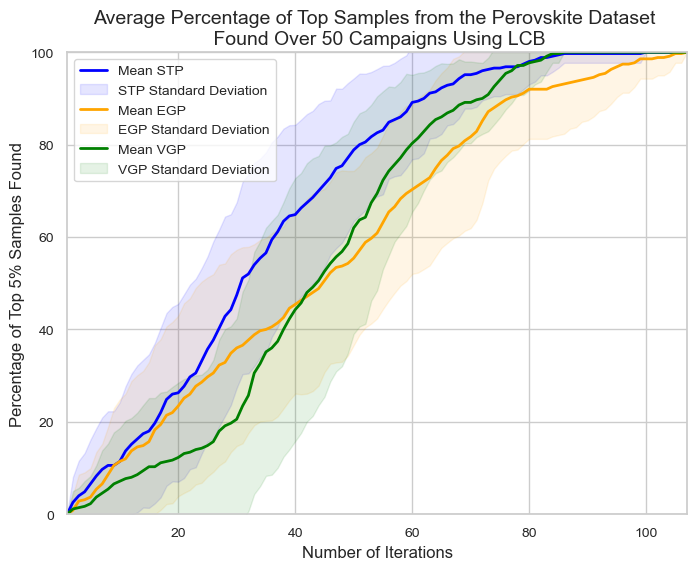

In [59]:
for element in minDatasets:

    print(f"Starting {element}")
    
    dataset = element

    data = pd.read_csv(f"datasets\{dataset}_dataset.csv")
    data = data.groupby(data.columns[-1]).mean().reset_index()
    train_x = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float)
    train_y = torch.tensor(data.iloc[:, 0].values, dtype=torch.float).unsqueeze(1) 

    N = len(train_x)

    # We are using prededfined candidates, so we can scale at the start
    TorchStd = TorchStandardScaler()
    TorchStd.fit(train_x)

    total_samples = len(train_y)

    set_seeds(0)

    n_top = int(math.ceil(N * 0.05))

    # find the top 5% of the samples
    train_y_df = pd.DataFrame(train_y.numpy(), columns=[0])
    top_samples = train_y_df.nsmallest(n_top, train_y_df.columns[0], keep='first').iloc[:, 0].values.tolist()
    print(f"Number of of top 5% samples: {len(top_samples)}")
    print(f"Top 5% samples: {top_samples}")

    def TopSamplesAmnt(y, top_samples):
        return len([i for i in y if i in top_samples]) / len(top_samples)

    # Generate a list of seeds randomly picked from the range 0-1000 equal to the number of campaigns without repeating
    seedList = random.sample(range(1000), campaigns)
            
    for i in trange(len(seedList)):
        globals()['topSTP' + str(i)], globals()['iterationSTP' + str(i)] = runMinSTP(seedList[i])

    for i in trange(len(seedList)):
        globals()['topEGP' + str(i)], globals()['iterationEGP' + str(i)] = runMinEGP(seedList[i])

    for i in trange(len(seedList)):
        globals()['topVGP' + str(i)], globals()['iterationVGP' + str(i)] = runMinVGP(seedList[i])


    num_arrays = len(seedList)  
    # Function to dynamically collect arrays
    def collect_arrays(prefix, num_arrays):
        arrays = []
        for i in range(num_arrays):
            array = globals().get(f'{prefix}{i}', None)
            if array is not None:
                arrays.append(array)
        return arrays

    # Function to pad arrays with the last element to match the maximum length
    def pad_array(array, max_length):
        return np.pad(array, (0, max_length - len(array)), 'constant', constant_values=array[-1])

    def find_max_length(prefix, num_arrays):
        arrays = collect_arrays(prefix, num_arrays)
        return max(len(arr) for arr in arrays)

    # Process arrays for each type
    def process_arrays(prefix, num_arrays, max_length):
        arrays = collect_arrays(prefix, num_arrays)
        padded_arrays = [pad_array(arr, max_length) for arr in arrays]
        stack = np.stack(padded_arrays)
        mean_values = np.mean(stack, axis=0)
        std_values = np.std(stack, axis=0)
        return mean_values, std_values

    # Process arrays for STP, EGP, and VGP
    max_length_STP = find_max_length('topSTP', num_arrays)
    max_length_EGP = find_max_length('topEGP', num_arrays)
    max_length_VGP = find_max_length('topVGP', num_arrays)
    max_length = max(max_length_STP, max_length_EGP, max_length_VGP)
    mean_topSTP, std_valuesSTP = process_arrays('topSTP', num_arrays, max_length)
    mean_topEGP, std_valuesEGP = process_arrays('topEGP', num_arrays, max_length)
    mean_topVGP, std_valuesVGP = process_arrays('topVGP', num_arrays, max_length)

    # Ensure that the number of iterations matches the longest array length
    max_length = max(max_length_STP, max_length_EGP, max_length_VGP)
    iterations = np.arange(1, max_length + 1)



    sns.set(style="whitegrid")
    # Plot the mean and fill between the min and max for each type
    plt.figure(figsize=(8, 6))

    # Plot for STP
    sns.lineplot(x=iterations, y=mean_topSTP, label='Mean STP', color='blue', linewidth=2)
    plt.fill_between(iterations, mean_topSTP - std_valuesSTP, mean_topSTP + std_valuesSTP, label='STP Standard Deviation', color='blue', alpha=0.1)

    # Plot for EGP
    sns.lineplot(x=iterations, y=mean_topEGP, label='Mean EGP', color='orange', linewidth=2)
    plt.fill_between(iterations, mean_topEGP - std_valuesEGP, mean_topEGP + std_valuesEGP, label='EGP Standard Deviation', color='orange', alpha=0.1)

    # Plot for VGP
    plt.plot(iterations, mean_topVGP, label='Mean VGP', color='green', linewidth=2)
    plt.fill_between(iterations, mean_topVGP - std_valuesVGP, mean_topVGP + std_valuesVGP, label='VGP Standard Deviation', color='green', alpha=0.1)

    plt.xlabel('Number of Iterations', fontsize=12)
    plt.ylabel('Percentage of Top 5% Samples Found', fontsize=12)
    plt.title(f'Average Percentage of Top Samples from the {dataset} Dataset \n Found Over {num_arrays} Campaigns Using LCB', fontsize=14)
    plt.legend(fontsize=10, loc='upper left')

    # Customize ticks
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Adjust axis limits and aspect ratio if needed
    plt.ylim(0, 100)
    plt.xlim(1, max_length)


    # save the plot 
    plt.savefig(f"LCB{dataset}{campaigns}CampaignsMin")
    plt.show()